<a href="https://colab.research.google.com/github/chuanluchen/NLP/blob/master/ELMo%E4%B8%AD%E6%96%87%E6%96%B0%E9%97%BB%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 连接网盘

In [1]:
# 连接google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# 确保已经连上
!ls "/content/drive/My Drive/Colab Notebooks/ELMoForManyLangs"

build	      configs  elmoformanylangs		  README.md
cnn_model.h5  dist     elmoformanylangs.egg-info  setup.py


## 导入包

In [3]:
# 导入utils
import importlib.util
import sys

# To add a directory with your code into a list of directories 
# which will be searched for packages
sys.path.append('drive/My Drive/Colab Notebooks')
from utils import *

In [4]:
import tensorflow
print(tensorflow.__version__)

2.3.0


In [5]:
# import Pytorch
import torch

# 安装ELMoForManyLangs
%cd drive/My Drive/Colab Notebooks/ELMoForManyLangs
!python setup.py install

/content/drive/My Drive/Colab Notebooks/ELMoForManyLangs
running install
running bdist_egg
running egg_info
writing elmoformanylangs.egg-info/PKG-INFO
writing dependency_links to elmoformanylangs.egg-info/dependency_links.txt
writing requirements to elmoformanylangs.egg-info/requires.txt
writing top-level names to elmoformanylangs.egg-info/top_level.txt
writing manifest file 'elmoformanylangs.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/elmoformanylangs
copying build/lib/elmoformanylangs/frontend.py -> build/bdist.linux-x86_64/egg/elmoformanylangs
copying build/lib/elmoformanylangs/dataloader.py -> build/bdist.linux-x86_64/egg/elmoformanylangs
copying build/lib/elmoformanylangs/__main__.py -> build/bdist.linux-x86_64/egg/elmoformanylangs
copying build/lib/elmoformanylangs/biLM.py -> build/bdist.linux-x86_64/egg/elmoformanylangs
copying build/

In [5]:
# 初始化 ELMoForManyLangs
from elmoformanylangs import Embedder
e = Embedder('/content/drive/My Drive/Colab Notebooks/zhs.model/')

2020-08-29 20:46:05,840 INFO: char embedding size: 6169
2020-08-29 20:46:06,159 INFO: word embedding size: 71222
2020-08-29 20:46:16,098 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(71222, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(6169, 50, padding_idx=6166)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
      (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
      (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
    )
    (highways): Highway(
      (_layers): ModuleList(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): Linear(in_features=2048, out_feat

In [6]:
# 试验
# 输入分好词的句子，对句子的向量做前推
# 拿到词在上下文中的表示
sents = [['我', '在', '学习', '新', '的', '知识'],
         ['谁', '知道','预', '训练', '模型', '的', '效果', '如何', '呢']] #嵌套列表
results = e.sents2elmo(sents)

2020-08-29 20:46:19,194 INFO: 1 batches, avg len: 9.5


In [7]:
results[0].shape

(6, 1024)

## 通用方法

In [8]:
# 手动加Padding
def pad_sent(x, max_len):
    if len(x)>max_len:
        return x[:max_len]  #长度超过：截断 
    else:
        return x+['']*(max_len-len(x)) #长度不够：补空格

In [95]:
# ELMo变换生成器
# 分批把原始数据放入ELMo做变换-> 得到文本表示
# 后续使用文本表示输入其他层次：建模
def batch_generator(x, y, batch_size=256, epochs = 8): # 一次放64条新闻
    n_batches_per_epoch = len(x)//batch_size # 多少batch
    for j in range(epochs): #!!! 增加循环：使数据能够支持足够的epochs
      for i in range(n_batches_per_epoch):
          #提取一个batch的数据放入ELMo  #句子长度取30比较小， CPU撑不住
          x_batch = e.sents2elmo([pad_sent(sent,40) for sent in x[batch_size*i:batch_size*(i+1)]]) 
          y_batch = y[batch_size*i:batch_size*(i+1),:] #提取一个batch的label
          #print(np.array(x_batch), y_batch)
          yield np.array(x_batch), np.array(y_batch)


## 定义网络结构

In [10]:
# 定义网络结构
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout
import numpy as np

# 接收ELMo表示的向量，接TextCNN网络
class ELMoTextClassifier(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims #1024
        self.class_num = class_num
        self.last_activation = last_activation

    
    def get_model(self):
        embedding = Input((self.maxlen, self.embedding_dims,))
        convs = []
        for kernel_size in [3, 4, 5]:  
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=embedding, outputs=output)
        return model

## 训练模型

In [61]:
# 模型训练
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical


# 数据文件夹
data_dir = "/content/drive/My Drive/Colab Notebooks/processed_data"

# 神经网络配置
maxlen = 40 #根据ELMo,句子长度取30
batch_size = 256#64
max_features = 40001
embedding_dims = 1024 # ELMo输出的向量是1024维
epochs = 8


print('数据预处理与加载数据...')
# 获得 词汇/类别 与id映射字典
categories, cat_to_id = read_category()
# 全部数据
x, y = read_files(data_dir)
data = list(zip(x,y))
del x,y
# 乱序
random.shuffle(data)

# 切分训练集和测试集
train_data, test_data = train_test_split(data)
# 对文本的词id和类别id进行编码
x_train = [content[0] for content in train_data]
y_train = to_categorical(encode_cate([content[1] for content in train_data], cat_to_id))
x_test = [content[0] for content in test_data]
y_test = to_categorical(encode_cate([content[1] for content in test_data], cat_to_id))

print(len(x_train), len(y_train), len(x_test), len(y_test))

数据预处理与加载数据...
65810 65810 21937 21937


In [96]:
print('构建模型...')
model = ELMoTextClassifier(maxlen, max_features, embedding_dims).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])


print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./cnn_model.h5', verbose=1),
    EarlyStopping(monitor='accuracy', patience=2, mode='max')
]

# fit拟合数据
# 注意是fit_generator:先有generator生成一批一批向量，再放入CNN 
history = model.fit(batch_generator(x_train, y_train, batch_size=batch_size,epochs=epochs),
          epochs=epochs,
          batch_size = 256,
          callbacks=my_callbacks,
          validation_data=batch_generator(x_test, y_test,batch_size=batch_size,epochs=epochs),
          steps_per_epoch=len(y_train)//batch_size,
          validation_steps=len(y_test)//batch_size)

构建模型...
训练...


2020-08-30 01:26:14,884 INFO: 4 batches, avg len: 42.0


Epoch 1/8
  1/257 [..............................] - ETA: 0s - loss: 2.0218 - accuracy: 0.2422

2020-08-30 01:26:17,250 INFO: 4 batches, avg len: 42.0


  2/257 [..............................] - ETA: 3:51 - loss: 2.8029 - accuracy: 0.2559

2020-08-30 01:26:19,074 INFO: 4 batches, avg len: 42.0


  3/257 [..............................] - ETA: 5:07 - loss: 2.8613 - accuracy: 0.3034

2020-08-30 01:26:20,904 INFO: 4 batches, avg len: 42.0


  4/257 [..............................] - ETA: 5:47 - loss: 2.6580 - accuracy: 0.3438

2020-08-30 01:26:22,738 INFO: 4 batches, avg len: 42.0


  5/257 [..............................] - ETA: 6:08 - loss: 2.3099 - accuracy: 0.4133

2020-08-30 01:26:24,568 INFO: 4 batches, avg len: 42.0


  6/257 [..............................] - ETA: 6:22 - loss: 2.0589 - accuracy: 0.4661

2020-08-30 01:26:26,415 INFO: 4 batches, avg len: 42.0


  7/257 [..............................] - ETA: 6:33 - loss: 1.9436 - accuracy: 0.4888

2020-08-30 01:26:28,273 INFO: 4 batches, avg len: 42.0


  8/257 [..............................] - ETA: 6:40 - loss: 1.9006 - accuracy: 0.4941

2020-08-30 01:26:30,121 INFO: 4 batches, avg len: 42.0


  9/257 [>.............................] - ETA: 6:45 - loss: 1.7977 - accuracy: 0.5143

2020-08-30 01:26:31,998 INFO: 4 batches, avg len: 42.0


 10/257 [>.............................] - ETA: 6:49 - loss: 1.7080 - accuracy: 0.5336

2020-08-30 01:26:33,849 INFO: 4 batches, avg len: 42.0


 11/257 [>.............................] - ETA: 6:52 - loss: 1.6359 - accuracy: 0.5490

2020-08-30 01:26:35,704 INFO: 4 batches, avg len: 42.0


 12/257 [>.............................] - ETA: 6:54 - loss: 1.5654 - accuracy: 0.5648

2020-08-30 01:26:37,580 INFO: 4 batches, avg len: 42.0


 13/257 [>.............................] - ETA: 6:56 - loss: 1.4943 - accuracy: 0.5814

2020-08-30 01:26:39,436 INFO: 4 batches, avg len: 42.0


 14/257 [>.............................] - ETA: 6:57 - loss: 1.4395 - accuracy: 0.5949

2020-08-30 01:26:41,304 INFO: 4 batches, avg len: 42.0


 15/257 [>.............................] - ETA: 6:58 - loss: 1.3955 - accuracy: 0.6031

2020-08-30 01:26:43,178 INFO: 4 batches, avg len: 42.0


 16/257 [>.............................] - ETA: 6:58 - loss: 1.3619 - accuracy: 0.6104

2020-08-30 01:26:45,062 INFO: 4 batches, avg len: 42.0


 17/257 [>.............................] - ETA: 6:58 - loss: 1.3407 - accuracy: 0.6167

2020-08-30 01:26:46,950 INFO: 4 batches, avg len: 42.0


 18/257 [=>............................] - ETA: 6:59 - loss: 1.3005 - accuracy: 0.6276

2020-08-30 01:26:48,834 INFO: 4 batches, avg len: 42.0


 19/257 [=>............................] - ETA: 6:59 - loss: 1.2716 - accuracy: 0.6355

2020-08-30 01:26:50,741 INFO: 4 batches, avg len: 42.0


 20/257 [=>............................] - ETA: 6:59 - loss: 1.2397 - accuracy: 0.6434

2020-08-30 01:26:52,620 INFO: 4 batches, avg len: 42.0


 21/257 [=>............................] - ETA: 6:58 - loss: 1.2183 - accuracy: 0.6499

2020-08-30 01:26:54,513 INFO: 4 batches, avg len: 42.0


 22/257 [=>............................] - ETA: 6:58 - loss: 1.1899 - accuracy: 0.6564

2020-08-30 01:26:56,385 INFO: 4 batches, avg len: 42.0


 23/257 [=>............................] - ETA: 6:57 - loss: 1.1597 - accuracy: 0.6634

2020-08-30 01:26:58,270 INFO: 4 batches, avg len: 42.0


 24/257 [=>............................] - ETA: 6:56 - loss: 1.1377 - accuracy: 0.6686

2020-08-30 01:27:00,163 INFO: 4 batches, avg len: 42.0


 25/257 [=>............................] - ETA: 6:55 - loss: 1.1222 - accuracy: 0.6727

2020-08-30 01:27:02,051 INFO: 4 batches, avg len: 42.0


 26/257 [==>...........................] - ETA: 6:54 - loss: 1.0986 - accuracy: 0.6777

2020-08-30 01:27:03,923 INFO: 4 batches, avg len: 42.0


 27/257 [==>...........................] - ETA: 6:53 - loss: 1.0818 - accuracy: 0.6823

2020-08-30 01:27:05,774 INFO: 4 batches, avg len: 42.0


 28/257 [==>...........................] - ETA: 6:52 - loss: 1.0650 - accuracy: 0.6855

2020-08-30 01:27:07,647 INFO: 4 batches, avg len: 42.0


 29/257 [==>...........................] - ETA: 6:50 - loss: 1.0515 - accuracy: 0.6894

2020-08-30 01:27:09,523 INFO: 4 batches, avg len: 42.0


 30/257 [==>...........................] - ETA: 6:49 - loss: 1.0357 - accuracy: 0.6934

2020-08-30 01:27:11,386 INFO: 4 batches, avg len: 42.0


 31/257 [==>...........................] - ETA: 6:48 - loss: 1.0201 - accuracy: 0.6968

2020-08-30 01:27:13,234 INFO: 4 batches, avg len: 42.0


 32/257 [==>...........................] - ETA: 6:46 - loss: 1.0055 - accuracy: 0.7003

2020-08-30 01:27:15,103 INFO: 4 batches, avg len: 42.0


 33/257 [==>...........................] - ETA: 6:45 - loss: 0.9916 - accuracy: 0.7040

2020-08-30 01:27:16,970 INFO: 4 batches, avg len: 42.0


 34/257 [==>...........................] - ETA: 6:43 - loss: 0.9764 - accuracy: 0.7075

2020-08-30 01:27:18,831 INFO: 4 batches, avg len: 42.0


 35/257 [===>..........................] - ETA: 6:42 - loss: 0.9633 - accuracy: 0.7112

2020-08-30 01:27:20,697 INFO: 4 batches, avg len: 42.0


 36/257 [===>..........................] - ETA: 6:40 - loss: 0.9486 - accuracy: 0.7144

2020-08-30 01:27:22,557 INFO: 4 batches, avg len: 42.0


 37/257 [===>..........................] - ETA: 6:39 - loss: 0.9382 - accuracy: 0.7173

2020-08-30 01:27:24,415 INFO: 4 batches, avg len: 42.0


 38/257 [===>..........................] - ETA: 6:37 - loss: 0.9284 - accuracy: 0.7194

2020-08-30 01:27:26,275 INFO: 4 batches, avg len: 42.0


 39/257 [===>..........................] - ETA: 6:36 - loss: 0.9158 - accuracy: 0.7229

2020-08-30 01:27:28,124 INFO: 4 batches, avg len: 42.0


 40/257 [===>..........................] - ETA: 6:34 - loss: 0.9061 - accuracy: 0.7248

2020-08-30 01:27:29,988 INFO: 4 batches, avg len: 42.0


 41/257 [===>..........................] - ETA: 6:32 - loss: 0.8964 - accuracy: 0.7268

2020-08-30 01:27:31,867 INFO: 4 batches, avg len: 42.0


 42/257 [===>..........................] - ETA: 6:31 - loss: 0.8886 - accuracy: 0.7288

2020-08-30 01:27:33,720 INFO: 4 batches, avg len: 42.0


 43/257 [====>.........................] - ETA: 6:29 - loss: 0.8819 - accuracy: 0.7307

2020-08-30 01:27:35,574 INFO: 4 batches, avg len: 42.0


 44/257 [====>.........................] - ETA: 6:28 - loss: 0.8753 - accuracy: 0.7323

2020-08-30 01:27:37,416 INFO: 4 batches, avg len: 42.0


 45/257 [====>.........................] - ETA: 6:26 - loss: 0.8677 - accuracy: 0.7345

2020-08-30 01:27:39,261 INFO: 4 batches, avg len: 42.0


 46/257 [====>.........................] - ETA: 6:24 - loss: 0.8612 - accuracy: 0.7362

2020-08-30 01:27:41,110 INFO: 4 batches, avg len: 42.0


 47/257 [====>.........................] - ETA: 6:22 - loss: 0.8527 - accuracy: 0.7385

2020-08-30 01:27:42,977 INFO: 4 batches, avg len: 42.0


 48/257 [====>.........................] - ETA: 6:21 - loss: 0.8464 - accuracy: 0.7398

2020-08-30 01:27:44,824 INFO: 4 batches, avg len: 42.0


 49/257 [====>.........................] - ETA: 6:19 - loss: 0.8374 - accuracy: 0.7422

2020-08-30 01:27:46,658 INFO: 4 batches, avg len: 42.0


 50/257 [====>.........................] - ETA: 6:17 - loss: 0.8317 - accuracy: 0.7437

2020-08-30 01:27:48,506 INFO: 4 batches, avg len: 42.0


 51/257 [====>.........................] - ETA: 6:16 - loss: 0.8262 - accuracy: 0.7446

2020-08-30 01:27:50,355 INFO: 4 batches, avg len: 42.0


 52/257 [=====>........................] - ETA: 6:14 - loss: 0.8191 - accuracy: 0.7460

2020-08-30 01:27:52,211 INFO: 4 batches, avg len: 42.0


 53/257 [=====>........................] - ETA: 6:12 - loss: 0.8141 - accuracy: 0.7471

2020-08-30 01:27:54,070 INFO: 4 batches, avg len: 42.0


 54/257 [=====>........................] - ETA: 6:10 - loss: 0.8068 - accuracy: 0.7486

2020-08-30 01:27:55,925 INFO: 4 batches, avg len: 42.0


 55/257 [=====>........................] - ETA: 6:09 - loss: 0.8015 - accuracy: 0.7495

2020-08-30 01:27:57,784 INFO: 4 batches, avg len: 42.0


 56/257 [=====>........................] - ETA: 6:07 - loss: 0.7959 - accuracy: 0.7510

2020-08-30 01:27:59,625 INFO: 4 batches, avg len: 42.0


 57/257 [=====>........................] - ETA: 6:05 - loss: 0.7910 - accuracy: 0.7519

2020-08-30 01:28:01,473 INFO: 4 batches, avg len: 42.0


 58/257 [=====>........................] - ETA: 6:03 - loss: 0.7848 - accuracy: 0.7536

2020-08-30 01:28:03,332 INFO: 4 batches, avg len: 42.0


 59/257 [=====>........................] - ETA: 6:02 - loss: 0.7788 - accuracy: 0.7551

2020-08-30 01:28:05,201 INFO: 4 batches, avg len: 42.0


 60/257 [======>.......................] - ETA: 6:00 - loss: 0.7735 - accuracy: 0.7563

2020-08-30 01:28:07,067 INFO: 4 batches, avg len: 42.0


 61/257 [======>.......................] - ETA: 5:58 - loss: 0.7695 - accuracy: 0.7568

2020-08-30 01:28:08,936 INFO: 4 batches, avg len: 42.0


 62/257 [======>.......................] - ETA: 5:57 - loss: 0.7653 - accuracy: 0.7578

2020-08-30 01:28:10,789 INFO: 4 batches, avg len: 42.0


 63/257 [======>.......................] - ETA: 5:55 - loss: 0.7599 - accuracy: 0.7592

2020-08-30 01:28:12,644 INFO: 4 batches, avg len: 42.0


 64/257 [======>.......................] - ETA: 5:53 - loss: 0.7572 - accuracy: 0.7598

2020-08-30 01:28:14,502 INFO: 4 batches, avg len: 42.0


 65/257 [======>.......................] - ETA: 5:51 - loss: 0.7518 - accuracy: 0.7609

2020-08-30 01:28:16,370 INFO: 4 batches, avg len: 42.0


 66/257 [======>.......................] - ETA: 5:50 - loss: 0.7488 - accuracy: 0.7614

2020-08-30 01:28:18,264 INFO: 4 batches, avg len: 42.0


 67/257 [======>.......................] - ETA: 5:48 - loss: 0.7441 - accuracy: 0.7625

2020-08-30 01:28:20,138 INFO: 4 batches, avg len: 42.0


 68/257 [======>.......................] - ETA: 5:46 - loss: 0.7400 - accuracy: 0.7634

2020-08-30 01:28:22,012 INFO: 4 batches, avg len: 42.0


 69/257 [=======>......................] - ETA: 5:44 - loss: 0.7370 - accuracy: 0.7640

2020-08-30 01:28:23,875 INFO: 4 batches, avg len: 42.0


 70/257 [=======>......................] - ETA: 5:43 - loss: 0.7326 - accuracy: 0.7651

2020-08-30 01:28:25,726 INFO: 4 batches, avg len: 42.0


 71/257 [=======>......................] - ETA: 5:41 - loss: 0.7286 - accuracy: 0.7664

2020-08-30 01:28:27,594 INFO: 4 batches, avg len: 42.0


 72/257 [=======>......................] - ETA: 5:39 - loss: 0.7273 - accuracy: 0.7664

2020-08-30 01:28:29,476 INFO: 4 batches, avg len: 42.0


 73/257 [=======>......................] - ETA: 5:37 - loss: 0.7233 - accuracy: 0.7673

2020-08-30 01:28:31,340 INFO: 4 batches, avg len: 42.0


 74/257 [=======>......................] - ETA: 5:36 - loss: 0.7203 - accuracy: 0.7682

2020-08-30 01:28:33,197 INFO: 4 batches, avg len: 42.0


 75/257 [=======>......................] - ETA: 5:34 - loss: 0.7168 - accuracy: 0.7696

2020-08-30 01:28:35,046 INFO: 4 batches, avg len: 42.0


 76/257 [=======>......................] - ETA: 5:32 - loss: 0.7134 - accuracy: 0.7705

2020-08-30 01:28:36,925 INFO: 4 batches, avg len: 42.0


 77/257 [=======>......................] - ETA: 5:30 - loss: 0.7115 - accuracy: 0.7712

2020-08-30 01:28:38,783 INFO: 4 batches, avg len: 42.0


 78/257 [========>.....................] - ETA: 5:29 - loss: 0.7079 - accuracy: 0.7724

2020-08-30 01:28:40,640 INFO: 4 batches, avg len: 42.0


 79/257 [========>.....................] - ETA: 5:27 - loss: 0.7066 - accuracy: 0.7724

2020-08-30 01:28:42,497 INFO: 4 batches, avg len: 42.0


 80/257 [========>.....................] - ETA: 5:25 - loss: 0.7033 - accuracy: 0.7732

2020-08-30 01:28:44,344 INFO: 4 batches, avg len: 42.0


 81/257 [========>.....................] - ETA: 5:23 - loss: 0.7007 - accuracy: 0.7738

2020-08-30 01:28:46,220 INFO: 4 batches, avg len: 42.0


 82/257 [========>.....................] - ETA: 5:21 - loss: 0.6965 - accuracy: 0.7749

2020-08-30 01:28:48,086 INFO: 4 batches, avg len: 42.0


 83/257 [========>.....................] - ETA: 5:20 - loss: 0.6938 - accuracy: 0.7756

2020-08-30 01:28:49,942 INFO: 4 batches, avg len: 42.0


 84/257 [========>.....................] - ETA: 5:18 - loss: 0.6913 - accuracy: 0.7760

2020-08-30 01:28:51,809 INFO: 4 batches, avg len: 42.0


 85/257 [========>.....................] - ETA: 5:16 - loss: 0.6878 - accuracy: 0.7767

2020-08-30 01:28:53,668 INFO: 4 batches, avg len: 42.0


 86/257 [=========>....................] - ETA: 5:14 - loss: 0.6858 - accuracy: 0.7776

2020-08-30 01:28:55,509 INFO: 4 batches, avg len: 42.0


 87/257 [=========>....................] - ETA: 5:12 - loss: 0.6841 - accuracy: 0.7779

2020-08-30 01:28:57,374 INFO: 4 batches, avg len: 42.0


 88/257 [=========>....................] - ETA: 5:11 - loss: 0.6819 - accuracy: 0.7785

2020-08-30 01:28:59,238 INFO: 4 batches, avg len: 42.0


 89/257 [=========>....................] - ETA: 5:09 - loss: 0.6800 - accuracy: 0.7790

2020-08-30 01:29:01,113 INFO: 4 batches, avg len: 42.0


 90/257 [=========>....................] - ETA: 5:07 - loss: 0.6761 - accuracy: 0.7804

2020-08-30 01:29:02,970 INFO: 4 batches, avg len: 42.0


 91/257 [=========>....................] - ETA: 5:05 - loss: 0.6735 - accuracy: 0.7810

2020-08-30 01:29:04,820 INFO: 4 batches, avg len: 42.0


 92/257 [=========>....................] - ETA: 5:03 - loss: 0.6721 - accuracy: 0.7814

2020-08-30 01:29:06,664 INFO: 4 batches, avg len: 42.0


 93/257 [=========>....................] - ETA: 5:02 - loss: 0.6705 - accuracy: 0.7815

2020-08-30 01:29:08,522 INFO: 4 batches, avg len: 42.0


 94/257 [=========>....................] - ETA: 5:00 - loss: 0.6680 - accuracy: 0.7820

2020-08-30 01:29:10,385 INFO: 4 batches, avg len: 42.0


 95/257 [==========>...................] - ETA: 4:58 - loss: 0.6655 - accuracy: 0.7828

2020-08-30 01:29:12,255 INFO: 4 batches, avg len: 42.0


 96/257 [==========>...................] - ETA: 4:56 - loss: 0.6631 - accuracy: 0.7834

2020-08-30 01:29:14,111 INFO: 4 batches, avg len: 42.0


 97/257 [==========>...................] - ETA: 4:54 - loss: 0.6613 - accuracy: 0.7841

2020-08-30 01:29:15,976 INFO: 4 batches, avg len: 42.0


 98/257 [==========>...................] - ETA: 4:52 - loss: 0.6583 - accuracy: 0.7848

2020-08-30 01:29:17,843 INFO: 4 batches, avg len: 42.0


 99/257 [==========>...................] - ETA: 4:51 - loss: 0.6563 - accuracy: 0.7853

2020-08-30 01:29:19,716 INFO: 4 batches, avg len: 42.0


100/257 [==========>...................] - ETA: 4:49 - loss: 0.6535 - accuracy: 0.7861

2020-08-30 01:29:21,594 INFO: 4 batches, avg len: 42.0


101/257 [==========>...................] - ETA: 4:47 - loss: 0.6515 - accuracy: 0.7869

2020-08-30 01:29:23,443 INFO: 4 batches, avg len: 42.0


102/257 [==========>...................] - ETA: 4:45 - loss: 0.6496 - accuracy: 0.7873

2020-08-30 01:29:25,291 INFO: 4 batches, avg len: 42.0


103/257 [===========>..................] - ETA: 4:43 - loss: 0.6480 - accuracy: 0.7877

2020-08-30 01:29:27,161 INFO: 4 batches, avg len: 42.0


104/257 [===========>..................] - ETA: 4:42 - loss: 0.6463 - accuracy: 0.7879

2020-08-30 01:29:29,050 INFO: 4 batches, avg len: 42.0


105/257 [===========>..................] - ETA: 4:40 - loss: 0.6441 - accuracy: 0.7885

2020-08-30 01:29:30,902 INFO: 4 batches, avg len: 42.0


106/257 [===========>..................] - ETA: 4:38 - loss: 0.6433 - accuracy: 0.7884

2020-08-30 01:29:32,750 INFO: 4 batches, avg len: 42.0


107/257 [===========>..................] - ETA: 4:36 - loss: 0.6419 - accuracy: 0.7886

2020-08-30 01:29:34,604 INFO: 4 batches, avg len: 42.0


108/257 [===========>..................] - ETA: 4:34 - loss: 0.6403 - accuracy: 0.7889

2020-08-30 01:29:36,483 INFO: 4 batches, avg len: 42.0


109/257 [===========>..................] - ETA: 4:33 - loss: 0.6378 - accuracy: 0.7896

2020-08-30 01:29:38,369 INFO: 4 batches, avg len: 42.0


110/257 [===========>..................] - ETA: 4:31 - loss: 0.6368 - accuracy: 0.7897

2020-08-30 01:29:40,231 INFO: 4 batches, avg len: 42.0


111/257 [===========>..................] - ETA: 4:29 - loss: 0.6351 - accuracy: 0.7904

2020-08-30 01:29:42,079 INFO: 4 batches, avg len: 42.0


112/257 [============>.................] - ETA: 4:27 - loss: 0.6329 - accuracy: 0.7909

2020-08-30 01:29:43,947 INFO: 4 batches, avg len: 42.0


113/257 [============>.................] - ETA: 4:25 - loss: 0.6316 - accuracy: 0.7910

2020-08-30 01:29:45,803 INFO: 4 batches, avg len: 42.0


114/257 [============>.................] - ETA: 4:23 - loss: 0.6308 - accuracy: 0.7913

2020-08-30 01:29:47,670 INFO: 4 batches, avg len: 42.0


115/257 [============>.................] - ETA: 4:22 - loss: 0.6296 - accuracy: 0.7912

2020-08-30 01:29:49,538 INFO: 4 batches, avg len: 42.0


116/257 [============>.................] - ETA: 4:20 - loss: 0.6287 - accuracy: 0.7914

2020-08-30 01:29:51,390 INFO: 4 batches, avg len: 42.0


117/257 [============>.................] - ETA: 4:18 - loss: 0.6274 - accuracy: 0.7919

2020-08-30 01:29:53,262 INFO: 4 batches, avg len: 42.0


118/257 [============>.................] - ETA: 4:16 - loss: 0.6266 - accuracy: 0.7920

2020-08-30 01:29:55,117 INFO: 4 batches, avg len: 42.0


119/257 [============>.................] - ETA: 4:14 - loss: 0.6248 - accuracy: 0.7923

2020-08-30 01:29:56,987 INFO: 4 batches, avg len: 42.0


120/257 [=============>................] - ETA: 4:12 - loss: 0.6232 - accuracy: 0.7927

2020-08-30 01:29:58,846 INFO: 4 batches, avg len: 42.0


121/257 [=============>................] - ETA: 4:11 - loss: 0.6215 - accuracy: 0.7930

2020-08-30 01:30:00,704 INFO: 4 batches, avg len: 42.0


122/257 [=============>................] - ETA: 4:09 - loss: 0.6201 - accuracy: 0.7934

2020-08-30 01:30:02,563 INFO: 4 batches, avg len: 42.0


123/257 [=============>................] - ETA: 4:07 - loss: 0.6188 - accuracy: 0.7939

2020-08-30 01:30:04,420 INFO: 4 batches, avg len: 42.0


124/257 [=============>................] - ETA: 4:05 - loss: 0.6175 - accuracy: 0.7942

2020-08-30 01:30:06,292 INFO: 4 batches, avg len: 42.0


125/257 [=============>................] - ETA: 4:03 - loss: 0.6161 - accuracy: 0.7945

2020-08-30 01:30:08,140 INFO: 4 batches, avg len: 42.0


126/257 [=============>................] - ETA: 4:01 - loss: 0.6142 - accuracy: 0.7951

2020-08-30 01:30:10,018 INFO: 4 batches, avg len: 42.0


127/257 [=============>................] - ETA: 4:00 - loss: 0.6125 - accuracy: 0.7955

2020-08-30 01:30:11,897 INFO: 4 batches, avg len: 42.0


128/257 [=============>................] - ETA: 3:58 - loss: 0.6112 - accuracy: 0.7959

2020-08-30 01:30:13,759 INFO: 4 batches, avg len: 42.0


129/257 [==============>...............] - ETA: 3:56 - loss: 0.6098 - accuracy: 0.7964

2020-08-30 01:30:15,599 INFO: 4 batches, avg len: 42.0


130/257 [==============>...............] - ETA: 3:54 - loss: 0.6090 - accuracy: 0.7965

2020-08-30 01:30:17,473 INFO: 4 batches, avg len: 42.0


131/257 [==============>...............] - ETA: 3:52 - loss: 0.6079 - accuracy: 0.7967

2020-08-30 01:30:19,338 INFO: 4 batches, avg len: 42.0


132/257 [==============>...............] - ETA: 3:50 - loss: 0.6071 - accuracy: 0.7969

2020-08-30 01:30:21,182 INFO: 4 batches, avg len: 42.0


133/257 [==============>...............] - ETA: 3:49 - loss: 0.6057 - accuracy: 0.7973

2020-08-30 01:30:23,021 INFO: 4 batches, avg len: 42.0


134/257 [==============>...............] - ETA: 3:47 - loss: 0.6045 - accuracy: 0.7977

2020-08-30 01:30:24,865 INFO: 4 batches, avg len: 42.0


135/257 [==============>...............] - ETA: 3:45 - loss: 0.6033 - accuracy: 0.7979

2020-08-30 01:30:26,721 INFO: 4 batches, avg len: 42.0


136/257 [==============>...............] - ETA: 3:43 - loss: 0.6021 - accuracy: 0.7983

2020-08-30 01:30:28,590 INFO: 4 batches, avg len: 42.0


137/257 [==============>...............] - ETA: 3:41 - loss: 0.6007 - accuracy: 0.7987

2020-08-30 01:30:30,445 INFO: 4 batches, avg len: 42.0


138/257 [===============>..............] - ETA: 3:39 - loss: 0.5996 - accuracy: 0.7989

2020-08-30 01:30:32,295 INFO: 4 batches, avg len: 42.0


139/257 [===============>..............] - ETA: 3:38 - loss: 0.5984 - accuracy: 0.7994

2020-08-30 01:30:34,148 INFO: 4 batches, avg len: 42.0


140/257 [===============>..............] - ETA: 3:36 - loss: 0.5972 - accuracy: 0.7997

2020-08-30 01:30:36,001 INFO: 4 batches, avg len: 42.0


141/257 [===============>..............] - ETA: 3:34 - loss: 0.5959 - accuracy: 0.8001

2020-08-30 01:30:37,849 INFO: 4 batches, avg len: 42.0


142/257 [===============>..............] - ETA: 3:32 - loss: 0.5949 - accuracy: 0.8002

2020-08-30 01:30:39,711 INFO: 4 batches, avg len: 42.0


143/257 [===============>..............] - ETA: 3:30 - loss: 0.5940 - accuracy: 0.8006

2020-08-30 01:30:41,571 INFO: 4 batches, avg len: 42.0


144/257 [===============>..............] - ETA: 3:28 - loss: 0.5930 - accuracy: 0.8010

2020-08-30 01:30:43,444 INFO: 4 batches, avg len: 42.0


145/257 [===============>..............] - ETA: 3:27 - loss: 0.5913 - accuracy: 0.8015

2020-08-30 01:30:45,319 INFO: 4 batches, avg len: 42.0


146/257 [================>.............] - ETA: 3:25 - loss: 0.5908 - accuracy: 0.8017

2020-08-30 01:30:47,186 INFO: 4 batches, avg len: 42.0


147/257 [================>.............] - ETA: 3:23 - loss: 0.5907 - accuracy: 0.8016

2020-08-30 01:30:49,038 INFO: 4 batches, avg len: 42.0


148/257 [================>.............] - ETA: 3:21 - loss: 0.5891 - accuracy: 0.8020

2020-08-30 01:30:50,887 INFO: 4 batches, avg len: 42.0


149/257 [================>.............] - ETA: 3:19 - loss: 0.5883 - accuracy: 0.8020

2020-08-30 01:30:52,748 INFO: 4 batches, avg len: 42.0


150/257 [================>.............] - ETA: 3:17 - loss: 0.5874 - accuracy: 0.8022

2020-08-30 01:30:54,609 INFO: 4 batches, avg len: 42.0


151/257 [================>.............] - ETA: 3:16 - loss: 0.5867 - accuracy: 0.8023

2020-08-30 01:30:56,471 INFO: 4 batches, avg len: 42.0


152/257 [================>.............] - ETA: 3:14 - loss: 0.5858 - accuracy: 0.8025

2020-08-30 01:30:58,346 INFO: 4 batches, avg len: 42.0


153/257 [================>.............] - ETA: 3:12 - loss: 0.5855 - accuracy: 0.8025

2020-08-30 01:31:00,199 INFO: 4 batches, avg len: 42.0


154/257 [================>.............] - ETA: 3:10 - loss: 0.5844 - accuracy: 0.8029

2020-08-30 01:31:02,063 INFO: 4 batches, avg len: 42.0


155/257 [=================>............] - ETA: 3:08 - loss: 0.5832 - accuracy: 0.8032

2020-08-30 01:31:03,923 INFO: 4 batches, avg len: 42.0


156/257 [=================>............] - ETA: 3:06 - loss: 0.5822 - accuracy: 0.8035

2020-08-30 01:31:05,796 INFO: 4 batches, avg len: 42.0


157/257 [=================>............] - ETA: 3:04 - loss: 0.5819 - accuracy: 0.8036

2020-08-30 01:31:07,672 INFO: 4 batches, avg len: 42.0


158/257 [=================>............] - ETA: 3:03 - loss: 0.5812 - accuracy: 0.8038

2020-08-30 01:31:09,551 INFO: 4 batches, avg len: 42.0


159/257 [=================>............] - ETA: 3:01 - loss: 0.5806 - accuracy: 0.8039

2020-08-30 01:31:11,414 INFO: 4 batches, avg len: 42.0


160/257 [=================>............] - ETA: 2:59 - loss: 0.5794 - accuracy: 0.8042

2020-08-30 01:31:13,271 INFO: 4 batches, avg len: 42.0


161/257 [=================>............] - ETA: 2:57 - loss: 0.5786 - accuracy: 0.8043

2020-08-30 01:31:15,142 INFO: 4 batches, avg len: 42.0


162/257 [=================>............] - ETA: 2:55 - loss: 0.5776 - accuracy: 0.8047

2020-08-30 01:31:16,997 INFO: 4 batches, avg len: 42.0


163/257 [==================>...........] - ETA: 2:53 - loss: 0.5773 - accuracy: 0.8048

2020-08-30 01:31:18,853 INFO: 4 batches, avg len: 42.0


164/257 [==================>...........] - ETA: 2:52 - loss: 0.5759 - accuracy: 0.8052

2020-08-30 01:31:20,731 INFO: 4 batches, avg len: 42.0


165/257 [==================>...........] - ETA: 2:50 - loss: 0.5752 - accuracy: 0.8055

2020-08-30 01:31:22,590 INFO: 4 batches, avg len: 42.0


166/257 [==================>...........] - ETA: 2:48 - loss: 0.5747 - accuracy: 0.8056

2020-08-30 01:31:24,438 INFO: 4 batches, avg len: 42.0


167/257 [==================>...........] - ETA: 2:46 - loss: 0.5740 - accuracy: 0.8058

2020-08-30 01:31:26,294 INFO: 4 batches, avg len: 42.0


168/257 [==================>...........] - ETA: 2:44 - loss: 0.5736 - accuracy: 0.8058

2020-08-30 01:31:28,166 INFO: 4 batches, avg len: 42.0


169/257 [==================>...........] - ETA: 2:42 - loss: 0.5727 - accuracy: 0.8059

2020-08-30 01:31:30,036 INFO: 4 batches, avg len: 42.0


170/257 [==================>...........] - ETA: 2:41 - loss: 0.5718 - accuracy: 0.8062

2020-08-30 01:31:31,880 INFO: 4 batches, avg len: 42.0


171/257 [==================>...........] - ETA: 2:39 - loss: 0.5711 - accuracy: 0.8064

2020-08-30 01:31:33,736 INFO: 4 batches, avg len: 42.0


172/257 [===================>..........] - ETA: 2:37 - loss: 0.5710 - accuracy: 0.8063

2020-08-30 01:31:35,617 INFO: 4 batches, avg len: 42.0


173/257 [===================>..........] - ETA: 2:35 - loss: 0.5704 - accuracy: 0.8064

2020-08-30 01:31:37,471 INFO: 4 batches, avg len: 42.0


174/257 [===================>..........] - ETA: 2:33 - loss: 0.5694 - accuracy: 0.8066

2020-08-30 01:31:39,338 INFO: 4 batches, avg len: 42.0


175/257 [===================>..........] - ETA: 2:31 - loss: 0.5691 - accuracy: 0.8067

2020-08-30 01:31:41,214 INFO: 4 batches, avg len: 42.0


176/257 [===================>..........] - ETA: 2:29 - loss: 0.5681 - accuracy: 0.8071

2020-08-30 01:31:43,070 INFO: 4 batches, avg len: 42.0


177/257 [===================>..........] - ETA: 2:28 - loss: 0.5675 - accuracy: 0.8072

2020-08-30 01:31:44,928 INFO: 4 batches, avg len: 42.0


178/257 [===================>..........] - ETA: 2:26 - loss: 0.5668 - accuracy: 0.8074

2020-08-30 01:31:46,807 INFO: 4 batches, avg len: 42.0


179/257 [===================>..........] - ETA: 2:24 - loss: 0.5660 - accuracy: 0.8076

2020-08-30 01:31:48,685 INFO: 4 batches, avg len: 42.0


180/257 [====================>.........] - ETA: 2:22 - loss: 0.5656 - accuracy: 0.8078

2020-08-30 01:31:50,532 INFO: 4 batches, avg len: 42.0


181/257 [====================>.........] - ETA: 2:20 - loss: 0.5649 - accuracy: 0.8079

2020-08-30 01:31:52,394 INFO: 4 batches, avg len: 42.0


182/257 [====================>.........] - ETA: 2:18 - loss: 0.5641 - accuracy: 0.8080

2020-08-30 01:31:54,270 INFO: 4 batches, avg len: 42.0


183/257 [====================>.........] - ETA: 2:17 - loss: 0.5628 - accuracy: 0.8084

2020-08-30 01:31:56,135 INFO: 4 batches, avg len: 42.0


184/257 [====================>.........] - ETA: 2:15 - loss: 0.5620 - accuracy: 0.8088

2020-08-30 01:31:57,991 INFO: 4 batches, avg len: 42.0


185/257 [====================>.........] - ETA: 2:13 - loss: 0.5614 - accuracy: 0.8090

2020-08-30 01:31:59,840 INFO: 4 batches, avg len: 42.0


186/257 [====================>.........] - ETA: 2:11 - loss: 0.5606 - accuracy: 0.8092

2020-08-30 01:32:01,705 INFO: 4 batches, avg len: 42.0


187/257 [====================>.........] - ETA: 2:09 - loss: 0.5600 - accuracy: 0.8093

2020-08-30 01:32:03,550 INFO: 4 batches, avg len: 42.0


188/257 [====================>.........] - ETA: 2:07 - loss: 0.5596 - accuracy: 0.8093

2020-08-30 01:32:05,416 INFO: 4 batches, avg len: 42.0


189/257 [=====================>........] - ETA: 2:05 - loss: 0.5588 - accuracy: 0.8096

2020-08-30 01:32:07,259 INFO: 4 batches, avg len: 42.0


190/257 [=====================>........] - ETA: 2:04 - loss: 0.5577 - accuracy: 0.8100

2020-08-30 01:32:09,106 INFO: 4 batches, avg len: 42.0


191/257 [=====================>........] - ETA: 2:02 - loss: 0.5569 - accuracy: 0.8101

2020-08-30 01:32:10,957 INFO: 4 batches, avg len: 42.0


192/257 [=====================>........] - ETA: 2:00 - loss: 0.5560 - accuracy: 0.8105

2020-08-30 01:32:12,831 INFO: 4 batches, avg len: 42.0


193/257 [=====================>........] - ETA: 1:58 - loss: 0.5552 - accuracy: 0.8106

2020-08-30 01:32:14,696 INFO: 4 batches, avg len: 42.0


194/257 [=====================>........] - ETA: 1:56 - loss: 0.5546 - accuracy: 0.8109

2020-08-30 01:32:16,562 INFO: 4 batches, avg len: 42.0


195/257 [=====================>........] - ETA: 1:54 - loss: 0.5538 - accuracy: 0.8112

2020-08-30 01:32:18,439 INFO: 4 batches, avg len: 42.0


196/257 [=====================>........] - ETA: 1:52 - loss: 0.5530 - accuracy: 0.8114

2020-08-30 01:32:20,297 INFO: 4 batches, avg len: 42.0


197/257 [=====================>........] - ETA: 1:51 - loss: 0.5526 - accuracy: 0.8114

2020-08-30 01:32:22,146 INFO: 4 batches, avg len: 42.0


198/257 [======================>.......] - ETA: 1:49 - loss: 0.5515 - accuracy: 0.8118

2020-08-30 01:32:23,994 INFO: 4 batches, avg len: 42.0


199/257 [======================>.......] - ETA: 1:47 - loss: 0.5513 - accuracy: 0.8119

2020-08-30 01:32:25,850 INFO: 4 batches, avg len: 42.0


200/257 [======================>.......] - ETA: 1:45 - loss: 0.5508 - accuracy: 0.8119

2020-08-30 01:32:27,714 INFO: 4 batches, avg len: 42.0


201/257 [======================>.......] - ETA: 1:43 - loss: 0.5501 - accuracy: 0.8121

2020-08-30 01:32:29,570 INFO: 4 batches, avg len: 42.0


202/257 [======================>.......] - ETA: 1:41 - loss: 0.5488 - accuracy: 0.8124

2020-08-30 01:32:31,444 INFO: 4 batches, avg len: 42.0


203/257 [======================>.......] - ETA: 1:40 - loss: 0.5482 - accuracy: 0.8125

2020-08-30 01:32:33,301 INFO: 4 batches, avg len: 42.0


204/257 [======================>.......] - ETA: 1:38 - loss: 0.5482 - accuracy: 0.8125

2020-08-30 01:32:35,160 INFO: 4 batches, avg len: 42.0


205/257 [======================>.......] - ETA: 1:36 - loss: 0.5478 - accuracy: 0.8125

2020-08-30 01:32:37,020 INFO: 4 batches, avg len: 42.0


206/257 [=======================>......] - ETA: 1:34 - loss: 0.5467 - accuracy: 0.8129

2020-08-30 01:32:38,901 INFO: 4 batches, avg len: 42.0


207/257 [=======================>......] - ETA: 1:32 - loss: 0.5462 - accuracy: 0.8130

2020-08-30 01:32:40,753 INFO: 4 batches, avg len: 42.0


208/257 [=======================>......] - ETA: 1:30 - loss: 0.5458 - accuracy: 0.8131

2020-08-30 01:32:42,612 INFO: 4 batches, avg len: 42.0


209/257 [=======================>......] - ETA: 1:28 - loss: 0.5451 - accuracy: 0.8134

2020-08-30 01:32:44,489 INFO: 4 batches, avg len: 42.0


210/257 [=======================>......] - ETA: 1:27 - loss: 0.5443 - accuracy: 0.8135

2020-08-30 01:32:46,378 INFO: 4 batches, avg len: 42.0


211/257 [=======================>......] - ETA: 1:25 - loss: 0.5435 - accuracy: 0.8138

2020-08-30 01:32:48,250 INFO: 4 batches, avg len: 42.0


212/257 [=======================>......] - ETA: 1:23 - loss: 0.5429 - accuracy: 0.8140

2020-08-30 01:32:50,096 INFO: 4 batches, avg len: 42.0


213/257 [=======================>......] - ETA: 1:21 - loss: 0.5420 - accuracy: 0.8142

2020-08-30 01:32:51,952 INFO: 4 batches, avg len: 42.0


214/257 [=======================>......] - ETA: 1:19 - loss: 0.5414 - accuracy: 0.8143

2020-08-30 01:32:53,822 INFO: 4 batches, avg len: 42.0


215/257 [========================>.....] - ETA: 1:17 - loss: 0.5407 - accuracy: 0.8146

2020-08-30 01:32:55,685 INFO: 4 batches, avg len: 42.0


216/257 [========================>.....] - ETA: 1:15 - loss: 0.5401 - accuracy: 0.8147

2020-08-30 01:32:57,552 INFO: 4 batches, avg len: 42.0


217/257 [========================>.....] - ETA: 1:14 - loss: 0.5402 - accuracy: 0.8147

2020-08-30 01:32:59,430 INFO: 4 batches, avg len: 42.0


218/257 [========================>.....] - ETA: 1:12 - loss: 0.5392 - accuracy: 0.8149

2020-08-30 01:33:01,305 INFO: 4 batches, avg len: 42.0


219/257 [========================>.....] - ETA: 1:10 - loss: 0.5389 - accuracy: 0.8151

2020-08-30 01:33:03,146 INFO: 4 batches, avg len: 42.0


220/257 [========================>.....] - ETA: 1:08 - loss: 0.5381 - accuracy: 0.8153

2020-08-30 01:33:04,996 INFO: 4 batches, avg len: 42.0


221/257 [========================>.....] - ETA: 1:06 - loss: 0.5373 - accuracy: 0.8155

2020-08-30 01:33:06,848 INFO: 4 batches, avg len: 42.0


222/257 [========================>.....] - ETA: 1:04 - loss: 0.5367 - accuracy: 0.8158

2020-08-30 01:33:08,700 INFO: 4 batches, avg len: 42.0


223/257 [=========================>....] - ETA: 1:03 - loss: 0.5359 - accuracy: 0.8161

2020-08-30 01:33:10,553 INFO: 4 batches, avg len: 42.0


224/257 [=========================>....] - ETA: 1:01 - loss: 0.5352 - accuracy: 0.8162

2020-08-30 01:33:12,425 INFO: 4 batches, avg len: 42.0


225/257 [=========================>....] - ETA: 59s - loss: 0.5351 - accuracy: 0.8162 

2020-08-30 01:33:14,288 INFO: 4 batches, avg len: 42.0


226/257 [=========================>....] - ETA: 57s - loss: 0.5346 - accuracy: 0.8163

2020-08-30 01:33:16,152 INFO: 4 batches, avg len: 42.0


227/257 [=========================>....] - ETA: 55s - loss: 0.5339 - accuracy: 0.8165

2020-08-30 01:33:18,011 INFO: 4 batches, avg len: 42.0


228/257 [=========================>....] - ETA: 53s - loss: 0.5334 - accuracy: 0.8166

2020-08-30 01:33:19,867 INFO: 4 batches, avg len: 42.0


229/257 [=========================>....] - ETA: 51s - loss: 0.5333 - accuracy: 0.8167

2020-08-30 01:33:21,704 INFO: 4 batches, avg len: 42.0


230/257 [=========================>....] - ETA: 50s - loss: 0.5329 - accuracy: 0.8169

2020-08-30 01:33:23,563 INFO: 4 batches, avg len: 42.0


231/257 [=========================>....] - ETA: 48s - loss: 0.5323 - accuracy: 0.8170

2020-08-30 01:33:25,420 INFO: 4 batches, avg len: 42.0


232/257 [==========================>...] - ETA: 46s - loss: 0.5320 - accuracy: 0.8172

2020-08-30 01:33:27,285 INFO: 4 batches, avg len: 42.0


233/257 [==========================>...] - ETA: 44s - loss: 0.5313 - accuracy: 0.8173

2020-08-30 01:33:29,143 INFO: 4 batches, avg len: 42.0


234/257 [==========================>...] - ETA: 42s - loss: 0.5313 - accuracy: 0.8174

2020-08-30 01:33:30,993 INFO: 4 batches, avg len: 42.0


235/257 [==========================>...] - ETA: 40s - loss: 0.5307 - accuracy: 0.8176

2020-08-30 01:33:32,839 INFO: 4 batches, avg len: 42.0


236/257 [==========================>...] - ETA: 38s - loss: 0.5304 - accuracy: 0.8178

2020-08-30 01:33:34,718 INFO: 4 batches, avg len: 42.0


237/257 [==========================>...] - ETA: 37s - loss: 0.5297 - accuracy: 0.8180

2020-08-30 01:33:36,582 INFO: 4 batches, avg len: 42.0


238/257 [==========================>...] - ETA: 35s - loss: 0.5296 - accuracy: 0.8180

2020-08-30 01:33:38,469 INFO: 4 batches, avg len: 42.0


239/257 [==========================>...] - ETA: 33s - loss: 0.5292 - accuracy: 0.8181

2020-08-30 01:33:40,318 INFO: 4 batches, avg len: 42.0


240/257 [===========================>..] - ETA: 31s - loss: 0.5285 - accuracy: 0.8183

2020-08-30 01:33:42,166 INFO: 4 batches, avg len: 42.0


241/257 [===========================>..] - ETA: 29s - loss: 0.5280 - accuracy: 0.8185

2020-08-30 01:33:44,009 INFO: 4 batches, avg len: 42.0


242/257 [===========================>..] - ETA: 27s - loss: 0.5273 - accuracy: 0.8187

2020-08-30 01:33:45,857 INFO: 4 batches, avg len: 42.0


243/257 [===========================>..] - ETA: 25s - loss: 0.5272 - accuracy: 0.8188

2020-08-30 01:33:47,726 INFO: 4 batches, avg len: 42.0


244/257 [===========================>..] - ETA: 24s - loss: 0.5264 - accuracy: 0.8190

2020-08-30 01:33:49,591 INFO: 4 batches, avg len: 42.0


245/257 [===========================>..] - ETA: 22s - loss: 0.5264 - accuracy: 0.8190

2020-08-30 01:33:51,445 INFO: 4 batches, avg len: 42.0


246/257 [===========================>..] - ETA: 20s - loss: 0.5261 - accuracy: 0.8191

2020-08-30 01:33:53,299 INFO: 4 batches, avg len: 42.0


247/257 [===========================>..] - ETA: 18s - loss: 0.5260 - accuracy: 0.8191

2020-08-30 01:33:55,177 INFO: 4 batches, avg len: 42.0


248/257 [===========================>..] - ETA: 16s - loss: 0.5254 - accuracy: 0.8193

2020-08-30 01:33:57,028 INFO: 4 batches, avg len: 42.0


249/257 [============================>.] - ETA: 14s - loss: 0.5252 - accuracy: 0.8194

2020-08-30 01:33:58,884 INFO: 4 batches, avg len: 42.0


250/257 [============================>.] - ETA: 12s - loss: 0.5246 - accuracy: 0.8196

2020-08-30 01:34:00,732 INFO: 4 batches, avg len: 42.0


251/257 [============================>.] - ETA: 11s - loss: 0.5242 - accuracy: 0.8196

2020-08-30 01:34:02,575 INFO: 4 batches, avg len: 42.0


252/257 [============================>.] - ETA: 9s - loss: 0.5237 - accuracy: 0.8198 

2020-08-30 01:34:04,439 INFO: 4 batches, avg len: 42.0


253/257 [============================>.] - ETA: 7s - loss: 0.5232 - accuracy: 0.8199

2020-08-30 01:34:06,311 INFO: 4 batches, avg len: 42.0


254/257 [============================>.] - ETA: 5s - loss: 0.5229 - accuracy: 0.8200

2020-08-30 01:34:08,166 INFO: 4 batches, avg len: 42.0


255/257 [============================>.] - ETA: 3s - loss: 0.5224 - accuracy: 0.8202

2020-08-30 01:34:10,016 INFO: 4 batches, avg len: 42.0


256/257 [============================>.] - ETA: 1s - loss: 0.5221 - accuracy: 0.8203

2020-08-30 01:34:11,871 INFO: 4 batches, avg len: 42.0


257/257 [==============================] - ETA: 0s - loss: 0.5219 - accuracy: 0.8204

2020-08-30 01:34:14,087 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:14,165 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:17,790 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:19,703 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:21,562 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:23,408 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:25,279 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:27,127 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:28,974 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:30,828 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:32,671 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:34,533 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:36,427 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:38,295 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:40,151 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:41,991 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:43,842 INFO: 4 batches, avg len: 42.0
2020-08-30 01:34:45,712 INFO: 4 batches, avg len: 42.0
2020-08-30


Epoch 00001: saving model to ./cnn_model.h5
257/257 [==============================] - 639s 2s/step - loss: 0.5219 - accuracy: 0.8204 - val_loss: 0.4068 - val_accuracy: 0.8555
Epoch 2/8
  1/257 [..............................] - ETA: 0s - loss: 0.3981 - accuracy: 0.8672

2020-08-30 01:36:56,272 INFO: 4 batches, avg len: 42.0


  2/257 [..............................] - ETA: 3:57 - loss: 0.3753 - accuracy: 0.8730

2020-08-30 01:36:58,118 INFO: 4 batches, avg len: 42.0


  3/257 [..............................] - ETA: 5:15 - loss: 0.3648 - accuracy: 0.8763

2020-08-30 01:37:00,022 INFO: 4 batches, avg len: 42.0


  4/257 [..............................] - ETA: 5:55 - loss: 0.3649 - accuracy: 0.8750

2020-08-30 01:37:01,877 INFO: 4 batches, avg len: 42.0


  5/257 [..............................] - ETA: 6:16 - loss: 0.3679 - accuracy: 0.8742

2020-08-30 01:37:03,722 INFO: 4 batches, avg len: 42.0


  6/257 [..............................] - ETA: 6:29 - loss: 0.3758 - accuracy: 0.8717

2020-08-30 01:37:05,577 INFO: 4 batches, avg len: 42.0


  7/257 [..............................] - ETA: 6:39 - loss: 0.3768 - accuracy: 0.8694

2020-08-30 01:37:07,452 INFO: 4 batches, avg len: 42.0


  8/257 [..............................] - ETA: 6:46 - loss: 0.3822 - accuracy: 0.8652

2020-08-30 01:37:09,343 INFO: 4 batches, avg len: 42.0


  9/257 [>.............................] - ETA: 6:51 - loss: 0.3777 - accuracy: 0.8637

2020-08-30 01:37:11,210 INFO: 4 batches, avg len: 42.0


 10/257 [>.............................] - ETA: 6:55 - loss: 0.3709 - accuracy: 0.8676

2020-08-30 01:37:13,081 INFO: 4 batches, avg len: 42.0


 11/257 [>.............................] - ETA: 6:57 - loss: 0.3698 - accuracy: 0.8679

2020-08-30 01:37:14,938 INFO: 4 batches, avg len: 42.0


 12/257 [>.............................] - ETA: 6:59 - loss: 0.3714 - accuracy: 0.8669

2020-08-30 01:37:16,778 INFO: 4 batches, avg len: 42.0


 13/257 [>.............................] - ETA: 7:00 - loss: 0.3716 - accuracy: 0.8672

2020-08-30 01:37:18,633 INFO: 4 batches, avg len: 42.0


 14/257 [>.............................] - ETA: 7:00 - loss: 0.3648 - accuracy: 0.8694

2020-08-30 01:37:20,489 INFO: 4 batches, avg len: 42.0


 15/257 [>.............................] - ETA: 7:00 - loss: 0.3651 - accuracy: 0.8693

2020-08-30 01:37:22,329 INFO: 4 batches, avg len: 42.0


 16/257 [>.............................] - ETA: 7:00 - loss: 0.3644 - accuracy: 0.8682

2020-08-30 01:37:24,183 INFO: 4 batches, avg len: 42.0


 17/257 [>.............................] - ETA: 7:00 - loss: 0.3665 - accuracy: 0.8683

2020-08-30 01:37:26,041 INFO: 4 batches, avg len: 42.0


 18/257 [=>............................] - ETA: 7:00 - loss: 0.3629 - accuracy: 0.8683

2020-08-30 01:37:27,906 INFO: 4 batches, avg len: 42.0


 19/257 [=>............................] - ETA: 6:59 - loss: 0.3621 - accuracy: 0.8680

2020-08-30 01:37:29,769 INFO: 4 batches, avg len: 42.0


 20/257 [=>............................] - ETA: 6:58 - loss: 0.3594 - accuracy: 0.8684

2020-08-30 01:37:31,607 INFO: 4 batches, avg len: 42.0


 21/257 [=>............................] - ETA: 6:58 - loss: 0.3656 - accuracy: 0.8689

2020-08-30 01:37:33,477 INFO: 4 batches, avg len: 42.0


 22/257 [=>............................] - ETA: 6:57 - loss: 0.3639 - accuracy: 0.8693

2020-08-30 01:37:35,333 INFO: 4 batches, avg len: 42.0


 23/257 [=>............................] - ETA: 6:56 - loss: 0.3620 - accuracy: 0.8696

2020-08-30 01:37:37,173 INFO: 4 batches, avg len: 42.0


 24/257 [=>............................] - ETA: 6:55 - loss: 0.3644 - accuracy: 0.8690

2020-08-30 01:37:39,034 INFO: 4 batches, avg len: 42.0


 25/257 [=>............................] - ETA: 6:54 - loss: 0.3653 - accuracy: 0.8687

2020-08-30 01:37:40,881 INFO: 4 batches, avg len: 42.0


 26/257 [==>...........................] - ETA: 6:52 - loss: 0.3638 - accuracy: 0.8693

2020-08-30 01:37:42,735 INFO: 4 batches, avg len: 42.0


 27/257 [==>...........................] - ETA: 6:51 - loss: 0.3654 - accuracy: 0.8696

2020-08-30 01:37:44,589 INFO: 4 batches, avg len: 42.0


 28/257 [==>...........................] - ETA: 6:50 - loss: 0.3662 - accuracy: 0.8694

2020-08-30 01:37:46,454 INFO: 4 batches, avg len: 42.0


 29/257 [==>...........................] - ETA: 6:49 - loss: 0.3678 - accuracy: 0.8692

2020-08-30 01:37:48,317 INFO: 4 batches, avg len: 42.0


 30/257 [==>...........................] - ETA: 6:47 - loss: 0.3687 - accuracy: 0.8684

2020-08-30 01:37:50,178 INFO: 4 batches, avg len: 42.0


 31/257 [==>...........................] - ETA: 6:46 - loss: 0.3690 - accuracy: 0.8678

2020-08-30 01:37:52,022 INFO: 4 batches, avg len: 42.0


 32/257 [==>...........................] - ETA: 6:45 - loss: 0.3701 - accuracy: 0.8680

2020-08-30 01:37:53,879 INFO: 4 batches, avg len: 42.0


 33/257 [==>...........................] - ETA: 6:43 - loss: 0.3710 - accuracy: 0.8675

2020-08-30 01:37:55,755 INFO: 4 batches, avg len: 42.0


 34/257 [==>...........................] - ETA: 6:42 - loss: 0.3697 - accuracy: 0.8683

2020-08-30 01:37:57,621 INFO: 4 batches, avg len: 42.0


 35/257 [===>..........................] - ETA: 6:40 - loss: 0.3681 - accuracy: 0.8686

2020-08-30 01:37:59,489 INFO: 4 batches, avg len: 42.0


 36/257 [===>..........................] - ETA: 6:39 - loss: 0.3665 - accuracy: 0.8685

2020-08-30 01:38:01,347 INFO: 4 batches, avg len: 42.0


 37/257 [===>..........................] - ETA: 6:38 - loss: 0.3663 - accuracy: 0.8690

2020-08-30 01:38:03,224 INFO: 4 batches, avg len: 42.0


 38/257 [===>..........................] - ETA: 6:36 - loss: 0.3666 - accuracy: 0.8685

2020-08-30 01:38:05,097 INFO: 4 batches, avg len: 42.0


 39/257 [===>..........................] - ETA: 6:35 - loss: 0.3640 - accuracy: 0.8699

2020-08-30 01:38:06,960 INFO: 4 batches, avg len: 42.0


 40/257 [===>..........................] - ETA: 6:33 - loss: 0.3642 - accuracy: 0.8702

2020-08-30 01:38:08,832 INFO: 4 batches, avg len: 42.0


 41/257 [===>..........................] - ETA: 6:32 - loss: 0.3642 - accuracy: 0.8703

2020-08-30 01:38:10,714 INFO: 4 batches, avg len: 42.0


 42/257 [===>..........................] - ETA: 6:30 - loss: 0.3654 - accuracy: 0.8701

2020-08-30 01:38:12,562 INFO: 4 batches, avg len: 42.0


 43/257 [====>.........................] - ETA: 6:29 - loss: 0.3670 - accuracy: 0.8695

2020-08-30 01:38:14,405 INFO: 4 batches, avg len: 42.0


 44/257 [====>.........................] - ETA: 6:27 - loss: 0.3683 - accuracy: 0.8688

2020-08-30 01:38:16,263 INFO: 4 batches, avg len: 42.0


 45/257 [====>.........................] - ETA: 6:25 - loss: 0.3687 - accuracy: 0.8692

2020-08-30 01:38:18,131 INFO: 4 batches, avg len: 42.0


 46/257 [====>.........................] - ETA: 6:24 - loss: 0.3694 - accuracy: 0.8688

2020-08-30 01:38:19,972 INFO: 4 batches, avg len: 42.0


 47/257 [====>.........................] - ETA: 6:22 - loss: 0.3679 - accuracy: 0.8697

2020-08-30 01:38:21,800 INFO: 4 batches, avg len: 42.0


 48/257 [====>.........................] - ETA: 6:20 - loss: 0.3694 - accuracy: 0.8692

2020-08-30 01:38:23,644 INFO: 4 batches, avg len: 42.0


 49/257 [====>.........................] - ETA: 6:18 - loss: 0.3688 - accuracy: 0.8693

2020-08-30 01:38:25,485 INFO: 4 batches, avg len: 42.0


 50/257 [====>.........................] - ETA: 6:17 - loss: 0.3694 - accuracy: 0.8690

2020-08-30 01:38:27,333 INFO: 4 batches, avg len: 42.0


 51/257 [====>.........................] - ETA: 6:15 - loss: 0.3695 - accuracy: 0.8687

2020-08-30 01:38:29,191 INFO: 4 batches, avg len: 42.0


 52/257 [=====>........................] - ETA: 6:13 - loss: 0.3681 - accuracy: 0.8691

2020-08-30 01:38:31,055 INFO: 4 batches, avg len: 42.0


 53/257 [=====>........................] - ETA: 6:11 - loss: 0.3701 - accuracy: 0.8683

2020-08-30 01:38:32,888 INFO: 4 batches, avg len: 42.0


 54/257 [=====>........................] - ETA: 6:10 - loss: 0.3697 - accuracy: 0.8685

2020-08-30 01:38:34,731 INFO: 4 batches, avg len: 42.0


 55/257 [=====>........................] - ETA: 6:08 - loss: 0.3695 - accuracy: 0.8683

2020-08-30 01:38:36,616 INFO: 4 batches, avg len: 42.0


 56/257 [=====>........................] - ETA: 6:06 - loss: 0.3690 - accuracy: 0.8685

2020-08-30 01:38:38,467 INFO: 4 batches, avg len: 42.0


 57/257 [=====>........................] - ETA: 6:05 - loss: 0.3702 - accuracy: 0.8679

2020-08-30 01:38:40,347 INFO: 4 batches, avg len: 42.0


 58/257 [=====>........................] - ETA: 6:03 - loss: 0.3688 - accuracy: 0.8683

2020-08-30 01:38:42,209 INFO: 4 batches, avg len: 42.0


 59/257 [=====>........................] - ETA: 6:01 - loss: 0.3676 - accuracy: 0.8688

2020-08-30 01:38:44,064 INFO: 4 batches, avg len: 42.0


 60/257 [======>.......................] - ETA: 6:00 - loss: 0.3663 - accuracy: 0.8695

2020-08-30 01:38:45,919 INFO: 4 batches, avg len: 42.0


 61/257 [======>.......................] - ETA: 5:58 - loss: 0.3669 - accuracy: 0.8694

2020-08-30 01:38:47,791 INFO: 4 batches, avg len: 42.0


 62/257 [======>.......................] - ETA: 5:56 - loss: 0.3664 - accuracy: 0.8698

2020-08-30 01:38:49,659 INFO: 4 batches, avg len: 42.0


 63/257 [======>.......................] - ETA: 5:54 - loss: 0.3655 - accuracy: 0.8703

2020-08-30 01:38:51,504 INFO: 4 batches, avg len: 42.0


 64/257 [======>.......................] - ETA: 5:53 - loss: 0.3666 - accuracy: 0.8698

2020-08-30 01:38:53,362 INFO: 4 batches, avg len: 42.0


 65/257 [======>.......................] - ETA: 5:51 - loss: 0.3653 - accuracy: 0.8703

2020-08-30 01:38:55,205 INFO: 4 batches, avg len: 42.0


 66/257 [======>.......................] - ETA: 5:49 - loss: 0.3657 - accuracy: 0.8701

2020-08-30 01:38:57,060 INFO: 4 batches, avg len: 42.0


 67/257 [======>.......................] - ETA: 5:47 - loss: 0.3650 - accuracy: 0.8702

2020-08-30 01:38:58,938 INFO: 4 batches, avg len: 42.0


 68/257 [======>.......................] - ETA: 5:46 - loss: 0.3645 - accuracy: 0.8703

2020-08-30 01:39:00,785 INFO: 4 batches, avg len: 42.0


 69/257 [=======>......................] - ETA: 5:44 - loss: 0.3648 - accuracy: 0.8702

2020-08-30 01:39:02,637 INFO: 4 batches, avg len: 42.0


 70/257 [=======>......................] - ETA: 5:42 - loss: 0.3638 - accuracy: 0.8706

2020-08-30 01:39:04,488 INFO: 4 batches, avg len: 42.0


 71/257 [=======>......................] - ETA: 5:40 - loss: 0.3630 - accuracy: 0.8708

2020-08-30 01:39:06,340 INFO: 4 batches, avg len: 42.0


 72/257 [=======>......................] - ETA: 5:39 - loss: 0.3646 - accuracy: 0.8702

2020-08-30 01:39:08,187 INFO: 4 batches, avg len: 42.0


 73/257 [=======>......................] - ETA: 5:37 - loss: 0.3640 - accuracy: 0.8702

2020-08-30 01:39:10,045 INFO: 4 batches, avg len: 42.0


 74/257 [=======>......................] - ETA: 5:35 - loss: 0.3637 - accuracy: 0.8705

2020-08-30 01:39:11,898 INFO: 4 batches, avg len: 42.0


 75/257 [=======>......................] - ETA: 5:33 - loss: 0.3632 - accuracy: 0.8709

2020-08-30 01:39:13,758 INFO: 4 batches, avg len: 42.0


 76/257 [=======>......................] - ETA: 5:31 - loss: 0.3631 - accuracy: 0.8710

2020-08-30 01:39:15,613 INFO: 4 batches, avg len: 42.0


 77/257 [=======>......................] - ETA: 5:30 - loss: 0.3644 - accuracy: 0.8705

2020-08-30 01:39:17,466 INFO: 4 batches, avg len: 42.0


 78/257 [========>.....................] - ETA: 5:28 - loss: 0.3636 - accuracy: 0.8706

2020-08-30 01:39:19,318 INFO: 4 batches, avg len: 42.0


 79/257 [========>.....................] - ETA: 5:26 - loss: 0.3645 - accuracy: 0.8704

2020-08-30 01:39:21,162 INFO: 4 batches, avg len: 42.0


 80/257 [========>.....................] - ETA: 5:24 - loss: 0.3640 - accuracy: 0.8705

2020-08-30 01:39:23,013 INFO: 4 batches, avg len: 42.0


 81/257 [========>.....................] - ETA: 5:22 - loss: 0.3637 - accuracy: 0.8705

2020-08-30 01:39:24,856 INFO: 4 batches, avg len: 42.0


 82/257 [========>.....................] - ETA: 5:21 - loss: 0.3624 - accuracy: 0.8710

2020-08-30 01:39:26,704 INFO: 4 batches, avg len: 42.0


 83/257 [========>.....................] - ETA: 5:19 - loss: 0.3623 - accuracy: 0.8711

2020-08-30 01:39:28,561 INFO: 4 batches, avg len: 42.0


 84/257 [========>.....................] - ETA: 5:17 - loss: 0.3621 - accuracy: 0.8713

2020-08-30 01:39:30,433 INFO: 4 batches, avg len: 42.0


 85/257 [========>.....................] - ETA: 5:15 - loss: 0.3610 - accuracy: 0.8715

2020-08-30 01:39:32,292 INFO: 4 batches, avg len: 42.0


 86/257 [=========>....................] - ETA: 5:13 - loss: 0.3611 - accuracy: 0.8715

2020-08-30 01:39:34,154 INFO: 4 batches, avg len: 42.0


 87/257 [=========>....................] - ETA: 5:12 - loss: 0.3612 - accuracy: 0.8714

2020-08-30 01:39:36,013 INFO: 4 batches, avg len: 42.0


 88/257 [=========>....................] - ETA: 5:10 - loss: 0.3612 - accuracy: 0.8714

2020-08-30 01:39:37,862 INFO: 4 batches, avg len: 42.0


 89/257 [=========>....................] - ETA: 5:08 - loss: 0.3615 - accuracy: 0.8713

2020-08-30 01:39:39,724 INFO: 4 batches, avg len: 42.0


 90/257 [=========>....................] - ETA: 5:06 - loss: 0.3602 - accuracy: 0.8719

2020-08-30 01:39:41,567 INFO: 4 batches, avg len: 42.0


 91/257 [=========>....................] - ETA: 5:04 - loss: 0.3597 - accuracy: 0.8720

2020-08-30 01:39:43,410 INFO: 4 batches, avg len: 42.0


 92/257 [=========>....................] - ETA: 5:03 - loss: 0.3600 - accuracy: 0.8717

2020-08-30 01:39:45,252 INFO: 4 batches, avg len: 42.0


 93/257 [=========>....................] - ETA: 5:01 - loss: 0.3608 - accuracy: 0.8714

2020-08-30 01:39:47,088 INFO: 4 batches, avg len: 42.0


 94/257 [=========>....................] - ETA: 4:59 - loss: 0.3601 - accuracy: 0.8716

2020-08-30 01:39:48,917 INFO: 4 batches, avg len: 42.0


 95/257 [==========>...................] - ETA: 4:57 - loss: 0.3597 - accuracy: 0.8719

2020-08-30 01:39:50,763 INFO: 4 batches, avg len: 42.0


 96/257 [==========>...................] - ETA: 4:55 - loss: 0.3593 - accuracy: 0.8719

2020-08-30 01:39:52,628 INFO: 4 batches, avg len: 42.0


 97/257 [==========>...................] - ETA: 4:53 - loss: 0.3593 - accuracy: 0.8720

2020-08-30 01:39:54,498 INFO: 4 batches, avg len: 42.0


 98/257 [==========>...................] - ETA: 4:52 - loss: 0.3580 - accuracy: 0.8726

2020-08-30 01:39:56,356 INFO: 4 batches, avg len: 42.0


 99/257 [==========>...................] - ETA: 4:50 - loss: 0.3579 - accuracy: 0.8727

2020-08-30 01:39:58,196 INFO: 4 batches, avg len: 42.0


100/257 [==========>...................] - ETA: 4:48 - loss: 0.3569 - accuracy: 0.8730

2020-08-30 01:40:00,046 INFO: 4 batches, avg len: 42.0


101/257 [==========>...................] - ETA: 4:46 - loss: 0.3565 - accuracy: 0.8733

2020-08-30 01:40:01,915 INFO: 4 batches, avg len: 42.0


102/257 [==========>...................] - ETA: 4:44 - loss: 0.3563 - accuracy: 0.8732

2020-08-30 01:40:03,776 INFO: 4 batches, avg len: 42.0


103/257 [===========>..................] - ETA: 4:43 - loss: 0.3562 - accuracy: 0.8732

2020-08-30 01:40:05,644 INFO: 4 batches, avg len: 42.0


104/257 [===========>..................] - ETA: 4:41 - loss: 0.3558 - accuracy: 0.8732

2020-08-30 01:40:07,479 INFO: 4 batches, avg len: 42.0


105/257 [===========>..................] - ETA: 4:39 - loss: 0.3553 - accuracy: 0.8734

2020-08-30 01:40:09,318 INFO: 4 batches, avg len: 42.0


106/257 [===========>..................] - ETA: 4:37 - loss: 0.3560 - accuracy: 0.8731

2020-08-30 01:40:11,188 INFO: 4 batches, avg len: 42.0


107/257 [===========>..................] - ETA: 4:35 - loss: 0.3563 - accuracy: 0.8728

2020-08-30 01:40:13,052 INFO: 4 batches, avg len: 42.0


108/257 [===========>..................] - ETA: 4:34 - loss: 0.3563 - accuracy: 0.8728

2020-08-30 01:40:14,902 INFO: 4 batches, avg len: 42.0


109/257 [===========>..................] - ETA: 4:32 - loss: 0.3556 - accuracy: 0.8731

2020-08-30 01:40:16,746 INFO: 4 batches, avg len: 42.0


110/257 [===========>..................] - ETA: 4:30 - loss: 0.3559 - accuracy: 0.8728

2020-08-30 01:40:18,592 INFO: 4 batches, avg len: 42.0


111/257 [===========>..................] - ETA: 4:28 - loss: 0.3559 - accuracy: 0.8729

2020-08-30 01:40:20,434 INFO: 4 batches, avg len: 42.0


112/257 [============>.................] - ETA: 4:26 - loss: 0.3553 - accuracy: 0.8732

2020-08-30 01:40:22,308 INFO: 4 batches, avg len: 42.0


113/257 [============>.................] - ETA: 4:24 - loss: 0.3552 - accuracy: 0.8731

2020-08-30 01:40:24,164 INFO: 4 batches, avg len: 42.0


114/257 [============>.................] - ETA: 4:23 - loss: 0.3557 - accuracy: 0.8730

2020-08-30 01:40:26,005 INFO: 4 batches, avg len: 42.0


115/257 [============>.................] - ETA: 4:21 - loss: 0.3556 - accuracy: 0.8730

2020-08-30 01:40:27,853 INFO: 4 batches, avg len: 42.0


116/257 [============>.................] - ETA: 4:19 - loss: 0.3559 - accuracy: 0.8727

2020-08-30 01:40:29,702 INFO: 4 batches, avg len: 42.0


117/257 [============>.................] - ETA: 4:17 - loss: 0.3556 - accuracy: 0.8729

2020-08-30 01:40:31,573 INFO: 4 batches, avg len: 42.0


118/257 [============>.................] - ETA: 4:15 - loss: 0.3557 - accuracy: 0.8729

2020-08-30 01:40:33,439 INFO: 4 batches, avg len: 42.0


119/257 [============>.................] - ETA: 4:14 - loss: 0.3554 - accuracy: 0.8729

2020-08-30 01:40:35,281 INFO: 4 batches, avg len: 42.0


120/257 [=============>................] - ETA: 4:12 - loss: 0.3548 - accuracy: 0.8731

2020-08-30 01:40:37,127 INFO: 4 batches, avg len: 42.0


121/257 [=============>................] - ETA: 4:10 - loss: 0.3543 - accuracy: 0.8734

2020-08-30 01:40:38,973 INFO: 4 batches, avg len: 42.0


122/257 [=============>................] - ETA: 4:08 - loss: 0.3542 - accuracy: 0.8736

2020-08-30 01:40:40,822 INFO: 4 batches, avg len: 42.0


123/257 [=============>................] - ETA: 4:06 - loss: 0.3541 - accuracy: 0.8737

2020-08-30 01:40:42,683 INFO: 4 batches, avg len: 42.0


124/257 [=============>................] - ETA: 4:04 - loss: 0.3539 - accuracy: 0.8740

2020-08-30 01:40:44,546 INFO: 4 batches, avg len: 42.0


125/257 [=============>................] - ETA: 4:03 - loss: 0.3537 - accuracy: 0.8741

2020-08-30 01:40:46,385 INFO: 4 batches, avg len: 42.0


126/257 [=============>................] - ETA: 4:01 - loss: 0.3532 - accuracy: 0.8744

2020-08-30 01:40:48,238 INFO: 4 batches, avg len: 42.0


127/257 [=============>................] - ETA: 3:59 - loss: 0.3525 - accuracy: 0.8745

2020-08-30 01:40:50,091 INFO: 4 batches, avg len: 42.0


128/257 [=============>................] - ETA: 3:57 - loss: 0.3520 - accuracy: 0.8749

2020-08-30 01:40:51,947 INFO: 4 batches, avg len: 42.0


129/257 [==============>...............] - ETA: 3:55 - loss: 0.3516 - accuracy: 0.8752

2020-08-30 01:40:53,806 INFO: 4 batches, avg len: 42.0


130/257 [==============>...............] - ETA: 3:53 - loss: 0.3515 - accuracy: 0.8752

2020-08-30 01:40:55,667 INFO: 4 batches, avg len: 42.0


131/257 [==============>...............] - ETA: 3:52 - loss: 0.3516 - accuracy: 0.8750

2020-08-30 01:40:57,517 INFO: 4 batches, avg len: 42.0


132/257 [==============>...............] - ETA: 3:50 - loss: 0.3519 - accuracy: 0.8749

2020-08-30 01:40:59,378 INFO: 4 batches, avg len: 42.0


133/257 [==============>...............] - ETA: 3:48 - loss: 0.3513 - accuracy: 0.8751

2020-08-30 01:41:01,239 INFO: 4 batches, avg len: 42.0


134/257 [==============>...............] - ETA: 3:46 - loss: 0.3511 - accuracy: 0.8751

2020-08-30 01:41:03,095 INFO: 4 batches, avg len: 42.0


135/257 [==============>...............] - ETA: 3:44 - loss: 0.3510 - accuracy: 0.8752

2020-08-30 01:41:04,946 INFO: 4 batches, avg len: 42.0


136/257 [==============>...............] - ETA: 3:42 - loss: 0.3507 - accuracy: 0.8753

2020-08-30 01:41:06,779 INFO: 4 batches, avg len: 42.0


137/257 [==============>...............] - ETA: 3:41 - loss: 0.3505 - accuracy: 0.8754

2020-08-30 01:41:08,641 INFO: 4 batches, avg len: 42.0


138/257 [===============>..............] - ETA: 3:39 - loss: 0.3504 - accuracy: 0.8755

2020-08-30 01:41:10,499 INFO: 4 batches, avg len: 42.0


139/257 [===============>..............] - ETA: 3:37 - loss: 0.3501 - accuracy: 0.8756

2020-08-30 01:41:12,346 INFO: 4 batches, avg len: 42.0


140/257 [===============>..............] - ETA: 3:35 - loss: 0.3498 - accuracy: 0.8758

2020-08-30 01:41:14,194 INFO: 4 batches, avg len: 42.0


141/257 [===============>..............] - ETA: 3:33 - loss: 0.3494 - accuracy: 0.8759

2020-08-30 01:41:16,048 INFO: 4 batches, avg len: 42.0


142/257 [===============>..............] - ETA: 3:31 - loss: 0.3493 - accuracy: 0.8758

2020-08-30 01:41:17,897 INFO: 4 batches, avg len: 42.0


143/257 [===============>..............] - ETA: 3:30 - loss: 0.3492 - accuracy: 0.8758

2020-08-30 01:41:19,748 INFO: 4 batches, avg len: 42.0


144/257 [===============>..............] - ETA: 3:28 - loss: 0.3491 - accuracy: 0.8760

2020-08-30 01:41:21,601 INFO: 4 batches, avg len: 42.0


145/257 [===============>..............] - ETA: 3:26 - loss: 0.3483 - accuracy: 0.8763

2020-08-30 01:41:23,448 INFO: 4 batches, avg len: 42.0


146/257 [================>.............] - ETA: 3:24 - loss: 0.3487 - accuracy: 0.8763

2020-08-30 01:41:25,292 INFO: 4 batches, avg len: 42.0


147/257 [================>.............] - ETA: 3:22 - loss: 0.3491 - accuracy: 0.8760

2020-08-30 01:41:27,155 INFO: 4 batches, avg len: 42.0


148/257 [================>.............] - ETA: 3:20 - loss: 0.3483 - accuracy: 0.8763

2020-08-30 01:41:29,001 INFO: 4 batches, avg len: 42.0


149/257 [================>.............] - ETA: 3:19 - loss: 0.3481 - accuracy: 0.8762

2020-08-30 01:41:30,852 INFO: 4 batches, avg len: 42.0


150/257 [================>.............] - ETA: 3:17 - loss: 0.3480 - accuracy: 0.8763

2020-08-30 01:41:32,720 INFO: 4 batches, avg len: 42.0


151/257 [================>.............] - ETA: 3:15 - loss: 0.3479 - accuracy: 0.8763

2020-08-30 01:41:34,568 INFO: 4 batches, avg len: 42.0


152/257 [================>.............] - ETA: 3:13 - loss: 0.3479 - accuracy: 0.8762

2020-08-30 01:41:36,425 INFO: 4 batches, avg len: 42.0


153/257 [================>.............] - ETA: 3:11 - loss: 0.3482 - accuracy: 0.8761

2020-08-30 01:41:38,293 INFO: 4 batches, avg len: 42.0


154/257 [================>.............] - ETA: 3:09 - loss: 0.3480 - accuracy: 0.8762

2020-08-30 01:41:40,146 INFO: 4 batches, avg len: 42.0


155/257 [=================>............] - ETA: 3:08 - loss: 0.3475 - accuracy: 0.8763

2020-08-30 01:41:41,983 INFO: 4 batches, avg len: 42.0


156/257 [=================>............] - ETA: 3:06 - loss: 0.3473 - accuracy: 0.8764

2020-08-30 01:41:43,832 INFO: 4 batches, avg len: 42.0


157/257 [=================>............] - ETA: 3:04 - loss: 0.3476 - accuracy: 0.8761

2020-08-30 01:41:45,724 INFO: 4 batches, avg len: 42.0


158/257 [=================>............] - ETA: 3:02 - loss: 0.3474 - accuracy: 0.8761

2020-08-30 01:41:47,577 INFO: 4 batches, avg len: 42.0


159/257 [=================>............] - ETA: 3:00 - loss: 0.3476 - accuracy: 0.8761

2020-08-30 01:41:49,427 INFO: 4 batches, avg len: 42.0


160/257 [=================>............] - ETA: 2:58 - loss: 0.3472 - accuracy: 0.8762

2020-08-30 01:41:51,284 INFO: 4 batches, avg len: 42.0


161/257 [=================>............] - ETA: 2:57 - loss: 0.3472 - accuracy: 0.8762

2020-08-30 01:41:53,134 INFO: 4 batches, avg len: 42.0


162/257 [=================>............] - ETA: 2:55 - loss: 0.3468 - accuracy: 0.8764

2020-08-30 01:41:54,996 INFO: 4 batches, avg len: 42.0


163/257 [==================>...........] - ETA: 2:53 - loss: 0.3470 - accuracy: 0.8763

2020-08-30 01:41:56,872 INFO: 4 batches, avg len: 42.0


164/257 [==================>...........] - ETA: 2:51 - loss: 0.3463 - accuracy: 0.8766

2020-08-30 01:41:58,748 INFO: 4 batches, avg len: 42.0


165/257 [==================>...........] - ETA: 2:49 - loss: 0.3463 - accuracy: 0.8767

2020-08-30 01:42:00,612 INFO: 4 batches, avg len: 42.0


166/257 [==================>...........] - ETA: 2:47 - loss: 0.3463 - accuracy: 0.8767

2020-08-30 01:42:02,484 INFO: 4 batches, avg len: 42.0


167/257 [==================>...........] - ETA: 2:46 - loss: 0.3461 - accuracy: 0.8768

2020-08-30 01:42:04,359 INFO: 4 batches, avg len: 42.0


168/257 [==================>...........] - ETA: 2:44 - loss: 0.3462 - accuracy: 0.8766

2020-08-30 01:42:06,203 INFO: 4 batches, avg len: 42.0


169/257 [==================>...........] - ETA: 2:42 - loss: 0.3460 - accuracy: 0.8767

2020-08-30 01:42:08,049 INFO: 4 batches, avg len: 42.0


170/257 [==================>...........] - ETA: 2:40 - loss: 0.3460 - accuracy: 0.8767

2020-08-30 01:42:09,881 INFO: 4 batches, avg len: 42.0


171/257 [==================>...........] - ETA: 2:38 - loss: 0.3458 - accuracy: 0.8767

2020-08-30 01:42:11,761 INFO: 4 batches, avg len: 42.0


172/257 [===================>..........] - ETA: 2:36 - loss: 0.3461 - accuracy: 0.8765

2020-08-30 01:42:13,619 INFO: 4 batches, avg len: 42.0


173/257 [===================>..........] - ETA: 2:34 - loss: 0.3461 - accuracy: 0.8765

2020-08-30 01:42:15,466 INFO: 4 batches, avg len: 42.0


174/257 [===================>..........] - ETA: 2:33 - loss: 0.3457 - accuracy: 0.8767

2020-08-30 01:42:17,330 INFO: 4 batches, avg len: 42.0


175/257 [===================>..........] - ETA: 2:31 - loss: 0.3457 - accuracy: 0.8767

2020-08-30 01:42:19,160 INFO: 4 batches, avg len: 42.0


176/257 [===================>..........] - ETA: 2:29 - loss: 0.3455 - accuracy: 0.8768

2020-08-30 01:42:20,984 INFO: 4 batches, avg len: 42.0


177/257 [===================>..........] - ETA: 2:27 - loss: 0.3455 - accuracy: 0.8769

2020-08-30 01:42:22,843 INFO: 4 batches, avg len: 42.0


178/257 [===================>..........] - ETA: 2:25 - loss: 0.3453 - accuracy: 0.8771

2020-08-30 01:42:24,740 INFO: 4 batches, avg len: 42.0


179/257 [===================>..........] - ETA: 2:23 - loss: 0.3450 - accuracy: 0.8771

2020-08-30 01:42:26,629 INFO: 4 batches, avg len: 42.0


180/257 [====================>.........] - ETA: 2:22 - loss: 0.3450 - accuracy: 0.8771

2020-08-30 01:42:28,497 INFO: 4 batches, avg len: 42.0


181/257 [====================>.........] - ETA: 2:20 - loss: 0.3444 - accuracy: 0.8774

2020-08-30 01:42:30,368 INFO: 4 batches, avg len: 42.0


182/257 [====================>.........] - ETA: 2:18 - loss: 0.3443 - accuracy: 0.8773

2020-08-30 01:42:32,246 INFO: 4 batches, avg len: 42.0


183/257 [====================>.........] - ETA: 2:16 - loss: 0.3438 - accuracy: 0.8775

2020-08-30 01:42:34,132 INFO: 4 batches, avg len: 42.0


184/257 [====================>.........] - ETA: 2:14 - loss: 0.3433 - accuracy: 0.8776

2020-08-30 01:42:36,010 INFO: 4 batches, avg len: 42.0


185/257 [====================>.........] - ETA: 2:12 - loss: 0.3433 - accuracy: 0.8777

2020-08-30 01:42:37,880 INFO: 4 batches, avg len: 42.0


186/257 [====================>.........] - ETA: 2:11 - loss: 0.3430 - accuracy: 0.8778

2020-08-30 01:42:39,735 INFO: 4 batches, avg len: 42.0


187/257 [====================>.........] - ETA: 2:09 - loss: 0.3429 - accuracy: 0.8778

2020-08-30 01:42:41,598 INFO: 4 batches, avg len: 42.0


188/257 [====================>.........] - ETA: 2:07 - loss: 0.3430 - accuracy: 0.8777

2020-08-30 01:42:43,486 INFO: 4 batches, avg len: 42.0


189/257 [=====================>........] - ETA: 2:05 - loss: 0.3427 - accuracy: 0.8779

2020-08-30 01:42:45,350 INFO: 4 batches, avg len: 42.0


190/257 [=====================>........] - ETA: 2:03 - loss: 0.3424 - accuracy: 0.8779

2020-08-30 01:42:47,218 INFO: 4 batches, avg len: 42.0


191/257 [=====================>........] - ETA: 2:01 - loss: 0.3421 - accuracy: 0.8781

2020-08-30 01:42:49,107 INFO: 4 batches, avg len: 42.0


192/257 [=====================>........] - ETA: 2:00 - loss: 0.3419 - accuracy: 0.8782

2020-08-30 01:42:50,977 INFO: 4 batches, avg len: 42.0


193/257 [=====================>........] - ETA: 1:58 - loss: 0.3415 - accuracy: 0.8784

2020-08-30 01:42:52,859 INFO: 4 batches, avg len: 42.0


194/257 [=====================>........] - ETA: 1:56 - loss: 0.3412 - accuracy: 0.8785

2020-08-30 01:42:54,740 INFO: 4 batches, avg len: 42.0


195/257 [=====================>........] - ETA: 1:54 - loss: 0.3408 - accuracy: 0.8785

2020-08-30 01:42:56,608 INFO: 4 batches, avg len: 42.0


196/257 [=====================>........] - ETA: 1:52 - loss: 0.3405 - accuracy: 0.8786

2020-08-30 01:42:58,496 INFO: 4 batches, avg len: 42.0


197/257 [=====================>........] - ETA: 1:50 - loss: 0.3405 - accuracy: 0.8786

2020-08-30 01:43:00,369 INFO: 4 batches, avg len: 42.0


198/257 [======================>.......] - ETA: 1:49 - loss: 0.3400 - accuracy: 0.8788

2020-08-30 01:43:02,240 INFO: 4 batches, avg len: 42.0


199/257 [======================>.......] - ETA: 1:47 - loss: 0.3399 - accuracy: 0.8788

2020-08-30 01:43:04,113 INFO: 4 batches, avg len: 42.0


200/257 [======================>.......] - ETA: 1:45 - loss: 0.3397 - accuracy: 0.8789

2020-08-30 01:43:05,986 INFO: 4 batches, avg len: 42.0


201/257 [======================>.......] - ETA: 1:43 - loss: 0.3395 - accuracy: 0.8790

2020-08-30 01:43:07,906 INFO: 4 batches, avg len: 42.0


202/257 [======================>.......] - ETA: 1:41 - loss: 0.3389 - accuracy: 0.8792

2020-08-30 01:43:09,802 INFO: 4 batches, avg len: 42.0


203/257 [======================>.......] - ETA: 1:39 - loss: 0.3386 - accuracy: 0.8793

2020-08-30 01:43:11,685 INFO: 4 batches, avg len: 42.0


204/257 [======================>.......] - ETA: 1:38 - loss: 0.3389 - accuracy: 0.8792

2020-08-30 01:43:13,557 INFO: 4 batches, avg len: 42.0


205/257 [======================>.......] - ETA: 1:36 - loss: 0.3389 - accuracy: 0.8792

2020-08-30 01:43:15,460 INFO: 4 batches, avg len: 42.0


206/257 [=======================>......] - ETA: 1:34 - loss: 0.3383 - accuracy: 0.8795

2020-08-30 01:43:17,338 INFO: 4 batches, avg len: 42.0


207/257 [=======================>......] - ETA: 1:32 - loss: 0.3382 - accuracy: 0.8796

2020-08-30 01:43:19,221 INFO: 4 batches, avg len: 42.0


208/257 [=======================>......] - ETA: 1:30 - loss: 0.3381 - accuracy: 0.8796

2020-08-30 01:43:21,110 INFO: 4 batches, avg len: 42.0


209/257 [=======================>......] - ETA: 1:28 - loss: 0.3376 - accuracy: 0.8798

2020-08-30 01:43:22,981 INFO: 4 batches, avg len: 42.0


210/257 [=======================>......] - ETA: 1:26 - loss: 0.3372 - accuracy: 0.8800

2020-08-30 01:43:24,838 INFO: 4 batches, avg len: 42.0


211/257 [=======================>......] - ETA: 1:25 - loss: 0.3369 - accuracy: 0.8800

2020-08-30 01:43:26,707 INFO: 4 batches, avg len: 42.0


212/257 [=======================>......] - ETA: 1:23 - loss: 0.3367 - accuracy: 0.8801

2020-08-30 01:43:28,568 INFO: 4 batches, avg len: 42.0


213/257 [=======================>......] - ETA: 1:21 - loss: 0.3363 - accuracy: 0.8802

2020-08-30 01:43:30,458 INFO: 4 batches, avg len: 42.0


214/257 [=======================>......] - ETA: 1:19 - loss: 0.3360 - accuracy: 0.8803

2020-08-30 01:43:32,330 INFO: 4 batches, avg len: 42.0


215/257 [========================>.....] - ETA: 1:17 - loss: 0.3357 - accuracy: 0.8805

2020-08-30 01:43:34,219 INFO: 4 batches, avg len: 42.0


216/257 [========================>.....] - ETA: 1:15 - loss: 0.3353 - accuracy: 0.8806

2020-08-30 01:43:36,083 INFO: 4 batches, avg len: 42.0


217/257 [========================>.....] - ETA: 1:14 - loss: 0.3356 - accuracy: 0.8805

2020-08-30 01:43:37,941 INFO: 4 batches, avg len: 42.0


218/257 [========================>.....] - ETA: 1:12 - loss: 0.3351 - accuracy: 0.8807

2020-08-30 01:43:39,810 INFO: 4 batches, avg len: 42.0


219/257 [========================>.....] - ETA: 1:10 - loss: 0.3350 - accuracy: 0.8807

2020-08-30 01:43:41,677 INFO: 4 batches, avg len: 42.0


220/257 [========================>.....] - ETA: 1:08 - loss: 0.3346 - accuracy: 0.8808

2020-08-30 01:43:43,541 INFO: 4 batches, avg len: 42.0


221/257 [========================>.....] - ETA: 1:06 - loss: 0.3342 - accuracy: 0.8810

2020-08-30 01:43:45,392 INFO: 4 batches, avg len: 42.0


222/257 [========================>.....] - ETA: 1:04 - loss: 0.3340 - accuracy: 0.8812

2020-08-30 01:43:47,307 INFO: 4 batches, avg len: 42.0


223/257 [=========================>....] - ETA: 1:02 - loss: 0.3336 - accuracy: 0.8813

2020-08-30 01:43:49,172 INFO: 4 batches, avg len: 42.0


224/257 [=========================>....] - ETA: 1:01 - loss: 0.3333 - accuracy: 0.8815

2020-08-30 01:43:51,049 INFO: 4 batches, avg len: 42.0


225/257 [=========================>....] - ETA: 59s - loss: 0.3333 - accuracy: 0.8815 

2020-08-30 01:43:52,921 INFO: 4 batches, avg len: 42.0


226/257 [=========================>....] - ETA: 57s - loss: 0.3331 - accuracy: 0.8816

2020-08-30 01:43:54,811 INFO: 4 batches, avg len: 42.0


227/257 [=========================>....] - ETA: 55s - loss: 0.3327 - accuracy: 0.8817

2020-08-30 01:43:56,701 INFO: 4 batches, avg len: 42.0


228/257 [=========================>....] - ETA: 53s - loss: 0.3326 - accuracy: 0.8817

2020-08-30 01:43:58,553 INFO: 4 batches, avg len: 42.0


229/257 [=========================>....] - ETA: 51s - loss: 0.3328 - accuracy: 0.8817

2020-08-30 01:44:00,424 INFO: 4 batches, avg len: 42.0


230/257 [=========================>....] - ETA: 50s - loss: 0.3327 - accuracy: 0.8818

2020-08-30 01:44:02,302 INFO: 4 batches, avg len: 42.0


231/257 [=========================>....] - ETA: 48s - loss: 0.3326 - accuracy: 0.8819

2020-08-30 01:44:04,159 INFO: 4 batches, avg len: 42.0


232/257 [==========================>...] - ETA: 46s - loss: 0.3325 - accuracy: 0.8819

2020-08-30 01:44:06,001 INFO: 4 batches, avg len: 42.0


233/257 [==========================>...] - ETA: 44s - loss: 0.3322 - accuracy: 0.8821

2020-08-30 01:44:07,853 INFO: 4 batches, avg len: 42.0


234/257 [==========================>...] - ETA: 42s - loss: 0.3324 - accuracy: 0.8821

2020-08-30 01:44:09,719 INFO: 4 batches, avg len: 42.0


235/257 [==========================>...] - ETA: 40s - loss: 0.3323 - accuracy: 0.8822

2020-08-30 01:44:11,603 INFO: 4 batches, avg len: 42.0


236/257 [==========================>...] - ETA: 38s - loss: 0.3323 - accuracy: 0.8822

2020-08-30 01:44:13,468 INFO: 4 batches, avg len: 42.0


237/257 [==========================>...] - ETA: 37s - loss: 0.3319 - accuracy: 0.8823

2020-08-30 01:44:15,330 INFO: 4 batches, avg len: 42.0


238/257 [==========================>...] - ETA: 35s - loss: 0.3318 - accuracy: 0.8824

2020-08-30 01:44:17,225 INFO: 4 batches, avg len: 42.0


239/257 [==========================>...] - ETA: 33s - loss: 0.3317 - accuracy: 0.8825

2020-08-30 01:44:19,093 INFO: 4 batches, avg len: 42.0


240/257 [===========================>..] - ETA: 31s - loss: 0.3314 - accuracy: 0.8826

2020-08-30 01:44:20,950 INFO: 4 batches, avg len: 42.0


241/257 [===========================>..] - ETA: 29s - loss: 0.3312 - accuracy: 0.8827

2020-08-30 01:44:22,830 INFO: 4 batches, avg len: 42.0


242/257 [===========================>..] - ETA: 27s - loss: 0.3309 - accuracy: 0.8827

2020-08-30 01:44:24,696 INFO: 4 batches, avg len: 42.0


243/257 [===========================>..] - ETA: 25s - loss: 0.3309 - accuracy: 0.8827

2020-08-30 01:44:26,543 INFO: 4 batches, avg len: 42.0


244/257 [===========================>..] - ETA: 24s - loss: 0.3307 - accuracy: 0.8828

2020-08-30 01:44:28,390 INFO: 4 batches, avg len: 42.0


245/257 [===========================>..] - ETA: 22s - loss: 0.3310 - accuracy: 0.8827

2020-08-30 01:44:30,234 INFO: 4 batches, avg len: 42.0


246/257 [===========================>..] - ETA: 20s - loss: 0.3310 - accuracy: 0.8827

2020-08-30 01:44:32,126 INFO: 4 batches, avg len: 42.0


247/257 [===========================>..] - ETA: 18s - loss: 0.3311 - accuracy: 0.8827

2020-08-30 01:44:34,008 INFO: 4 batches, avg len: 42.0


248/257 [===========================>..] - ETA: 16s - loss: 0.3308 - accuracy: 0.8829

2020-08-30 01:44:35,855 INFO: 4 batches, avg len: 42.0


249/257 [============================>.] - ETA: 14s - loss: 0.3308 - accuracy: 0.8829

2020-08-30 01:44:37,719 INFO: 4 batches, avg len: 42.0


250/257 [============================>.] - ETA: 12s - loss: 0.3306 - accuracy: 0.8830

2020-08-30 01:44:39,576 INFO: 4 batches, avg len: 42.0


251/257 [============================>.] - ETA: 11s - loss: 0.3305 - accuracy: 0.8830

2020-08-30 01:44:41,441 INFO: 4 batches, avg len: 42.0


252/257 [============================>.] - ETA: 9s - loss: 0.3303 - accuracy: 0.8831 

2020-08-30 01:44:43,298 INFO: 4 batches, avg len: 42.0


253/257 [============================>.] - ETA: 7s - loss: 0.3301 - accuracy: 0.8832

2020-08-30 01:44:45,155 INFO: 4 batches, avg len: 42.0


254/257 [============================>.] - ETA: 5s - loss: 0.3300 - accuracy: 0.8832

2020-08-30 01:44:46,991 INFO: 4 batches, avg len: 42.0


255/257 [============================>.] - ETA: 3s - loss: 0.3298 - accuracy: 0.8833

2020-08-30 01:44:48,842 INFO: 4 batches, avg len: 42.0


256/257 [============================>.] - ETA: 1s - loss: 0.3298 - accuracy: 0.8833

2020-08-30 01:44:50,712 INFO: 4 batches, avg len: 42.0


257/257 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8833

2020-08-30 01:44:52,906 INFO: 4 batches, avg len: 42.0
2020-08-30 01:44:53,031 INFO: 4 batches, avg len: 42.0
2020-08-30 01:44:56,270 INFO: 4 batches, avg len: 42.0
2020-08-30 01:44:58,157 INFO: 4 batches, avg len: 42.0
2020-08-30 01:44:59,991 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:01,856 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:03,695 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:05,536 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:07,370 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:09,210 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:11,058 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:12,920 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:14,761 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:16,607 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:18,448 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:20,281 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:22,130 INFO: 4 batches, avg len: 42.0
2020-08-30 01:45:23,970 INFO: 4 batches, avg len: 42.0
2020-08-30


Epoch 00002: saving model to ./cnn_model.h5
257/257 [==============================] - 637s 2s/step - loss: 0.3299 - accuracy: 0.8833 - val_loss: 0.3839 - val_accuracy: 0.8629
Epoch 3/8
  1/257 [..............................] - ETA: 0s - loss: 0.3171 - accuracy: 0.8945

2020-08-30 01:47:33,530 INFO: 4 batches, avg len: 42.0


  2/257 [..............................] - ETA: 3:59 - loss: 0.2940 - accuracy: 0.9023

2020-08-30 01:47:35,398 INFO: 4 batches, avg len: 42.0


  3/257 [..............................] - ETA: 5:16 - loss: 0.2756 - accuracy: 0.9089

2020-08-30 01:47:37,266 INFO: 4 batches, avg len: 42.0


  4/257 [..............................] - ETA: 5:54 - loss: 0.2677 - accuracy: 0.9102

2020-08-30 01:47:39,120 INFO: 4 batches, avg len: 42.0


  5/257 [..............................] - ETA: 6:16 - loss: 0.2728 - accuracy: 0.9062

2020-08-30 01:47:40,988 INFO: 4 batches, avg len: 42.0


  6/257 [..............................] - ETA: 6:30 - loss: 0.2774 - accuracy: 0.9049

2020-08-30 01:47:42,838 INFO: 4 batches, avg len: 42.0


  7/257 [..............................] - ETA: 6:39 - loss: 0.2735 - accuracy: 0.9068

2020-08-30 01:47:44,693 INFO: 4 batches, avg len: 42.0


  8/257 [..............................] - ETA: 6:45 - loss: 0.2743 - accuracy: 0.9067

2020-08-30 01:47:46,541 INFO: 4 batches, avg len: 42.0


  9/257 [>.............................] - ETA: 6:50 - loss: 0.2699 - accuracy: 0.9080

2020-08-30 01:47:48,386 INFO: 4 batches, avg len: 42.0


 10/257 [>.............................] - ETA: 6:53 - loss: 0.2660 - accuracy: 0.9094

2020-08-30 01:47:50,248 INFO: 4 batches, avg len: 42.0


 11/257 [>.............................] - ETA: 6:56 - loss: 0.2655 - accuracy: 0.9112

2020-08-30 01:47:52,119 INFO: 4 batches, avg len: 42.0


 12/257 [>.............................] - ETA: 6:57 - loss: 0.2662 - accuracy: 0.9095

2020-08-30 01:47:53,964 INFO: 4 batches, avg len: 42.0


 13/257 [>.............................] - ETA: 6:58 - loss: 0.2650 - accuracy: 0.9084

2020-08-30 01:47:55,805 INFO: 4 batches, avg len: 42.0


 14/257 [>.............................] - ETA: 6:59 - loss: 0.2608 - accuracy: 0.9093

2020-08-30 01:47:57,659 INFO: 4 batches, avg len: 42.0


 15/257 [>.............................] - ETA: 6:59 - loss: 0.2626 - accuracy: 0.9086

2020-08-30 01:47:59,509 INFO: 4 batches, avg len: 42.0


 16/257 [>.............................] - ETA: 6:59 - loss: 0.2609 - accuracy: 0.9080

2020-08-30 01:48:01,379 INFO: 4 batches, avg len: 42.0


 17/257 [>.............................] - ETA: 6:59 - loss: 0.2617 - accuracy: 0.9081

2020-08-30 01:48:03,232 INFO: 4 batches, avg len: 42.0


 18/257 [=>............................] - ETA: 6:59 - loss: 0.2587 - accuracy: 0.9082

2020-08-30 01:48:05,085 INFO: 4 batches, avg len: 42.0


 19/257 [=>............................] - ETA: 6:58 - loss: 0.2572 - accuracy: 0.9100

2020-08-30 01:48:06,927 INFO: 4 batches, avg len: 42.0


 20/257 [=>............................] - ETA: 6:58 - loss: 0.2557 - accuracy: 0.9104

2020-08-30 01:48:08,786 INFO: 4 batches, avg len: 42.0


 21/257 [=>............................] - ETA: 6:57 - loss: 0.2618 - accuracy: 0.9090

2020-08-30 01:48:10,657 INFO: 4 batches, avg len: 42.0


 22/257 [=>............................] - ETA: 6:56 - loss: 0.2605 - accuracy: 0.9094

2020-08-30 01:48:12,531 INFO: 4 batches, avg len: 42.0


 23/257 [=>............................] - ETA: 6:55 - loss: 0.2594 - accuracy: 0.9098

2020-08-30 01:48:14,388 INFO: 4 batches, avg len: 42.0


 24/257 [=>............................] - ETA: 6:54 - loss: 0.2612 - accuracy: 0.9093

2020-08-30 01:48:16,238 INFO: 4 batches, avg len: 42.0


 25/257 [=>............................] - ETA: 6:53 - loss: 0.2622 - accuracy: 0.9091

2020-08-30 01:48:18,125 INFO: 4 batches, avg len: 42.0


 26/257 [==>...........................] - ETA: 6:52 - loss: 0.2609 - accuracy: 0.9096

2020-08-30 01:48:19,987 INFO: 4 batches, avg len: 42.0


 27/257 [==>...........................] - ETA: 6:51 - loss: 0.2619 - accuracy: 0.9094

2020-08-30 01:48:21,829 INFO: 4 batches, avg len: 42.0


 28/257 [==>...........................] - ETA: 6:50 - loss: 0.2626 - accuracy: 0.9086

2020-08-30 01:48:23,653 INFO: 4 batches, avg len: 42.0


 29/257 [==>...........................] - ETA: 6:48 - loss: 0.2639 - accuracy: 0.9084

2020-08-30 01:48:25,494 INFO: 4 batches, avg len: 42.0


 30/257 [==>...........................] - ETA: 6:47 - loss: 0.2651 - accuracy: 0.9076

2020-08-30 01:48:27,339 INFO: 4 batches, avg len: 42.0


 31/257 [==>...........................] - ETA: 6:45 - loss: 0.2655 - accuracy: 0.9074

2020-08-30 01:48:29,189 INFO: 4 batches, avg len: 42.0


 32/257 [==>...........................] - ETA: 6:44 - loss: 0.2659 - accuracy: 0.9077

2020-08-30 01:48:31,064 INFO: 4 batches, avg len: 42.0


 33/257 [==>...........................] - ETA: 6:43 - loss: 0.2670 - accuracy: 0.9073

2020-08-30 01:48:32,927 INFO: 4 batches, avg len: 42.0


 34/257 [==>...........................] - ETA: 6:41 - loss: 0.2658 - accuracy: 0.9075

2020-08-30 01:48:34,765 INFO: 4 batches, avg len: 42.0


 35/257 [===>..........................] - ETA: 6:40 - loss: 0.2650 - accuracy: 0.9081

2020-08-30 01:48:36,624 INFO: 4 batches, avg len: 42.0


 36/257 [===>..........................] - ETA: 6:38 - loss: 0.2632 - accuracy: 0.9085

2020-08-30 01:48:38,477 INFO: 4 batches, avg len: 42.0


 37/257 [===>..........................] - ETA: 6:37 - loss: 0.2634 - accuracy: 0.9091

2020-08-30 01:48:40,328 INFO: 4 batches, avg len: 42.0


 38/257 [===>..........................] - ETA: 6:35 - loss: 0.2635 - accuracy: 0.9087

2020-08-30 01:48:42,193 INFO: 4 batches, avg len: 42.0


 39/257 [===>..........................] - ETA: 6:34 - loss: 0.2618 - accuracy: 0.9098

2020-08-30 01:48:44,029 INFO: 4 batches, avg len: 42.0


 40/257 [===>..........................] - ETA: 6:32 - loss: 0.2619 - accuracy: 0.9096

2020-08-30 01:48:45,872 INFO: 4 batches, avg len: 42.0


 41/257 [===>..........................] - ETA: 6:30 - loss: 0.2621 - accuracy: 0.9098

2020-08-30 01:48:47,721 INFO: 4 batches, avg len: 42.0


 42/257 [===>..........................] - ETA: 6:29 - loss: 0.2627 - accuracy: 0.9096

2020-08-30 01:48:49,578 INFO: 4 batches, avg len: 42.0


 43/257 [====>.........................] - ETA: 6:27 - loss: 0.2638 - accuracy: 0.9088

2020-08-30 01:48:51,447 INFO: 4 batches, avg len: 42.0


 44/257 [====>.........................] - ETA: 6:26 - loss: 0.2651 - accuracy: 0.9083

2020-08-30 01:48:53,329 INFO: 4 batches, avg len: 42.0


 45/257 [====>.........................] - ETA: 6:24 - loss: 0.2657 - accuracy: 0.9084

2020-08-30 01:48:55,161 INFO: 4 batches, avg len: 42.0


 46/257 [====>.........................] - ETA: 6:23 - loss: 0.2663 - accuracy: 0.9082

2020-08-30 01:48:57,021 INFO: 4 batches, avg len: 42.0


 47/257 [====>.........................] - ETA: 6:21 - loss: 0.2650 - accuracy: 0.9087

2020-08-30 01:48:58,870 INFO: 4 batches, avg len: 42.0


 48/257 [====>.........................] - ETA: 6:19 - loss: 0.2664 - accuracy: 0.9083

2020-08-30 01:49:00,752 INFO: 4 batches, avg len: 42.0


 49/257 [====>.........................] - ETA: 6:18 - loss: 0.2659 - accuracy: 0.9082

2020-08-30 01:49:02,626 INFO: 4 batches, avg len: 42.0


 50/257 [====>.........................] - ETA: 6:16 - loss: 0.2662 - accuracy: 0.9077

2020-08-30 01:49:04,490 INFO: 4 batches, avg len: 42.0


 51/257 [====>.........................] - ETA: 6:14 - loss: 0.2663 - accuracy: 0.9075

2020-08-30 01:49:06,351 INFO: 4 batches, avg len: 42.0


 52/257 [=====>........................] - ETA: 6:13 - loss: 0.2650 - accuracy: 0.9082

2020-08-30 01:49:08,221 INFO: 4 batches, avg len: 42.0


 53/257 [=====>........................] - ETA: 6:11 - loss: 0.2660 - accuracy: 0.9077

2020-08-30 01:49:10,089 INFO: 4 batches, avg len: 42.0


 54/257 [=====>........................] - ETA: 6:10 - loss: 0.2657 - accuracy: 0.9078

2020-08-30 01:49:11,926 INFO: 4 batches, avg len: 42.0


 55/257 [=====>........................] - ETA: 6:08 - loss: 0.2657 - accuracy: 0.9077

2020-08-30 01:49:13,777 INFO: 4 batches, avg len: 42.0


 56/257 [=====>........................] - ETA: 6:06 - loss: 0.2654 - accuracy: 0.9079

2020-08-30 01:49:15,621 INFO: 4 batches, avg len: 42.0


 57/257 [=====>........................] - ETA: 6:04 - loss: 0.2665 - accuracy: 0.9074

2020-08-30 01:49:17,474 INFO: 4 batches, avg len: 42.0


 58/257 [=====>........................] - ETA: 6:03 - loss: 0.2654 - accuracy: 0.9080

2020-08-30 01:49:19,334 INFO: 4 batches, avg len: 42.0


 59/257 [=====>........................] - ETA: 6:01 - loss: 0.2645 - accuracy: 0.9085

2020-08-30 01:49:21,165 INFO: 4 batches, avg len: 42.0


 60/257 [======>.......................] - ETA: 5:59 - loss: 0.2632 - accuracy: 0.9094

2020-08-30 01:49:22,998 INFO: 4 batches, avg len: 42.0


 61/257 [======>.......................] - ETA: 5:57 - loss: 0.2632 - accuracy: 0.9096

2020-08-30 01:49:24,849 INFO: 4 batches, avg len: 42.0


 62/257 [======>.......................] - ETA: 5:55 - loss: 0.2625 - accuracy: 0.9101

2020-08-30 01:49:26,691 INFO: 4 batches, avg len: 42.0


 63/257 [======>.......................] - ETA: 5:54 - loss: 0.2622 - accuracy: 0.9105

2020-08-30 01:49:28,524 INFO: 4 batches, avg len: 42.0


 64/257 [======>.......................] - ETA: 5:52 - loss: 0.2632 - accuracy: 0.9100

2020-08-30 01:49:30,361 INFO: 4 batches, avg len: 42.0


 65/257 [======>.......................] - ETA: 5:50 - loss: 0.2622 - accuracy: 0.9101

2020-08-30 01:49:32,207 INFO: 4 batches, avg len: 42.0


 66/257 [======>.......................] - ETA: 5:48 - loss: 0.2627 - accuracy: 0.9097

2020-08-30 01:49:34,084 INFO: 4 batches, avg len: 42.0


 67/257 [======>.......................] - ETA: 5:47 - loss: 0.2622 - accuracy: 0.9098

2020-08-30 01:49:35,963 INFO: 4 batches, avg len: 42.0


 68/257 [======>.......................] - ETA: 5:45 - loss: 0.2616 - accuracy: 0.9100

2020-08-30 01:49:37,817 INFO: 4 batches, avg len: 42.0


 69/257 [=======>......................] - ETA: 5:43 - loss: 0.2617 - accuracy: 0.9102

2020-08-30 01:49:39,668 INFO: 4 batches, avg len: 42.0


 70/257 [=======>......................] - ETA: 5:41 - loss: 0.2611 - accuracy: 0.9104

2020-08-30 01:49:41,529 INFO: 4 batches, avg len: 42.0


 71/257 [=======>......................] - ETA: 5:40 - loss: 0.2604 - accuracy: 0.9108

2020-08-30 01:49:43,375 INFO: 4 batches, avg len: 42.0


 72/257 [=======>......................] - ETA: 5:38 - loss: 0.2614 - accuracy: 0.9104

2020-08-30 01:49:45,214 INFO: 4 batches, avg len: 42.0


 73/257 [=======>......................] - ETA: 5:36 - loss: 0.2611 - accuracy: 0.9105

2020-08-30 01:49:47,073 INFO: 4 batches, avg len: 42.0


 74/257 [=======>......................] - ETA: 5:34 - loss: 0.2606 - accuracy: 0.9108

2020-08-30 01:49:48,904 INFO: 4 batches, avg len: 42.0


 75/257 [=======>......................] - ETA: 5:33 - loss: 0.2601 - accuracy: 0.9111

2020-08-30 01:49:50,756 INFO: 4 batches, avg len: 42.0


 76/257 [=======>......................] - ETA: 5:31 - loss: 0.2598 - accuracy: 0.9114

2020-08-30 01:49:52,624 INFO: 4 batches, avg len: 42.0


 77/257 [=======>......................] - ETA: 5:29 - loss: 0.2607 - accuracy: 0.9112

2020-08-30 01:49:54,493 INFO: 4 batches, avg len: 42.0


 78/257 [========>.....................] - ETA: 5:27 - loss: 0.2602 - accuracy: 0.9112

2020-08-30 01:49:56,347 INFO: 4 batches, avg len: 42.0


 79/257 [========>.....................] - ETA: 5:26 - loss: 0.2610 - accuracy: 0.9109

2020-08-30 01:49:58,205 INFO: 4 batches, avg len: 42.0


 80/257 [========>.....................] - ETA: 5:24 - loss: 0.2606 - accuracy: 0.9112

2020-08-30 01:50:00,035 INFO: 4 batches, avg len: 42.0


 81/257 [========>.....................] - ETA: 5:22 - loss: 0.2602 - accuracy: 0.9114

2020-08-30 01:50:01,892 INFO: 4 batches, avg len: 42.0


 82/257 [========>.....................] - ETA: 5:20 - loss: 0.2592 - accuracy: 0.9117

2020-08-30 01:50:03,775 INFO: 4 batches, avg len: 42.0


 83/257 [========>.....................] - ETA: 5:18 - loss: 0.2593 - accuracy: 0.9118

2020-08-30 01:50:05,654 INFO: 4 batches, avg len: 42.0


 84/257 [========>.....................] - ETA: 5:17 - loss: 0.2592 - accuracy: 0.9118

2020-08-30 01:50:07,507 INFO: 4 batches, avg len: 42.0


 85/257 [========>.....................] - ETA: 5:15 - loss: 0.2582 - accuracy: 0.9121

2020-08-30 01:50:09,352 INFO: 4 batches, avg len: 42.0


 86/257 [=========>....................] - ETA: 5:13 - loss: 0.2579 - accuracy: 0.9122

2020-08-30 01:50:11,207 INFO: 4 batches, avg len: 42.0


 87/257 [=========>....................] - ETA: 5:11 - loss: 0.2580 - accuracy: 0.9122

2020-08-30 01:50:13,085 INFO: 4 batches, avg len: 42.0


 88/257 [=========>....................] - ETA: 5:09 - loss: 0.2580 - accuracy: 0.9119

2020-08-30 01:50:14,936 INFO: 4 batches, avg len: 42.0


 89/257 [=========>....................] - ETA: 5:08 - loss: 0.2581 - accuracy: 0.9118

2020-08-30 01:50:16,793 INFO: 4 batches, avg len: 42.0


 90/257 [=========>....................] - ETA: 5:06 - loss: 0.2569 - accuracy: 0.9123

2020-08-30 01:50:18,652 INFO: 4 batches, avg len: 42.0


 91/257 [=========>....................] - ETA: 5:04 - loss: 0.2567 - accuracy: 0.9125

2020-08-30 01:50:20,523 INFO: 4 batches, avg len: 42.0


 92/257 [=========>....................] - ETA: 5:02 - loss: 0.2568 - accuracy: 0.9124

2020-08-30 01:50:22,356 INFO: 4 batches, avg len: 42.0


 93/257 [=========>....................] - ETA: 5:00 - loss: 0.2574 - accuracy: 0.9122

2020-08-30 01:50:24,199 INFO: 4 batches, avg len: 42.0


 94/257 [=========>....................] - ETA: 4:59 - loss: 0.2566 - accuracy: 0.9124

2020-08-30 01:50:26,042 INFO: 4 batches, avg len: 42.0


 95/257 [==========>...................] - ETA: 4:57 - loss: 0.2566 - accuracy: 0.9124

2020-08-30 01:50:27,876 INFO: 4 batches, avg len: 42.0


 96/257 [==========>...................] - ETA: 4:55 - loss: 0.2565 - accuracy: 0.9123

2020-08-30 01:50:29,729 INFO: 4 batches, avg len: 42.0


 97/257 [==========>...................] - ETA: 4:53 - loss: 0.2564 - accuracy: 0.9123

2020-08-30 01:50:31,596 INFO: 4 batches, avg len: 42.0


 98/257 [==========>...................] - ETA: 4:51 - loss: 0.2552 - accuracy: 0.9128

2020-08-30 01:50:33,480 INFO: 4 batches, avg len: 42.0


 99/257 [==========>...................] - ETA: 4:50 - loss: 0.2551 - accuracy: 0.9129

2020-08-30 01:50:35,318 INFO: 4 batches, avg len: 42.0


100/257 [==========>...................] - ETA: 4:48 - loss: 0.2543 - accuracy: 0.9132

2020-08-30 01:50:37,192 INFO: 4 batches, avg len: 42.0


101/257 [==========>...................] - ETA: 4:46 - loss: 0.2542 - accuracy: 0.9134

2020-08-30 01:50:39,028 INFO: 4 batches, avg len: 42.0


102/257 [==========>...................] - ETA: 4:44 - loss: 0.2541 - accuracy: 0.9131

2020-08-30 01:50:40,896 INFO: 4 batches, avg len: 42.0


103/257 [===========>..................] - ETA: 4:42 - loss: 0.2540 - accuracy: 0.9132

2020-08-30 01:50:42,774 INFO: 4 batches, avg len: 42.0


104/257 [===========>..................] - ETA: 4:41 - loss: 0.2535 - accuracy: 0.9133

2020-08-30 01:50:44,619 INFO: 4 batches, avg len: 42.0


105/257 [===========>..................] - ETA: 4:39 - loss: 0.2532 - accuracy: 0.9134

2020-08-30 01:50:46,451 INFO: 4 batches, avg len: 42.0


106/257 [===========>..................] - ETA: 4:37 - loss: 0.2538 - accuracy: 0.9130

2020-08-30 01:50:48,291 INFO: 4 batches, avg len: 42.0


107/257 [===========>..................] - ETA: 4:35 - loss: 0.2540 - accuracy: 0.9129

2020-08-30 01:50:50,143 INFO: 4 batches, avg len: 42.0


108/257 [===========>..................] - ETA: 4:33 - loss: 0.2538 - accuracy: 0.9130

2020-08-30 01:50:52,020 INFO: 4 batches, avg len: 42.0


109/257 [===========>..................] - ETA: 4:32 - loss: 0.2533 - accuracy: 0.9133

2020-08-30 01:50:53,890 INFO: 4 batches, avg len: 42.0


110/257 [===========>..................] - ETA: 4:30 - loss: 0.2533 - accuracy: 0.9132

2020-08-30 01:50:55,727 INFO: 4 batches, avg len: 42.0


111/257 [===========>..................] - ETA: 4:28 - loss: 0.2533 - accuracy: 0.9132

2020-08-30 01:50:57,558 INFO: 4 batches, avg len: 42.0


112/257 [============>.................] - ETA: 4:26 - loss: 0.2529 - accuracy: 0.9135

2020-08-30 01:50:59,397 INFO: 4 batches, avg len: 42.0


113/257 [============>.................] - ETA: 4:24 - loss: 0.2528 - accuracy: 0.9133

2020-08-30 01:51:01,235 INFO: 4 batches, avg len: 42.0


114/257 [============>.................] - ETA: 4:22 - loss: 0.2530 - accuracy: 0.9133

2020-08-30 01:51:03,100 INFO: 4 batches, avg len: 42.0


115/257 [============>.................] - ETA: 4:21 - loss: 0.2530 - accuracy: 0.9134

2020-08-30 01:51:04,957 INFO: 4 batches, avg len: 42.0


116/257 [============>.................] - ETA: 4:19 - loss: 0.2532 - accuracy: 0.9133

2020-08-30 01:51:06,787 INFO: 4 batches, avg len: 42.0


117/257 [============>.................] - ETA: 4:17 - loss: 0.2528 - accuracy: 0.9134

2020-08-30 01:51:08,634 INFO: 4 batches, avg len: 42.0


118/257 [============>.................] - ETA: 4:15 - loss: 0.2527 - accuracy: 0.9134

2020-08-30 01:51:10,493 INFO: 4 batches, avg len: 42.0


119/257 [============>.................] - ETA: 4:13 - loss: 0.2526 - accuracy: 0.9134

2020-08-30 01:51:12,347 INFO: 4 batches, avg len: 42.0


120/257 [=============>................] - ETA: 4:11 - loss: 0.2521 - accuracy: 0.9135

2020-08-30 01:51:14,205 INFO: 4 batches, avg len: 42.0


121/257 [=============>................] - ETA: 4:10 - loss: 0.2519 - accuracy: 0.9135

2020-08-30 01:51:16,063 INFO: 4 batches, avg len: 42.0


122/257 [=============>................] - ETA: 4:08 - loss: 0.2518 - accuracy: 0.9136

2020-08-30 01:51:17,899 INFO: 4 batches, avg len: 42.0


123/257 [=============>................] - ETA: 4:06 - loss: 0.2517 - accuracy: 0.9136

2020-08-30 01:51:19,764 INFO: 4 batches, avg len: 42.0


124/257 [=============>................] - ETA: 4:04 - loss: 0.2516 - accuracy: 0.9137

2020-08-30 01:51:21,654 INFO: 4 batches, avg len: 42.0


125/257 [=============>................] - ETA: 4:02 - loss: 0.2516 - accuracy: 0.9138

2020-08-30 01:51:23,526 INFO: 4 batches, avg len: 42.0


126/257 [=============>................] - ETA: 4:01 - loss: 0.2513 - accuracy: 0.9140

2020-08-30 01:51:25,410 INFO: 4 batches, avg len: 42.0


127/257 [=============>................] - ETA: 3:59 - loss: 0.2508 - accuracy: 0.9141

2020-08-30 01:51:27,263 INFO: 4 batches, avg len: 42.0


128/257 [=============>................] - ETA: 3:57 - loss: 0.2502 - accuracy: 0.9145

2020-08-30 01:51:29,124 INFO: 4 batches, avg len: 42.0


129/257 [==============>...............] - ETA: 3:55 - loss: 0.2499 - accuracy: 0.9146

2020-08-30 01:51:30,996 INFO: 4 batches, avg len: 42.0


130/257 [==============>...............] - ETA: 3:53 - loss: 0.2500 - accuracy: 0.9146

2020-08-30 01:51:32,893 INFO: 4 batches, avg len: 42.0


131/257 [==============>...............] - ETA: 3:52 - loss: 0.2500 - accuracy: 0.9145

2020-08-30 01:51:34,775 INFO: 4 batches, avg len: 42.0


132/257 [==============>...............] - ETA: 3:50 - loss: 0.2503 - accuracy: 0.9144

2020-08-30 01:51:36,661 INFO: 4 batches, avg len: 42.0


133/257 [==============>...............] - ETA: 3:48 - loss: 0.2496 - accuracy: 0.9147

2020-08-30 01:51:38,523 INFO: 4 batches, avg len: 42.0


134/257 [==============>...............] - ETA: 3:46 - loss: 0.2496 - accuracy: 0.9147

2020-08-30 01:51:40,382 INFO: 4 batches, avg len: 42.0


135/257 [==============>...............] - ETA: 3:44 - loss: 0.2494 - accuracy: 0.9148

2020-08-30 01:51:42,232 INFO: 4 batches, avg len: 42.0


136/257 [==============>...............] - ETA: 3:42 - loss: 0.2493 - accuracy: 0.9148

2020-08-30 01:51:44,078 INFO: 4 batches, avg len: 42.0


137/257 [==============>...............] - ETA: 3:41 - loss: 0.2489 - accuracy: 0.9150

2020-08-30 01:51:45,929 INFO: 4 batches, avg len: 42.0


138/257 [===============>..............] - ETA: 3:39 - loss: 0.2489 - accuracy: 0.9149

2020-08-30 01:51:47,782 INFO: 4 batches, avg len: 42.0


139/257 [===============>..............] - ETA: 3:37 - loss: 0.2487 - accuracy: 0.9150

2020-08-30 01:51:49,637 INFO: 4 batches, avg len: 42.0


140/257 [===============>..............] - ETA: 3:35 - loss: 0.2485 - accuracy: 0.9151

2020-08-30 01:51:51,490 INFO: 4 batches, avg len: 42.0


141/257 [===============>..............] - ETA: 3:33 - loss: 0.2481 - accuracy: 0.9154

2020-08-30 01:51:53,327 INFO: 4 batches, avg len: 42.0


142/257 [===============>..............] - ETA: 3:31 - loss: 0.2479 - accuracy: 0.9155

2020-08-30 01:51:55,161 INFO: 4 batches, avg len: 42.0


143/257 [===============>..............] - ETA: 3:30 - loss: 0.2479 - accuracy: 0.9155

2020-08-30 01:51:57,008 INFO: 4 batches, avg len: 42.0


144/257 [===============>..............] - ETA: 3:28 - loss: 0.2477 - accuracy: 0.9157

2020-08-30 01:51:58,864 INFO: 4 batches, avg len: 42.0


145/257 [===============>..............] - ETA: 3:26 - loss: 0.2472 - accuracy: 0.9159

2020-08-30 01:52:00,726 INFO: 4 batches, avg len: 42.0


146/257 [================>.............] - ETA: 3:24 - loss: 0.2475 - accuracy: 0.9158

2020-08-30 01:52:02,556 INFO: 4 batches, avg len: 42.0


147/257 [================>.............] - ETA: 3:22 - loss: 0.2477 - accuracy: 0.9157

2020-08-30 01:52:04,398 INFO: 4 batches, avg len: 42.0


148/257 [================>.............] - ETA: 3:20 - loss: 0.2471 - accuracy: 0.9159

2020-08-30 01:52:06,243 INFO: 4 batches, avg len: 42.0


149/257 [================>.............] - ETA: 3:19 - loss: 0.2468 - accuracy: 0.9160

2020-08-30 01:52:08,104 INFO: 4 batches, avg len: 42.0


150/257 [================>.............] - ETA: 3:17 - loss: 0.2466 - accuracy: 0.9161

2020-08-30 01:52:09,976 INFO: 4 batches, avg len: 42.0


151/257 [================>.............] - ETA: 3:15 - loss: 0.2465 - accuracy: 0.9161

2020-08-30 01:52:11,849 INFO: 4 batches, avg len: 42.0


152/257 [================>.............] - ETA: 3:13 - loss: 0.2466 - accuracy: 0.9162

2020-08-30 01:52:13,676 INFO: 4 batches, avg len: 42.0


153/257 [================>.............] - ETA: 3:11 - loss: 0.2468 - accuracy: 0.9161

2020-08-30 01:52:15,515 INFO: 4 batches, avg len: 42.0


154/257 [================>.............] - ETA: 3:09 - loss: 0.2468 - accuracy: 0.9161

2020-08-30 01:52:17,367 INFO: 4 batches, avg len: 42.0


155/257 [=================>............] - ETA: 3:08 - loss: 0.2464 - accuracy: 0.9163

2020-08-30 01:52:19,205 INFO: 4 batches, avg len: 42.0


156/257 [=================>............] - ETA: 3:06 - loss: 0.2462 - accuracy: 0.9164

2020-08-30 01:52:21,066 INFO: 4 batches, avg len: 42.0


157/257 [=================>............] - ETA: 3:04 - loss: 0.2462 - accuracy: 0.9164

2020-08-30 01:52:22,925 INFO: 4 batches, avg len: 42.0


158/257 [=================>............] - ETA: 3:02 - loss: 0.2459 - accuracy: 0.9165

2020-08-30 01:52:24,758 INFO: 4 batches, avg len: 42.0


159/257 [=================>............] - ETA: 3:00 - loss: 0.2460 - accuracy: 0.9164

2020-08-30 01:52:26,610 INFO: 4 batches, avg len: 42.0


160/257 [=================>............] - ETA: 2:58 - loss: 0.2457 - accuracy: 0.9165

2020-08-30 01:52:28,457 INFO: 4 batches, avg len: 42.0


161/257 [=================>............] - ETA: 2:56 - loss: 0.2457 - accuracy: 0.9164

2020-08-30 01:52:30,291 INFO: 4 batches, avg len: 42.0


162/257 [=================>............] - ETA: 2:55 - loss: 0.2455 - accuracy: 0.9166

2020-08-30 01:52:32,122 INFO: 4 batches, avg len: 42.0


163/257 [==================>...........] - ETA: 2:53 - loss: 0.2455 - accuracy: 0.9166

2020-08-30 01:52:33,977 INFO: 4 batches, avg len: 42.0


164/257 [==================>...........] - ETA: 2:51 - loss: 0.2449 - accuracy: 0.9169

2020-08-30 01:52:35,836 INFO: 4 batches, avg len: 42.0


165/257 [==================>...........] - ETA: 2:49 - loss: 0.2447 - accuracy: 0.9171

2020-08-30 01:52:37,699 INFO: 4 batches, avg len: 42.0


166/257 [==================>...........] - ETA: 2:47 - loss: 0.2447 - accuracy: 0.9171

2020-08-30 01:52:39,529 INFO: 4 batches, avg len: 42.0


167/257 [==================>...........] - ETA: 2:45 - loss: 0.2445 - accuracy: 0.9171

2020-08-30 01:52:41,363 INFO: 4 batches, avg len: 42.0


168/257 [==================>...........] - ETA: 2:44 - loss: 0.2444 - accuracy: 0.9170

2020-08-30 01:52:43,203 INFO: 4 batches, avg len: 42.0


169/257 [==================>...........] - ETA: 2:42 - loss: 0.2442 - accuracy: 0.9171

2020-08-30 01:52:45,042 INFO: 4 batches, avg len: 42.0


170/257 [==================>...........] - ETA: 2:40 - loss: 0.2443 - accuracy: 0.9171

2020-08-30 01:52:46,894 INFO: 4 batches, avg len: 42.0


171/257 [==================>...........] - ETA: 2:38 - loss: 0.2441 - accuracy: 0.9171

2020-08-30 01:52:48,739 INFO: 4 batches, avg len: 42.0


172/257 [===================>..........] - ETA: 2:36 - loss: 0.2442 - accuracy: 0.9171

2020-08-30 01:52:50,597 INFO: 4 batches, avg len: 42.0


173/257 [===================>..........] - ETA: 2:34 - loss: 0.2441 - accuracy: 0.9171

2020-08-30 01:52:52,437 INFO: 4 batches, avg len: 42.0


174/257 [===================>..........] - ETA: 2:33 - loss: 0.2437 - accuracy: 0.9172

2020-08-30 01:52:54,279 INFO: 4 batches, avg len: 42.0


175/257 [===================>..........] - ETA: 2:31 - loss: 0.2438 - accuracy: 0.9171

2020-08-30 01:52:56,128 INFO: 4 batches, avg len: 42.0


176/257 [===================>..........] - ETA: 2:29 - loss: 0.2437 - accuracy: 0.9172

2020-08-30 01:52:57,962 INFO: 4 batches, avg len: 42.0


177/257 [===================>..........] - ETA: 2:27 - loss: 0.2437 - accuracy: 0.9172

2020-08-30 01:52:59,811 INFO: 4 batches, avg len: 42.0


178/257 [===================>..........] - ETA: 2:25 - loss: 0.2433 - accuracy: 0.9174

2020-08-30 01:53:01,662 INFO: 4 batches, avg len: 42.0


179/257 [===================>..........] - ETA: 2:23 - loss: 0.2430 - accuracy: 0.9175

2020-08-30 01:53:03,518 INFO: 4 batches, avg len: 42.0


180/257 [====================>.........] - ETA: 2:21 - loss: 0.2428 - accuracy: 0.9175

2020-08-30 01:53:05,357 INFO: 4 batches, avg len: 42.0


181/257 [====================>.........] - ETA: 2:20 - loss: 0.2423 - accuracy: 0.9178

2020-08-30 01:53:07,181 INFO: 4 batches, avg len: 42.0


182/257 [====================>.........] - ETA: 2:18 - loss: 0.2422 - accuracy: 0.9177

2020-08-30 01:53:09,006 INFO: 4 batches, avg len: 42.0


183/257 [====================>.........] - ETA: 2:16 - loss: 0.2418 - accuracy: 0.9179

2020-08-30 01:53:10,848 INFO: 4 batches, avg len: 42.0


184/257 [====================>.........] - ETA: 2:14 - loss: 0.2413 - accuracy: 0.9181

2020-08-30 01:53:12,689 INFO: 4 batches, avg len: 42.0


185/257 [====================>.........] - ETA: 2:12 - loss: 0.2414 - accuracy: 0.9181

2020-08-30 01:53:14,529 INFO: 4 batches, avg len: 42.0


186/257 [====================>.........] - ETA: 2:10 - loss: 0.2412 - accuracy: 0.9182

2020-08-30 01:53:16,379 INFO: 4 batches, avg len: 42.0


187/257 [====================>.........] - ETA: 2:09 - loss: 0.2412 - accuracy: 0.9183

2020-08-30 01:53:18,239 INFO: 4 batches, avg len: 42.0


188/257 [====================>.........] - ETA: 2:07 - loss: 0.2413 - accuracy: 0.9183

2020-08-30 01:53:20,125 INFO: 4 batches, avg len: 42.0


189/257 [=====================>........] - ETA: 2:05 - loss: 0.2410 - accuracy: 0.9184

2020-08-30 01:53:21,971 INFO: 4 batches, avg len: 42.0


190/257 [=====================>........] - ETA: 2:03 - loss: 0.2409 - accuracy: 0.9184

2020-08-30 01:53:23,815 INFO: 4 batches, avg len: 42.0


191/257 [=====================>........] - ETA: 2:01 - loss: 0.2408 - accuracy: 0.9185

2020-08-30 01:53:25,654 INFO: 4 batches, avg len: 42.0


192/257 [=====================>........] - ETA: 1:59 - loss: 0.2407 - accuracy: 0.9185

2020-08-30 01:53:27,509 INFO: 4 batches, avg len: 42.0


193/257 [=====================>........] - ETA: 1:58 - loss: 0.2403 - accuracy: 0.9186

2020-08-30 01:53:29,361 INFO: 4 batches, avg len: 42.0


194/257 [=====================>........] - ETA: 1:56 - loss: 0.2401 - accuracy: 0.9187

2020-08-30 01:53:31,199 INFO: 4 batches, avg len: 42.0


195/257 [=====================>........] - ETA: 1:54 - loss: 0.2397 - accuracy: 0.9189

2020-08-30 01:53:33,048 INFO: 4 batches, avg len: 42.0


196/257 [=====================>........] - ETA: 1:52 - loss: 0.2394 - accuracy: 0.9190

2020-08-30 01:53:34,891 INFO: 4 batches, avg len: 42.0


197/257 [=====================>........] - ETA: 1:50 - loss: 0.2395 - accuracy: 0.9190

2020-08-30 01:53:36,715 INFO: 4 batches, avg len: 42.0


198/257 [======================>.......] - ETA: 1:48 - loss: 0.2391 - accuracy: 0.9191

2020-08-30 01:53:38,545 INFO: 4 batches, avg len: 42.0


199/257 [======================>.......] - ETA: 1:46 - loss: 0.2390 - accuracy: 0.9192

2020-08-30 01:53:40,382 INFO: 4 batches, avg len: 42.0


200/257 [======================>.......] - ETA: 1:45 - loss: 0.2389 - accuracy: 0.9192

2020-08-30 01:53:42,228 INFO: 4 batches, avg len: 42.0


201/257 [======================>.......] - ETA: 1:43 - loss: 0.2386 - accuracy: 0.9193

2020-08-30 01:53:44,083 INFO: 4 batches, avg len: 42.0


202/257 [======================>.......] - ETA: 1:41 - loss: 0.2383 - accuracy: 0.9195

2020-08-30 01:53:45,944 INFO: 4 batches, avg len: 42.0


203/257 [======================>.......] - ETA: 1:39 - loss: 0.2380 - accuracy: 0.9196

2020-08-30 01:53:47,778 INFO: 4 batches, avg len: 42.0


204/257 [======================>.......] - ETA: 1:37 - loss: 0.2382 - accuracy: 0.9195

2020-08-30 01:53:49,629 INFO: 4 batches, avg len: 42.0


205/257 [======================>.......] - ETA: 1:35 - loss: 0.2383 - accuracy: 0.9194

2020-08-30 01:53:51,498 INFO: 4 batches, avg len: 42.0


206/257 [=======================>......] - ETA: 1:34 - loss: 0.2379 - accuracy: 0.9196

2020-08-30 01:53:53,348 INFO: 4 batches, avg len: 42.0


207/257 [=======================>......] - ETA: 1:32 - loss: 0.2378 - accuracy: 0.9196

2020-08-30 01:53:55,204 INFO: 4 batches, avg len: 42.0


208/257 [=======================>......] - ETA: 1:30 - loss: 0.2375 - accuracy: 0.9198

2020-08-30 01:53:57,051 INFO: 4 batches, avg len: 42.0


209/257 [=======================>......] - ETA: 1:28 - loss: 0.2371 - accuracy: 0.9199

2020-08-30 01:53:58,893 INFO: 4 batches, avg len: 42.0


210/257 [=======================>......] - ETA: 1:26 - loss: 0.2368 - accuracy: 0.9200

2020-08-30 01:54:00,745 INFO: 4 batches, avg len: 42.0


211/257 [=======================>......] - ETA: 1:24 - loss: 0.2365 - accuracy: 0.9201

2020-08-30 01:54:02,589 INFO: 4 batches, avg len: 42.0


212/257 [=======================>......] - ETA: 1:22 - loss: 0.2363 - accuracy: 0.9202

2020-08-30 01:54:04,421 INFO: 4 batches, avg len: 42.0


213/257 [=======================>......] - ETA: 1:21 - loss: 0.2361 - accuracy: 0.9203

2020-08-30 01:54:06,263 INFO: 4 batches, avg len: 42.0


214/257 [=======================>......] - ETA: 1:19 - loss: 0.2358 - accuracy: 0.9204

2020-08-30 01:54:08,120 INFO: 4 batches, avg len: 42.0


215/257 [========================>.....] - ETA: 1:17 - loss: 0.2355 - accuracy: 0.9205

2020-08-30 01:54:09,981 INFO: 4 batches, avg len: 42.0


216/257 [========================>.....] - ETA: 1:15 - loss: 0.2351 - accuracy: 0.9207

2020-08-30 01:54:11,820 INFO: 4 batches, avg len: 42.0


217/257 [========================>.....] - ETA: 1:13 - loss: 0.2352 - accuracy: 0.9207

2020-08-30 01:54:13,666 INFO: 4 batches, avg len: 42.0


218/257 [========================>.....] - ETA: 1:11 - loss: 0.2348 - accuracy: 0.9208

2020-08-30 01:54:15,498 INFO: 4 batches, avg len: 42.0


219/257 [========================>.....] - ETA: 1:10 - loss: 0.2347 - accuracy: 0.9209

2020-08-30 01:54:17,344 INFO: 4 batches, avg len: 42.0


220/257 [========================>.....] - ETA: 1:08 - loss: 0.2344 - accuracy: 0.9210

2020-08-30 01:54:19,204 INFO: 4 batches, avg len: 42.0


221/257 [========================>.....] - ETA: 1:06 - loss: 0.2340 - accuracy: 0.9211

2020-08-30 01:54:21,055 INFO: 4 batches, avg len: 42.0


222/257 [========================>.....] - ETA: 1:04 - loss: 0.2338 - accuracy: 0.9213

2020-08-30 01:54:22,935 INFO: 4 batches, avg len: 42.0


223/257 [=========================>....] - ETA: 1:02 - loss: 0.2334 - accuracy: 0.9214

2020-08-30 01:54:24,770 INFO: 4 batches, avg len: 42.0


224/257 [=========================>....] - ETA: 1:00 - loss: 0.2331 - accuracy: 0.9215

2020-08-30 01:54:26,609 INFO: 4 batches, avg len: 42.0


225/257 [=========================>....] - ETA: 59s - loss: 0.2331 - accuracy: 0.9216 

2020-08-30 01:54:28,467 INFO: 4 batches, avg len: 42.0


226/257 [=========================>....] - ETA: 57s - loss: 0.2329 - accuracy: 0.9216

2020-08-30 01:54:30,300 INFO: 4 batches, avg len: 42.0


227/257 [=========================>....] - ETA: 55s - loss: 0.2326 - accuracy: 0.9217

2020-08-30 01:54:32,138 INFO: 4 batches, avg len: 42.0


228/257 [=========================>....] - ETA: 53s - loss: 0.2325 - accuracy: 0.9219

2020-08-30 01:54:33,978 INFO: 4 batches, avg len: 42.0


229/257 [=========================>....] - ETA: 51s - loss: 0.2327 - accuracy: 0.9218

2020-08-30 01:54:35,834 INFO: 4 batches, avg len: 42.0


230/257 [=========================>....] - ETA: 49s - loss: 0.2326 - accuracy: 0.9218

2020-08-30 01:54:37,664 INFO: 4 batches, avg len: 42.0


231/257 [=========================>....] - ETA: 47s - loss: 0.2326 - accuracy: 0.9219

2020-08-30 01:54:39,488 INFO: 4 batches, avg len: 42.0


232/257 [==========================>...] - ETA: 46s - loss: 0.2324 - accuracy: 0.9219

2020-08-30 01:54:41,322 INFO: 4 batches, avg len: 42.0


233/257 [==========================>...] - ETA: 44s - loss: 0.2322 - accuracy: 0.9220

2020-08-30 01:54:43,147 INFO: 4 batches, avg len: 42.0


234/257 [==========================>...] - ETA: 42s - loss: 0.2324 - accuracy: 0.9220

2020-08-30 01:54:44,982 INFO: 4 batches, avg len: 42.0


235/257 [==========================>...] - ETA: 40s - loss: 0.2324 - accuracy: 0.9220

2020-08-30 01:54:46,812 INFO: 4 batches, avg len: 42.0


236/257 [==========================>...] - ETA: 38s - loss: 0.2324 - accuracy: 0.9219

2020-08-30 01:54:48,654 INFO: 4 batches, avg len: 42.0


237/257 [==========================>...] - ETA: 36s - loss: 0.2322 - accuracy: 0.9220

2020-08-30 01:54:50,504 INFO: 4 batches, avg len: 42.0


238/257 [==========================>...] - ETA: 35s - loss: 0.2320 - accuracy: 0.9222

2020-08-30 01:54:52,352 INFO: 4 batches, avg len: 42.0


239/257 [==========================>...] - ETA: 33s - loss: 0.2318 - accuracy: 0.9222

2020-08-30 01:54:54,212 INFO: 4 batches, avg len: 42.0


240/257 [===========================>..] - ETA: 31s - loss: 0.2317 - accuracy: 0.9222

2020-08-30 01:54:56,046 INFO: 4 batches, avg len: 42.0


241/257 [===========================>..] - ETA: 29s - loss: 0.2317 - accuracy: 0.9223

2020-08-30 01:54:57,875 INFO: 4 batches, avg len: 42.0


242/257 [===========================>..] - ETA: 27s - loss: 0.2314 - accuracy: 0.9224

2020-08-30 01:54:59,700 INFO: 4 batches, avg len: 42.0


243/257 [===========================>..] - ETA: 25s - loss: 0.2313 - accuracy: 0.9225

2020-08-30 01:55:01,539 INFO: 4 batches, avg len: 42.0


244/257 [===========================>..] - ETA: 23s - loss: 0.2311 - accuracy: 0.9226

2020-08-30 01:55:03,380 INFO: 4 batches, avg len: 42.0


245/257 [===========================>..] - ETA: 22s - loss: 0.2313 - accuracy: 0.9225

2020-08-30 01:55:05,216 INFO: 4 batches, avg len: 42.0


246/257 [===========================>..] - ETA: 20s - loss: 0.2313 - accuracy: 0.9225

2020-08-30 01:55:07,066 INFO: 4 batches, avg len: 42.0


247/257 [===========================>..] - ETA: 18s - loss: 0.2313 - accuracy: 0.9225

2020-08-30 01:55:08,935 INFO: 4 batches, avg len: 42.0


248/257 [===========================>..] - ETA: 16s - loss: 0.2311 - accuracy: 0.9226

2020-08-30 01:55:10,766 INFO: 4 batches, avg len: 42.0


249/257 [============================>.] - ETA: 14s - loss: 0.2310 - accuracy: 0.9226

2020-08-30 01:55:12,622 INFO: 4 batches, avg len: 42.0


250/257 [============================>.] - ETA: 12s - loss: 0.2308 - accuracy: 0.9228

2020-08-30 01:55:14,467 INFO: 4 batches, avg len: 42.0


251/257 [============================>.] - ETA: 11s - loss: 0.2309 - accuracy: 0.9227

2020-08-30 01:55:16,298 INFO: 4 batches, avg len: 42.0


252/257 [============================>.] - ETA: 9s - loss: 0.2308 - accuracy: 0.9228 

2020-08-30 01:55:18,144 INFO: 4 batches, avg len: 42.0


253/257 [============================>.] - ETA: 7s - loss: 0.2306 - accuracy: 0.9228

2020-08-30 01:55:19,997 INFO: 4 batches, avg len: 42.0


254/257 [============================>.] - ETA: 5s - loss: 0.2305 - accuracy: 0.9229

2020-08-30 01:55:21,867 INFO: 4 batches, avg len: 42.0


255/257 [============================>.] - ETA: 3s - loss: 0.2303 - accuracy: 0.9230

2020-08-30 01:55:23,710 INFO: 4 batches, avg len: 42.0


256/257 [============================>.] - ETA: 1s - loss: 0.2303 - accuracy: 0.9230

2020-08-30 01:55:25,548 INFO: 4 batches, avg len: 42.0


257/257 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9229

2020-08-30 01:55:27,693 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:27,803 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:31,028 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:32,852 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:34,686 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:36,514 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:38,363 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:40,206 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:42,063 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:43,894 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:45,729 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:47,557 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:49,388 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:51,226 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:53,049 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:54,899 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:56,750 INFO: 4 batches, avg len: 42.0
2020-08-30 01:55:58,586 INFO: 4 batches, avg len: 42.0
2020-08-30


Epoch 00003: saving model to ./cnn_model.h5
257/257 [==============================] - 634s 2s/step - loss: 0.2305 - accuracy: 0.9229 - val_loss: 0.3864 - val_accuracy: 0.8658
Epoch 4/8
  1/257 [..............................] - ETA: 0s - loss: 0.2445 - accuracy: 0.9102

2020-08-30 01:58:07,141 INFO: 4 batches, avg len: 42.0


  2/257 [..............................] - ETA: 3:54 - loss: 0.2095 - accuracy: 0.9297

2020-08-30 01:58:08,970 INFO: 4 batches, avg len: 42.0


  3/257 [..............................] - ETA: 5:11 - loss: 0.1935 - accuracy: 0.9388

2020-08-30 01:58:10,823 INFO: 4 batches, avg len: 42.0


  4/257 [..............................] - ETA: 5:50 - loss: 0.1808 - accuracy: 0.9443

2020-08-30 01:58:12,674 INFO: 4 batches, avg len: 42.0


  5/257 [..............................] - ETA: 6:12 - loss: 0.1832 - accuracy: 0.9445

2020-08-30 01:58:14,548 INFO: 4 batches, avg len: 42.0


  6/257 [..............................] - ETA: 6:26 - loss: 0.1871 - accuracy: 0.9434

2020-08-30 01:58:16,389 INFO: 4 batches, avg len: 42.0


  7/257 [..............................] - ETA: 6:35 - loss: 0.1824 - accuracy: 0.9448

2020-08-30 01:58:18,232 INFO: 4 batches, avg len: 42.0


  8/257 [..............................] - ETA: 6:42 - loss: 0.1814 - accuracy: 0.9438

2020-08-30 01:58:20,073 INFO: 4 batches, avg len: 42.0


  9/257 [>.............................] - ETA: 6:47 - loss: 0.1758 - accuracy: 0.9475

2020-08-30 01:58:21,917 INFO: 4 batches, avg len: 42.0


 10/257 [>.............................] - ETA: 6:50 - loss: 0.1745 - accuracy: 0.9492

2020-08-30 01:58:23,790 INFO: 4 batches, avg len: 42.0


 11/257 [>.............................] - ETA: 6:53 - loss: 0.1749 - accuracy: 0.9492

2020-08-30 01:58:25,667 INFO: 4 batches, avg len: 42.0


 12/257 [>.............................] - ETA: 6:55 - loss: 0.1750 - accuracy: 0.9489

2020-08-30 01:58:27,505 INFO: 4 batches, avg len: 42.0


 13/257 [>.............................] - ETA: 6:56 - loss: 0.1743 - accuracy: 0.9492

2020-08-30 01:58:29,340 INFO: 4 batches, avg len: 42.0


 14/257 [>.............................] - ETA: 6:57 - loss: 0.1719 - accuracy: 0.9498

2020-08-30 01:58:31,174 INFO: 4 batches, avg len: 42.0


 15/257 [>.............................] - ETA: 6:57 - loss: 0.1740 - accuracy: 0.9482

2020-08-30 01:58:33,011 INFO: 4 batches, avg len: 42.0


 16/257 [>.............................] - ETA: 6:57 - loss: 0.1735 - accuracy: 0.9482

2020-08-30 01:58:34,854 INFO: 4 batches, avg len: 42.0


 17/257 [>.............................] - ETA: 6:57 - loss: 0.1747 - accuracy: 0.9467

2020-08-30 01:58:36,696 INFO: 4 batches, avg len: 42.0


 18/257 [=>............................] - ETA: 6:57 - loss: 0.1728 - accuracy: 0.9470

2020-08-30 01:58:38,545 INFO: 4 batches, avg len: 42.0


 19/257 [=>............................] - ETA: 6:56 - loss: 0.1725 - accuracy: 0.9474

2020-08-30 01:58:40,407 INFO: 4 batches, avg len: 42.0


 20/257 [=>............................] - ETA: 6:56 - loss: 0.1722 - accuracy: 0.9475

2020-08-30 01:58:42,261 INFO: 4 batches, avg len: 42.0


 21/257 [=>............................] - ETA: 6:55 - loss: 0.1780 - accuracy: 0.9449

2020-08-30 01:58:44,113 INFO: 4 batches, avg len: 42.0


 22/257 [=>............................] - ETA: 6:54 - loss: 0.1776 - accuracy: 0.9450

2020-08-30 01:58:45,957 INFO: 4 batches, avg len: 42.0


 23/257 [=>............................] - ETA: 6:53 - loss: 0.1777 - accuracy: 0.9450

2020-08-30 01:58:47,803 INFO: 4 batches, avg len: 42.0


 24/257 [=>............................] - ETA: 6:52 - loss: 0.1786 - accuracy: 0.9445

2020-08-30 01:58:49,653 INFO: 4 batches, avg len: 42.0


 25/257 [=>............................] - ETA: 6:51 - loss: 0.1799 - accuracy: 0.9438

2020-08-30 01:58:51,531 INFO: 4 batches, avg len: 42.0


 26/257 [==>...........................] - ETA: 6:50 - loss: 0.1791 - accuracy: 0.9438

2020-08-30 01:58:53,370 INFO: 4 batches, avg len: 42.0


 27/257 [==>...........................] - ETA: 6:49 - loss: 0.1800 - accuracy: 0.9437

2020-08-30 01:58:55,207 INFO: 4 batches, avg len: 42.0


 28/257 [==>...........................] - ETA: 6:48 - loss: 0.1802 - accuracy: 0.9439

2020-08-30 01:58:57,025 INFO: 4 batches, avg len: 42.0


 29/257 [==>...........................] - ETA: 6:46 - loss: 0.1815 - accuracy: 0.9434

2020-08-30 01:58:58,856 INFO: 4 batches, avg len: 42.0


 30/257 [==>...........................] - ETA: 6:45 - loss: 0.1838 - accuracy: 0.9427

2020-08-30 01:59:00,696 INFO: 4 batches, avg len: 42.0


 31/257 [==>...........................] - ETA: 6:43 - loss: 0.1847 - accuracy: 0.9424

2020-08-30 01:59:02,556 INFO: 4 batches, avg len: 42.0


 32/257 [==>...........................] - ETA: 6:42 - loss: 0.1852 - accuracy: 0.9423

2020-08-30 01:59:04,402 INFO: 4 batches, avg len: 42.0


 33/257 [==>...........................] - ETA: 6:41 - loss: 0.1858 - accuracy: 0.9420

2020-08-30 01:59:06,260 INFO: 4 batches, avg len: 42.0


 34/257 [==>...........................] - ETA: 6:39 - loss: 0.1852 - accuracy: 0.9421

2020-08-30 01:59:08,093 INFO: 4 batches, avg len: 42.0


 35/257 [===>..........................] - ETA: 6:38 - loss: 0.1850 - accuracy: 0.9421

2020-08-30 01:59:09,930 INFO: 4 batches, avg len: 42.0


 36/257 [===>..........................] - ETA: 6:36 - loss: 0.1839 - accuracy: 0.9427

2020-08-30 01:59:11,775 INFO: 4 batches, avg len: 42.0


 37/257 [===>..........................] - ETA: 6:35 - loss: 0.1844 - accuracy: 0.9428

2020-08-30 01:59:13,606 INFO: 4 batches, avg len: 42.0


 38/257 [===>..........................] - ETA: 6:33 - loss: 0.1848 - accuracy: 0.9423

2020-08-30 01:59:15,453 INFO: 4 batches, avg len: 42.0


 39/257 [===>..........................] - ETA: 6:32 - loss: 0.1834 - accuracy: 0.9427

2020-08-30 01:59:17,301 INFO: 4 batches, avg len: 42.0


 40/257 [===>..........................] - ETA: 6:30 - loss: 0.1834 - accuracy: 0.9428

2020-08-30 01:59:19,160 INFO: 4 batches, avg len: 42.0


 41/257 [===>..........................] - ETA: 6:29 - loss: 0.1840 - accuracy: 0.9427

2020-08-30 01:59:21,016 INFO: 4 batches, avg len: 42.0


 42/257 [===>..........................] - ETA: 6:27 - loss: 0.1842 - accuracy: 0.9424

2020-08-30 01:59:22,868 INFO: 4 batches, avg len: 42.0


 43/257 [====>.........................] - ETA: 6:26 - loss: 0.1848 - accuracy: 0.9421

2020-08-30 01:59:24,714 INFO: 4 batches, avg len: 42.0


 44/257 [====>.........................] - ETA: 6:24 - loss: 0.1862 - accuracy: 0.9415

2020-08-30 01:59:26,582 INFO: 4 batches, avg len: 42.0


 45/257 [====>.........................] - ETA: 6:22 - loss: 0.1869 - accuracy: 0.9411

2020-08-30 01:59:28,445 INFO: 4 batches, avg len: 42.0


 46/257 [====>.........................] - ETA: 6:21 - loss: 0.1875 - accuracy: 0.9410

2020-08-30 01:59:30,321 INFO: 4 batches, avg len: 42.0


 47/257 [====>.........................] - ETA: 6:19 - loss: 0.1866 - accuracy: 0.9412

2020-08-30 01:59:32,158 INFO: 4 batches, avg len: 42.0


 48/257 [====>.........................] - ETA: 6:18 - loss: 0.1880 - accuracy: 0.9407

2020-08-30 01:59:33,995 INFO: 4 batches, avg len: 42.0


 49/257 [====>.........................] - ETA: 6:16 - loss: 0.1876 - accuracy: 0.9405

2020-08-30 01:59:35,842 INFO: 4 batches, avg len: 42.0


 50/257 [====>.........................] - ETA: 6:14 - loss: 0.1885 - accuracy: 0.9401

2020-08-30 01:59:37,721 INFO: 4 batches, avg len: 42.0


 51/257 [====>.........................] - ETA: 6:13 - loss: 0.1889 - accuracy: 0.9398

2020-08-30 01:59:39,584 INFO: 4 batches, avg len: 42.0


 52/257 [=====>........................] - ETA: 6:11 - loss: 0.1880 - accuracy: 0.9402

2020-08-30 01:59:41,419 INFO: 4 batches, avg len: 42.0


 53/257 [=====>........................] - ETA: 6:09 - loss: 0.1885 - accuracy: 0.9399

2020-08-30 01:59:43,266 INFO: 4 batches, avg len: 42.0


 54/257 [=====>........................] - ETA: 6:08 - loss: 0.1885 - accuracy: 0.9401

2020-08-30 01:59:45,100 INFO: 4 batches, avg len: 42.0


 55/257 [=====>........................] - ETA: 6:06 - loss: 0.1890 - accuracy: 0.9396

2020-08-30 01:59:46,946 INFO: 4 batches, avg len: 42.0


 56/257 [=====>........................] - ETA: 6:04 - loss: 0.1890 - accuracy: 0.9396

2020-08-30 01:59:48,797 INFO: 4 batches, avg len: 42.0


 57/257 [=====>........................] - ETA: 6:03 - loss: 0.1899 - accuracy: 0.9390

2020-08-30 01:59:50,653 INFO: 4 batches, avg len: 42.0


 58/257 [=====>........................] - ETA: 6:01 - loss: 0.1896 - accuracy: 0.9389

2020-08-30 01:59:52,498 INFO: 4 batches, avg len: 42.0


 59/257 [=====>........................] - ETA: 5:59 - loss: 0.1891 - accuracy: 0.9392

2020-08-30 01:59:54,331 INFO: 4 batches, avg len: 42.0


 60/257 [======>.......................] - ETA: 5:58 - loss: 0.1880 - accuracy: 0.9398

2020-08-30 01:59:56,192 INFO: 4 batches, avg len: 42.0


 61/257 [======>.......................] - ETA: 5:56 - loss: 0.1885 - accuracy: 0.9399

2020-08-30 01:59:58,048 INFO: 4 batches, avg len: 42.0


 62/257 [======>.......................] - ETA: 5:54 - loss: 0.1879 - accuracy: 0.9400

2020-08-30 01:59:59,878 INFO: 4 batches, avg len: 42.0


 63/257 [======>.......................] - ETA: 5:52 - loss: 0.1879 - accuracy: 0.9400

2020-08-30 02:00:01,730 INFO: 4 batches, avg len: 42.0


 64/257 [======>.......................] - ETA: 5:51 - loss: 0.1887 - accuracy: 0.9397

2020-08-30 02:00:03,583 INFO: 4 batches, avg len: 42.0


 65/257 [======>.......................] - ETA: 5:49 - loss: 0.1883 - accuracy: 0.9397

2020-08-30 02:00:05,427 INFO: 4 batches, avg len: 42.0


 66/257 [======>.......................] - ETA: 5:47 - loss: 0.1890 - accuracy: 0.9393

2020-08-30 02:00:07,275 INFO: 4 batches, avg len: 42.0


 67/257 [======>.......................] - ETA: 5:45 - loss: 0.1887 - accuracy: 0.9392

2020-08-30 02:00:09,120 INFO: 4 batches, avg len: 42.0


 68/257 [======>.......................] - ETA: 5:44 - loss: 0.1881 - accuracy: 0.9395

2020-08-30 02:00:10,953 INFO: 4 batches, avg len: 42.0


 69/257 [=======>......................] - ETA: 5:42 - loss: 0.1883 - accuracy: 0.9393

2020-08-30 02:00:12,779 INFO: 4 batches, avg len: 42.0


 70/257 [=======>......................] - ETA: 5:40 - loss: 0.1881 - accuracy: 0.9393

2020-08-30 02:00:14,623 INFO: 4 batches, avg len: 42.0


 71/257 [=======>......................] - ETA: 5:38 - loss: 0.1877 - accuracy: 0.9395

2020-08-30 02:00:16,484 INFO: 4 batches, avg len: 42.0


 72/257 [=======>......................] - ETA: 5:37 - loss: 0.1882 - accuracy: 0.9393

2020-08-30 02:00:18,331 INFO: 4 batches, avg len: 42.0


 73/257 [=======>......................] - ETA: 5:35 - loss: 0.1880 - accuracy: 0.9393

2020-08-30 02:00:20,161 INFO: 4 batches, avg len: 42.0


 74/257 [=======>......................] - ETA: 5:33 - loss: 0.1878 - accuracy: 0.9394

2020-08-30 02:00:21,990 INFO: 4 batches, avg len: 42.0


 75/257 [=======>......................] - ETA: 5:31 - loss: 0.1875 - accuracy: 0.9395

2020-08-30 02:00:23,833 INFO: 4 batches, avg len: 42.0


 76/257 [=======>......................] - ETA: 5:29 - loss: 0.1872 - accuracy: 0.9397

2020-08-30 02:00:25,681 INFO: 4 batches, avg len: 42.0


 77/257 [=======>......................] - ETA: 5:28 - loss: 0.1880 - accuracy: 0.9395

2020-08-30 02:00:27,513 INFO: 4 batches, avg len: 42.0


 78/257 [========>.....................] - ETA: 5:26 - loss: 0.1877 - accuracy: 0.9396

2020-08-30 02:00:29,360 INFO: 4 batches, avg len: 42.0


 79/257 [========>.....................] - ETA: 5:24 - loss: 0.1885 - accuracy: 0.9393

2020-08-30 02:00:31,213 INFO: 4 batches, avg len: 42.0


 80/257 [========>.....................] - ETA: 5:22 - loss: 0.1881 - accuracy: 0.9397

2020-08-30 02:00:33,054 INFO: 4 batches, avg len: 42.0


 81/257 [========>.....................] - ETA: 5:21 - loss: 0.1879 - accuracy: 0.9398

2020-08-30 02:00:34,924 INFO: 4 batches, avg len: 42.0


 82/257 [========>.....................] - ETA: 5:19 - loss: 0.1873 - accuracy: 0.9400

2020-08-30 02:00:36,762 INFO: 4 batches, avg len: 42.0


 83/257 [========>.....................] - ETA: 5:17 - loss: 0.1875 - accuracy: 0.9399

2020-08-30 02:00:38,601 INFO: 4 batches, avg len: 42.0


 84/257 [========>.....................] - ETA: 5:15 - loss: 0.1874 - accuracy: 0.9398

2020-08-30 02:00:40,449 INFO: 4 batches, avg len: 42.0


 85/257 [========>.....................] - ETA: 5:13 - loss: 0.1867 - accuracy: 0.9401

2020-08-30 02:00:42,290 INFO: 4 batches, avg len: 42.0


 86/257 [=========>....................] - ETA: 5:12 - loss: 0.1864 - accuracy: 0.9401

2020-08-30 02:00:44,141 INFO: 4 batches, avg len: 42.0


 87/257 [=========>....................] - ETA: 5:10 - loss: 0.1866 - accuracy: 0.9401

2020-08-30 02:00:45,993 INFO: 4 batches, avg len: 42.0


 88/257 [=========>....................] - ETA: 5:08 - loss: 0.1870 - accuracy: 0.9398

2020-08-30 02:00:47,838 INFO: 4 batches, avg len: 42.0


 89/257 [=========>....................] - ETA: 5:06 - loss: 0.1871 - accuracy: 0.9396

2020-08-30 02:00:49,680 INFO: 4 batches, avg len: 42.0


 90/257 [=========>....................] - ETA: 5:05 - loss: 0.1862 - accuracy: 0.9400

2020-08-30 02:00:51,520 INFO: 4 batches, avg len: 42.0


 91/257 [=========>....................] - ETA: 5:03 - loss: 0.1864 - accuracy: 0.9401

2020-08-30 02:00:53,348 INFO: 4 batches, avg len: 42.0


 92/257 [=========>....................] - ETA: 5:01 - loss: 0.1867 - accuracy: 0.9400

2020-08-30 02:00:55,174 INFO: 4 batches, avg len: 42.0


 93/257 [=========>....................] - ETA: 4:59 - loss: 0.1873 - accuracy: 0.9398

2020-08-30 02:00:57,016 INFO: 4 batches, avg len: 42.0


 94/257 [=========>....................] - ETA: 4:57 - loss: 0.1865 - accuracy: 0.9400

2020-08-30 02:00:58,857 INFO: 4 batches, avg len: 42.0


 95/257 [==========>...................] - ETA: 4:55 - loss: 0.1865 - accuracy: 0.9400

2020-08-30 02:01:00,711 INFO: 4 batches, avg len: 42.0


 96/257 [==========>...................] - ETA: 4:54 - loss: 0.1869 - accuracy: 0.9398

2020-08-30 02:01:02,586 INFO: 4 batches, avg len: 42.0


 97/257 [==========>...................] - ETA: 4:52 - loss: 0.1871 - accuracy: 0.9396

2020-08-30 02:01:04,420 INFO: 4 batches, avg len: 42.0


 98/257 [==========>...................] - ETA: 4:50 - loss: 0.1861 - accuracy: 0.9399

2020-08-30 02:01:06,260 INFO: 4 batches, avg len: 42.0


 99/257 [==========>...................] - ETA: 4:48 - loss: 0.1858 - accuracy: 0.9400

2020-08-30 02:01:08,109 INFO: 4 batches, avg len: 42.0


100/257 [==========>...................] - ETA: 4:47 - loss: 0.1854 - accuracy: 0.9404

2020-08-30 02:01:09,954 INFO: 4 batches, avg len: 42.0


101/257 [==========>...................] - ETA: 4:45 - loss: 0.1857 - accuracy: 0.9402

2020-08-30 02:01:11,820 INFO: 4 batches, avg len: 42.0


102/257 [==========>...................] - ETA: 4:43 - loss: 0.1859 - accuracy: 0.9399

2020-08-30 02:01:13,677 INFO: 4 batches, avg len: 42.0


103/257 [===========>..................] - ETA: 4:41 - loss: 0.1859 - accuracy: 0.9399

2020-08-30 02:01:15,504 INFO: 4 batches, avg len: 42.0


104/257 [===========>..................] - ETA: 4:39 - loss: 0.1861 - accuracy: 0.9397

2020-08-30 02:01:17,331 INFO: 4 batches, avg len: 42.0


105/257 [===========>..................] - ETA: 4:37 - loss: 0.1859 - accuracy: 0.9397

2020-08-30 02:01:19,172 INFO: 4 batches, avg len: 42.0


106/257 [===========>..................] - ETA: 4:36 - loss: 0.1863 - accuracy: 0.9395

2020-08-30 02:01:21,016 INFO: 4 batches, avg len: 42.0


107/257 [===========>..................] - ETA: 4:34 - loss: 0.1872 - accuracy: 0.9389

2020-08-30 02:01:22,868 INFO: 4 batches, avg len: 42.0


108/257 [===========>..................] - ETA: 4:32 - loss: 0.1872 - accuracy: 0.9389

2020-08-30 02:01:24,734 INFO: 4 batches, avg len: 42.0


109/257 [===========>..................] - ETA: 4:30 - loss: 0.1869 - accuracy: 0.9391

2020-08-30 02:01:26,619 INFO: 4 batches, avg len: 42.0


110/257 [===========>..................] - ETA: 4:29 - loss: 0.1868 - accuracy: 0.9391

2020-08-30 02:01:28,451 INFO: 4 batches, avg len: 42.0


111/257 [===========>..................] - ETA: 4:27 - loss: 0.1873 - accuracy: 0.9387

2020-08-30 02:01:30,287 INFO: 4 batches, avg len: 42.0


112/257 [============>.................] - ETA: 4:25 - loss: 0.1874 - accuracy: 0.9387

2020-08-30 02:01:32,125 INFO: 4 batches, avg len: 42.0


113/257 [============>.................] - ETA: 4:23 - loss: 0.1874 - accuracy: 0.9385

2020-08-30 02:01:33,949 INFO: 4 batches, avg len: 42.0


114/257 [============>.................] - ETA: 4:21 - loss: 0.1875 - accuracy: 0.9385

2020-08-30 02:01:35,792 INFO: 4 batches, avg len: 42.0


115/257 [============>.................] - ETA: 4:19 - loss: 0.1878 - accuracy: 0.9383

2020-08-30 02:01:37,640 INFO: 4 batches, avg len: 42.0


116/257 [============>.................] - ETA: 4:18 - loss: 0.1883 - accuracy: 0.9378

2020-08-30 02:01:39,518 INFO: 4 batches, avg len: 42.0


117/257 [============>.................] - ETA: 4:16 - loss: 0.1883 - accuracy: 0.9377

2020-08-30 02:01:41,377 INFO: 4 batches, avg len: 42.0


118/257 [============>.................] - ETA: 4:14 - loss: 0.1882 - accuracy: 0.9378

2020-08-30 02:01:43,219 INFO: 4 batches, avg len: 42.0


119/257 [============>.................] - ETA: 4:12 - loss: 0.1883 - accuracy: 0.9377

2020-08-30 02:01:45,050 INFO: 4 batches, avg len: 42.0


120/257 [=============>................] - ETA: 4:10 - loss: 0.1882 - accuracy: 0.9378

2020-08-30 02:01:46,882 INFO: 4 batches, avg len: 42.0


121/257 [=============>................] - ETA: 4:09 - loss: 0.1883 - accuracy: 0.9377

2020-08-30 02:01:48,717 INFO: 4 batches, avg len: 42.0


122/257 [=============>................] - ETA: 4:07 - loss: 0.1885 - accuracy: 0.9376

2020-08-30 02:01:50,557 INFO: 4 batches, avg len: 42.0


123/257 [=============>................] - ETA: 4:05 - loss: 0.1883 - accuracy: 0.9375

2020-08-30 02:01:52,413 INFO: 4 batches, avg len: 42.0


124/257 [=============>................] - ETA: 4:03 - loss: 0.1882 - accuracy: 0.9377

2020-08-30 02:01:54,275 INFO: 4 batches, avg len: 42.0


125/257 [=============>................] - ETA: 4:01 - loss: 0.1886 - accuracy: 0.9376

2020-08-30 02:01:56,104 INFO: 4 batches, avg len: 42.0


126/257 [=============>................] - ETA: 3:59 - loss: 0.1887 - accuracy: 0.9375

2020-08-30 02:01:57,930 INFO: 4 batches, avg len: 42.0


127/257 [=============>................] - ETA: 3:58 - loss: 0.1885 - accuracy: 0.9375

2020-08-30 02:01:59,776 INFO: 4 batches, avg len: 42.0


128/257 [=============>................] - ETA: 3:56 - loss: 0.1880 - accuracy: 0.9376

2020-08-30 02:02:01,621 INFO: 4 batches, avg len: 42.0


129/257 [==============>...............] - ETA: 3:54 - loss: 0.1878 - accuracy: 0.9377

2020-08-30 02:02:03,452 INFO: 4 batches, avg len: 42.0


130/257 [==============>...............] - ETA: 3:52 - loss: 0.1877 - accuracy: 0.9378

2020-08-30 02:02:05,308 INFO: 4 batches, avg len: 42.0


131/257 [==============>...............] - ETA: 3:50 - loss: 0.1878 - accuracy: 0.9376

2020-08-30 02:02:07,164 INFO: 4 batches, avg len: 42.0


132/257 [==============>...............] - ETA: 3:49 - loss: 0.1884 - accuracy: 0.9374

2020-08-30 02:02:09,015 INFO: 4 batches, avg len: 42.0


133/257 [==============>...............] - ETA: 3:47 - loss: 0.1879 - accuracy: 0.9377

2020-08-30 02:02:10,855 INFO: 4 batches, avg len: 42.0


134/257 [==============>...............] - ETA: 3:45 - loss: 0.1879 - accuracy: 0.9377

2020-08-30 02:02:12,703 INFO: 4 batches, avg len: 42.0


135/257 [==============>...............] - ETA: 3:43 - loss: 0.1878 - accuracy: 0.9377

2020-08-30 02:02:14,557 INFO: 4 batches, avg len: 42.0


136/257 [==============>...............] - ETA: 3:41 - loss: 0.1878 - accuracy: 0.9376

2020-08-30 02:02:16,395 INFO: 4 batches, avg len: 42.0


137/257 [==============>...............] - ETA: 3:39 - loss: 0.1876 - accuracy: 0.9377

2020-08-30 02:02:18,243 INFO: 4 batches, avg len: 42.0


138/257 [===============>..............] - ETA: 3:38 - loss: 0.1878 - accuracy: 0.9375

2020-08-30 02:02:20,091 INFO: 4 batches, avg len: 42.0


139/257 [===============>..............] - ETA: 3:36 - loss: 0.1877 - accuracy: 0.9376

2020-08-30 02:02:21,959 INFO: 4 batches, avg len: 42.0


140/257 [===============>..............] - ETA: 3:34 - loss: 0.1876 - accuracy: 0.9376

2020-08-30 02:02:23,805 INFO: 4 batches, avg len: 42.0


141/257 [===============>..............] - ETA: 3:32 - loss: 0.1872 - accuracy: 0.9378

2020-08-30 02:02:25,648 INFO: 4 batches, avg len: 42.0


142/257 [===============>..............] - ETA: 3:30 - loss: 0.1871 - accuracy: 0.9379

2020-08-30 02:02:27,471 INFO: 4 batches, avg len: 42.0


143/257 [===============>..............] - ETA: 3:29 - loss: 0.1870 - accuracy: 0.9380

2020-08-30 02:02:29,309 INFO: 4 batches, avg len: 42.0


144/257 [===============>..............] - ETA: 3:27 - loss: 0.1869 - accuracy: 0.9381

2020-08-30 02:02:31,155 INFO: 4 batches, avg len: 42.0


145/257 [===============>..............] - ETA: 3:25 - loss: 0.1864 - accuracy: 0.9384

2020-08-30 02:02:33,018 INFO: 4 batches, avg len: 42.0


146/257 [================>.............] - ETA: 3:23 - loss: 0.1864 - accuracy: 0.9383

2020-08-30 02:02:34,859 INFO: 4 batches, avg len: 42.0


147/257 [================>.............] - ETA: 3:21 - loss: 0.1866 - accuracy: 0.9382

2020-08-30 02:02:36,681 INFO: 4 batches, avg len: 42.0


148/257 [================>.............] - ETA: 3:19 - loss: 0.1863 - accuracy: 0.9384

2020-08-30 02:02:38,518 INFO: 4 batches, avg len: 42.0


149/257 [================>.............] - ETA: 3:18 - loss: 0.1861 - accuracy: 0.9385

2020-08-30 02:02:40,356 INFO: 4 batches, avg len: 42.0


150/257 [================>.............] - ETA: 3:16 - loss: 0.1858 - accuracy: 0.9386

2020-08-30 02:02:42,197 INFO: 4 batches, avg len: 42.0


151/257 [================>.............] - ETA: 3:14 - loss: 0.1856 - accuracy: 0.9386

2020-08-30 02:02:44,019 INFO: 4 batches, avg len: 42.0


152/257 [================>.............] - ETA: 3:12 - loss: 0.1860 - accuracy: 0.9386

2020-08-30 02:02:45,834 INFO: 4 batches, avg len: 42.0


153/257 [================>.............] - ETA: 3:10 - loss: 0.1863 - accuracy: 0.9384

2020-08-30 02:02:47,677 INFO: 4 batches, avg len: 42.0


154/257 [================>.............] - ETA: 3:08 - loss: 0.1864 - accuracy: 0.9384

2020-08-30 02:02:49,521 INFO: 4 batches, avg len: 42.0


155/257 [=================>............] - ETA: 3:07 - loss: 0.1860 - accuracy: 0.9386

2020-08-30 02:02:51,377 INFO: 4 batches, avg len: 42.0


156/257 [=================>............] - ETA: 3:05 - loss: 0.1860 - accuracy: 0.9387

2020-08-30 02:02:53,218 INFO: 4 batches, avg len: 42.0


157/257 [=================>............] - ETA: 3:03 - loss: 0.1861 - accuracy: 0.9386

2020-08-30 02:02:55,072 INFO: 4 batches, avg len: 42.0


158/257 [=================>............] - ETA: 3:01 - loss: 0.1860 - accuracy: 0.9386

2020-08-30 02:02:56,901 INFO: 4 batches, avg len: 42.0


159/257 [=================>............] - ETA: 2:59 - loss: 0.1861 - accuracy: 0.9384

2020-08-30 02:02:58,749 INFO: 4 batches, avg len: 42.0


160/257 [=================>............] - ETA: 2:57 - loss: 0.1859 - accuracy: 0.9385

2020-08-30 02:03:00,585 INFO: 4 batches, avg len: 42.0


161/257 [=================>............] - ETA: 2:56 - loss: 0.1860 - accuracy: 0.9385

2020-08-30 02:03:02,429 INFO: 4 batches, avg len: 42.0


162/257 [=================>............] - ETA: 2:54 - loss: 0.1862 - accuracy: 0.9384

2020-08-30 02:03:04,255 INFO: 4 batches, avg len: 42.0


163/257 [==================>...........] - ETA: 2:52 - loss: 0.1861 - accuracy: 0.9383

2020-08-30 02:03:06,100 INFO: 4 batches, avg len: 42.0


164/257 [==================>...........] - ETA: 2:50 - loss: 0.1857 - accuracy: 0.9386

2020-08-30 02:03:07,961 INFO: 4 batches, avg len: 42.0


165/257 [==================>...........] - ETA: 2:48 - loss: 0.1855 - accuracy: 0.9387

2020-08-30 02:03:09,809 INFO: 4 batches, avg len: 42.0


166/257 [==================>...........] - ETA: 2:46 - loss: 0.1856 - accuracy: 0.9386

2020-08-30 02:03:11,648 INFO: 4 batches, avg len: 42.0


167/257 [==================>...........] - ETA: 2:45 - loss: 0.1855 - accuracy: 0.9386

2020-08-30 02:03:13,484 INFO: 4 batches, avg len: 42.0


168/257 [==================>...........] - ETA: 2:43 - loss: 0.1856 - accuracy: 0.9385

2020-08-30 02:03:15,327 INFO: 4 batches, avg len: 42.0


169/257 [==================>...........] - ETA: 2:41 - loss: 0.1854 - accuracy: 0.9386

2020-08-30 02:03:17,175 INFO: 4 batches, avg len: 42.0


170/257 [==================>...........] - ETA: 2:39 - loss: 0.1856 - accuracy: 0.9385

2020-08-30 02:03:19,003 INFO: 4 batches, avg len: 42.0


171/257 [==================>...........] - ETA: 2:37 - loss: 0.1854 - accuracy: 0.9386

2020-08-30 02:03:20,848 INFO: 4 batches, avg len: 42.0


172/257 [===================>..........] - ETA: 2:35 - loss: 0.1858 - accuracy: 0.9385

2020-08-30 02:03:22,710 INFO: 4 batches, avg len: 42.0


173/257 [===================>..........] - ETA: 2:34 - loss: 0.1858 - accuracy: 0.9384

2020-08-30 02:03:24,567 INFO: 4 batches, avg len: 42.0


174/257 [===================>..........] - ETA: 2:32 - loss: 0.1855 - accuracy: 0.9385

2020-08-30 02:03:26,402 INFO: 4 batches, avg len: 42.0


175/257 [===================>..........] - ETA: 2:30 - loss: 0.1856 - accuracy: 0.9383

2020-08-30 02:03:28,228 INFO: 4 batches, avg len: 42.0


176/257 [===================>..........] - ETA: 2:28 - loss: 0.1856 - accuracy: 0.9384

2020-08-30 02:03:30,069 INFO: 4 batches, avg len: 42.0


177/257 [===================>..........] - ETA: 2:26 - loss: 0.1858 - accuracy: 0.9383

2020-08-30 02:03:31,922 INFO: 4 batches, avg len: 42.0


178/257 [===================>..........] - ETA: 2:24 - loss: 0.1856 - accuracy: 0.9384

2020-08-30 02:03:33,791 INFO: 4 batches, avg len: 42.0


179/257 [===================>..........] - ETA: 2:23 - loss: 0.1853 - accuracy: 0.9385

2020-08-30 02:03:35,657 INFO: 4 batches, avg len: 42.0


180/257 [====================>.........] - ETA: 2:21 - loss: 0.1851 - accuracy: 0.9386

2020-08-30 02:03:37,496 INFO: 4 batches, avg len: 42.0


181/257 [====================>.........] - ETA: 2:19 - loss: 0.1848 - accuracy: 0.9387

2020-08-30 02:03:39,331 INFO: 4 batches, avg len: 42.0


182/257 [====================>.........] - ETA: 2:17 - loss: 0.1847 - accuracy: 0.9387

2020-08-30 02:03:41,166 INFO: 4 batches, avg len: 42.0


183/257 [====================>.........] - ETA: 2:15 - loss: 0.1845 - accuracy: 0.9388

2020-08-30 02:03:43,021 INFO: 4 batches, avg len: 42.0


184/257 [====================>.........] - ETA: 2:13 - loss: 0.1840 - accuracy: 0.9389

2020-08-30 02:03:44,874 INFO: 4 batches, avg len: 42.0


185/257 [====================>.........] - ETA: 2:12 - loss: 0.1841 - accuracy: 0.9389

2020-08-30 02:03:46,731 INFO: 4 batches, avg len: 42.0


186/257 [====================>.........] - ETA: 2:10 - loss: 0.1840 - accuracy: 0.9389

2020-08-30 02:03:48,587 INFO: 4 batches, avg len: 42.0


187/257 [====================>.........] - ETA: 2:08 - loss: 0.1840 - accuracy: 0.9390

2020-08-30 02:03:50,418 INFO: 4 batches, avg len: 42.0


188/257 [====================>.........] - ETA: 2:06 - loss: 0.1840 - accuracy: 0.9390

2020-08-30 02:03:52,269 INFO: 4 batches, avg len: 42.0


189/257 [=====================>........] - ETA: 2:04 - loss: 0.1838 - accuracy: 0.9390

2020-08-30 02:03:54,112 INFO: 4 batches, avg len: 42.0


190/257 [=====================>........] - ETA: 2:03 - loss: 0.1838 - accuracy: 0.9390

2020-08-30 02:03:55,950 INFO: 4 batches, avg len: 42.0


191/257 [=====================>........] - ETA: 2:01 - loss: 0.1837 - accuracy: 0.9390

2020-08-30 02:03:57,787 INFO: 4 batches, avg len: 42.0


192/257 [=====================>........] - ETA: 1:59 - loss: 0.1837 - accuracy: 0.9390

2020-08-30 02:03:59,641 INFO: 4 batches, avg len: 42.0


193/257 [=====================>........] - ETA: 1:57 - loss: 0.1835 - accuracy: 0.9392

2020-08-30 02:04:01,502 INFO: 4 batches, avg len: 42.0


194/257 [=====================>........] - ETA: 1:55 - loss: 0.1833 - accuracy: 0.9392

2020-08-30 02:04:03,342 INFO: 4 batches, avg len: 42.0


195/257 [=====================>........] - ETA: 1:53 - loss: 0.1831 - accuracy: 0.9393

2020-08-30 02:04:05,174 INFO: 4 batches, avg len: 42.0


196/257 [=====================>........] - ETA: 1:52 - loss: 0.1829 - accuracy: 0.9394

2020-08-30 02:04:06,999 INFO: 4 batches, avg len: 42.0


197/257 [=====================>........] - ETA: 1:50 - loss: 0.1830 - accuracy: 0.9394

2020-08-30 02:04:08,827 INFO: 4 batches, avg len: 42.0


198/257 [======================>.......] - ETA: 1:48 - loss: 0.1829 - accuracy: 0.9395

2020-08-30 02:04:10,672 INFO: 4 batches, avg len: 42.0


199/257 [======================>.......] - ETA: 1:46 - loss: 0.1830 - accuracy: 0.9394

2020-08-30 02:04:12,510 INFO: 4 batches, avg len: 42.0


200/257 [======================>.......] - ETA: 1:44 - loss: 0.1829 - accuracy: 0.9394

2020-08-30 02:04:14,351 INFO: 4 batches, avg len: 42.0


201/257 [======================>.......] - ETA: 1:42 - loss: 0.1826 - accuracy: 0.9395

2020-08-30 02:04:16,203 INFO: 4 batches, avg len: 42.0


202/257 [======================>.......] - ETA: 1:40 - loss: 0.1824 - accuracy: 0.9396

2020-08-30 02:04:18,075 INFO: 4 batches, avg len: 42.0


203/257 [======================>.......] - ETA: 1:39 - loss: 0.1824 - accuracy: 0.9395

2020-08-30 02:04:19,912 INFO: 4 batches, avg len: 42.0


204/257 [======================>.......] - ETA: 1:37 - loss: 0.1828 - accuracy: 0.9393

2020-08-30 02:04:21,745 INFO: 4 batches, avg len: 42.0


205/257 [======================>.......] - ETA: 1:35 - loss: 0.1828 - accuracy: 0.9393

2020-08-30 02:04:23,588 INFO: 4 batches, avg len: 42.0


206/257 [=======================>......] - ETA: 1:33 - loss: 0.1827 - accuracy: 0.9392

2020-08-30 02:04:25,434 INFO: 4 batches, avg len: 42.0


207/257 [=======================>......] - ETA: 1:31 - loss: 0.1828 - accuracy: 0.9391

2020-08-30 02:04:27,269 INFO: 4 batches, avg len: 42.0


208/257 [=======================>......] - ETA: 1:29 - loss: 0.1825 - accuracy: 0.9392

2020-08-30 02:04:29,119 INFO: 4 batches, avg len: 42.0


209/257 [=======================>......] - ETA: 1:28 - loss: 0.1822 - accuracy: 0.9393

2020-08-30 02:04:31,008 INFO: 4 batches, avg len: 42.0


210/257 [=======================>......] - ETA: 1:26 - loss: 0.1823 - accuracy: 0.9392

2020-08-30 02:04:32,872 INFO: 4 batches, avg len: 42.0


211/257 [=======================>......] - ETA: 1:24 - loss: 0.1823 - accuracy: 0.9392

2020-08-30 02:04:34,717 INFO: 4 batches, avg len: 42.0


212/257 [=======================>......] - ETA: 1:22 - loss: 0.1820 - accuracy: 0.9392

2020-08-30 02:04:36,571 INFO: 4 batches, avg len: 42.0


213/257 [=======================>......] - ETA: 1:20 - loss: 0.1819 - accuracy: 0.9392

2020-08-30 02:04:38,438 INFO: 4 batches, avg len: 42.0


214/257 [=======================>......] - ETA: 1:18 - loss: 0.1819 - accuracy: 0.9392

2020-08-30 02:04:40,304 INFO: 4 batches, avg len: 42.0


215/257 [========================>.....] - ETA: 1:17 - loss: 0.1816 - accuracy: 0.9393

2020-08-30 02:04:42,135 INFO: 4 batches, avg len: 42.0


216/257 [========================>.....] - ETA: 1:15 - loss: 0.1813 - accuracy: 0.9394

2020-08-30 02:04:43,979 INFO: 4 batches, avg len: 42.0


217/257 [========================>.....] - ETA: 1:13 - loss: 0.1814 - accuracy: 0.9394

2020-08-30 02:04:45,810 INFO: 4 batches, avg len: 42.0


218/257 [========================>.....] - ETA: 1:11 - loss: 0.1811 - accuracy: 0.9395

2020-08-30 02:04:47,654 INFO: 4 batches, avg len: 42.0


219/257 [========================>.....] - ETA: 1:09 - loss: 0.1809 - accuracy: 0.9396

2020-08-30 02:04:49,482 INFO: 4 batches, avg len: 42.0


220/257 [========================>.....] - ETA: 1:07 - loss: 0.1806 - accuracy: 0.9397

2020-08-30 02:04:51,326 INFO: 4 batches, avg len: 42.0


221/257 [========================>.....] - ETA: 1:06 - loss: 0.1803 - accuracy: 0.9398

2020-08-30 02:04:53,172 INFO: 4 batches, avg len: 42.0


222/257 [========================>.....] - ETA: 1:04 - loss: 0.1800 - accuracy: 0.9400

2020-08-30 02:04:55,023 INFO: 4 batches, avg len: 42.0


223/257 [=========================>....] - ETA: 1:02 - loss: 0.1797 - accuracy: 0.9400

2020-08-30 02:04:56,866 INFO: 4 batches, avg len: 42.0


224/257 [=========================>....] - ETA: 1:00 - loss: 0.1795 - accuracy: 0.9402

2020-08-30 02:04:58,713 INFO: 4 batches, avg len: 42.0


225/257 [=========================>....] - ETA: 58s - loss: 0.1797 - accuracy: 0.9401 

2020-08-30 02:05:00,565 INFO: 4 batches, avg len: 42.0


226/257 [=========================>....] - ETA: 56s - loss: 0.1795 - accuracy: 0.9402

2020-08-30 02:05:02,405 INFO: 4 batches, avg len: 42.0


227/257 [=========================>....] - ETA: 55s - loss: 0.1794 - accuracy: 0.9402

2020-08-30 02:05:04,249 INFO: 4 batches, avg len: 42.0


228/257 [=========================>....] - ETA: 53s - loss: 0.1793 - accuracy: 0.9403

2020-08-30 02:05:06,106 INFO: 4 batches, avg len: 42.0


229/257 [=========================>....] - ETA: 51s - loss: 0.1794 - accuracy: 0.9403

2020-08-30 02:05:07,960 INFO: 4 batches, avg len: 42.0


230/257 [=========================>....] - ETA: 49s - loss: 0.1794 - accuracy: 0.9403

2020-08-30 02:05:09,792 INFO: 4 batches, avg len: 42.0


231/257 [=========================>....] - ETA: 47s - loss: 0.1794 - accuracy: 0.9403

2020-08-30 02:05:11,617 INFO: 4 batches, avg len: 42.0


232/257 [==========================>...] - ETA: 45s - loss: 0.1793 - accuracy: 0.9404

2020-08-30 02:05:13,447 INFO: 4 batches, avg len: 42.0


233/257 [==========================>...] - ETA: 44s - loss: 0.1792 - accuracy: 0.9404

2020-08-30 02:05:15,286 INFO: 4 batches, avg len: 42.0


234/257 [==========================>...] - ETA: 42s - loss: 0.1793 - accuracy: 0.9403

2020-08-30 02:05:17,121 INFO: 4 batches, avg len: 42.0


235/257 [==========================>...] - ETA: 40s - loss: 0.1791 - accuracy: 0.9403

2020-08-30 02:05:18,982 INFO: 4 batches, avg len: 42.0


236/257 [==========================>...] - ETA: 38s - loss: 0.1791 - accuracy: 0.9404

2020-08-30 02:05:20,827 INFO: 4 batches, avg len: 42.0


237/257 [==========================>...] - ETA: 36s - loss: 0.1793 - accuracy: 0.9402

2020-08-30 02:05:22,678 INFO: 4 batches, avg len: 42.0


238/257 [==========================>...] - ETA: 34s - loss: 0.1796 - accuracy: 0.9400

2020-08-30 02:05:24,521 INFO: 4 batches, avg len: 42.0


239/257 [==========================>...] - ETA: 33s - loss: 0.1796 - accuracy: 0.9400

2020-08-30 02:05:26,359 INFO: 4 batches, avg len: 42.0


240/257 [===========================>..] - ETA: 31s - loss: 0.1796 - accuracy: 0.9399

2020-08-30 02:05:28,200 INFO: 4 batches, avg len: 42.0


241/257 [===========================>..] - ETA: 29s - loss: 0.1800 - accuracy: 0.9398

2020-08-30 02:05:30,033 INFO: 4 batches, avg len: 42.0


242/257 [===========================>..] - ETA: 27s - loss: 0.1803 - accuracy: 0.9396

2020-08-30 02:05:31,865 INFO: 4 batches, avg len: 42.0


243/257 [===========================>..] - ETA: 25s - loss: 0.1802 - accuracy: 0.9396

2020-08-30 02:05:33,709 INFO: 4 batches, avg len: 42.0


244/257 [===========================>..] - ETA: 23s - loss: 0.1803 - accuracy: 0.9395

2020-08-30 02:05:35,555 INFO: 4 batches, avg len: 42.0


245/257 [===========================>..] - ETA: 22s - loss: 0.1809 - accuracy: 0.9393

2020-08-30 02:05:37,414 INFO: 4 batches, avg len: 42.0


246/257 [===========================>..] - ETA: 20s - loss: 0.1810 - accuracy: 0.9393

2020-08-30 02:05:39,271 INFO: 4 batches, avg len: 42.0


247/257 [===========================>..] - ETA: 18s - loss: 0.1812 - accuracy: 0.9391

2020-08-30 02:05:41,103 INFO: 4 batches, avg len: 42.0


248/257 [===========================>..] - ETA: 16s - loss: 0.1814 - accuracy: 0.9391

2020-08-30 02:05:42,954 INFO: 4 batches, avg len: 42.0


249/257 [============================>.] - ETA: 14s - loss: 0.1816 - accuracy: 0.9390

2020-08-30 02:05:44,792 INFO: 4 batches, avg len: 42.0


250/257 [============================>.] - ETA: 12s - loss: 0.1817 - accuracy: 0.9389

2020-08-30 02:05:46,627 INFO: 4 batches, avg len: 42.0


251/257 [============================>.] - ETA: 11s - loss: 0.1819 - accuracy: 0.9388

2020-08-30 02:05:48,476 INFO: 4 batches, avg len: 42.0


252/257 [============================>.] - ETA: 9s - loss: 0.1820 - accuracy: 0.9388 

2020-08-30 02:05:50,333 INFO: 4 batches, avg len: 42.0


253/257 [============================>.] - ETA: 7s - loss: 0.1819 - accuracy: 0.9388

2020-08-30 02:05:52,194 INFO: 4 batches, avg len: 42.0


254/257 [============================>.] - ETA: 5s - loss: 0.1820 - accuracy: 0.9387

2020-08-30 02:05:54,026 INFO: 4 batches, avg len: 42.0


255/257 [============================>.] - ETA: 3s - loss: 0.1822 - accuracy: 0.9387

2020-08-30 02:05:55,858 INFO: 4 batches, avg len: 42.0


256/257 [============================>.] - ETA: 1s - loss: 0.1825 - accuracy: 0.9385

2020-08-30 02:05:57,699 INFO: 4 batches, avg len: 42.0


257/257 [==============================] - ETA: 0s - loss: 0.1826 - accuracy: 0.9384

2020-08-30 02:05:59,888 INFO: 4 batches, avg len: 42.0
2020-08-30 02:05:59,975 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:03,044 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:04,948 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:06,785 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:08,618 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:10,430 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:12,246 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:14,075 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:15,918 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:17,778 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:19,628 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:21,468 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:23,318 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:25,157 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:27,001 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:28,823 INFO: 4 batches, avg len: 42.0
2020-08-30 02:06:30,661 INFO: 4 batches, avg len: 42.0
2020-08-30


Epoch 00004: saving model to ./cnn_model.h5
257/257 [==============================] - 632s 2s/step - loss: 0.1826 - accuracy: 0.9384 - val_loss: 0.4204 - val_accuracy: 0.8655
Epoch 5/8
  1/257 [..............................] - ETA: 0s - loss: 0.2061 - accuracy: 0.9219

2020-08-30 02:08:39,105 INFO: 4 batches, avg len: 42.0


  2/257 [..............................] - ETA: 3:53 - loss: 0.1914 - accuracy: 0.9336

2020-08-30 02:08:40,937 INFO: 4 batches, avg len: 42.0


  3/257 [..............................] - ETA: 5:11 - loss: 0.1862 - accuracy: 0.9336

2020-08-30 02:08:42,801 INFO: 4 batches, avg len: 42.0


  4/257 [..............................] - ETA: 5:50 - loss: 0.1746 - accuracy: 0.9385

2020-08-30 02:08:44,651 INFO: 4 batches, avg len: 42.0


  5/257 [..............................] - ETA: 6:11 - loss: 0.1762 - accuracy: 0.9398

2020-08-30 02:08:46,473 INFO: 4 batches, avg len: 42.0


  6/257 [..............................] - ETA: 6:24 - loss: 0.1784 - accuracy: 0.9355

2020-08-30 02:08:48,302 INFO: 4 batches, avg len: 42.0


  7/257 [..............................] - ETA: 6:33 - loss: 0.1733 - accuracy: 0.9369

2020-08-30 02:08:50,134 INFO: 4 batches, avg len: 42.0


  8/257 [..............................] - ETA: 6:40 - loss: 0.1730 - accuracy: 0.9370

2020-08-30 02:08:51,973 INFO: 4 batches, avg len: 42.0


  9/257 [>.............................] - ETA: 6:45 - loss: 0.1691 - accuracy: 0.9401

2020-08-30 02:08:53,812 INFO: 4 batches, avg len: 42.0


 10/257 [>.............................] - ETA: 6:48 - loss: 0.1665 - accuracy: 0.9418

2020-08-30 02:08:55,648 INFO: 4 batches, avg len: 42.0


 11/257 [>.............................] - ETA: 6:51 - loss: 0.1682 - accuracy: 0.9414

2020-08-30 02:08:57,491 INFO: 4 batches, avg len: 42.0


 12/257 [>.............................] - ETA: 6:53 - loss: 0.1699 - accuracy: 0.9408

2020-08-30 02:08:59,366 INFO: 4 batches, avg len: 42.0


 13/257 [>.............................] - ETA: 6:55 - loss: 0.1709 - accuracy: 0.9414

2020-08-30 02:09:01,241 INFO: 4 batches, avg len: 42.0


 14/257 [>.............................] - ETA: 6:56 - loss: 0.1694 - accuracy: 0.9411

2020-08-30 02:09:03,098 INFO: 4 batches, avg len: 42.0


 15/257 [>.............................] - ETA: 6:56 - loss: 0.1701 - accuracy: 0.9398

2020-08-30 02:09:04,965 INFO: 4 batches, avg len: 42.0


 16/257 [>.............................] - ETA: 6:57 - loss: 0.1669 - accuracy: 0.9414

2020-08-30 02:09:06,811 INFO: 4 batches, avg len: 42.0


 17/257 [>.............................] - ETA: 6:57 - loss: 0.1716 - accuracy: 0.9393

2020-08-30 02:09:08,665 INFO: 4 batches, avg len: 42.0


 18/257 [=>............................] - ETA: 6:57 - loss: 0.1704 - accuracy: 0.9392

2020-08-30 02:09:10,532 INFO: 4 batches, avg len: 42.0


 19/257 [=>............................] - ETA: 6:56 - loss: 0.1698 - accuracy: 0.9396

2020-08-30 02:09:12,383 INFO: 4 batches, avg len: 42.0


 20/257 [=>............................] - ETA: 6:56 - loss: 0.1685 - accuracy: 0.9402

2020-08-30 02:09:14,223 INFO: 4 batches, avg len: 42.0


 21/257 [=>............................] - ETA: 6:55 - loss: 0.1722 - accuracy: 0.9395

2020-08-30 02:09:16,065 INFO: 4 batches, avg len: 42.0


 22/257 [=>............................] - ETA: 6:54 - loss: 0.1716 - accuracy: 0.9396

2020-08-30 02:09:17,914 INFO: 4 batches, avg len: 42.0


 23/257 [=>............................] - ETA: 6:53 - loss: 0.1741 - accuracy: 0.9389

2020-08-30 02:09:19,776 INFO: 4 batches, avg len: 42.0


 24/257 [=>............................] - ETA: 6:52 - loss: 0.1740 - accuracy: 0.9386

2020-08-30 02:09:21,623 INFO: 4 batches, avg len: 42.0


 25/257 [=>............................] - ETA: 6:51 - loss: 0.1731 - accuracy: 0.9388

2020-08-30 02:09:23,461 INFO: 4 batches, avg len: 42.0


 26/257 [==>...........................] - ETA: 6:50 - loss: 0.1732 - accuracy: 0.9383

2020-08-30 02:09:25,301 INFO: 4 batches, avg len: 42.0


 27/257 [==>...........................] - ETA: 6:49 - loss: 0.1779 - accuracy: 0.9359

2020-08-30 02:09:27,120 INFO: 4 batches, avg len: 42.0


 28/257 [==>...........................] - ETA: 6:47 - loss: 0.1786 - accuracy: 0.9353

2020-08-30 02:09:28,951 INFO: 4 batches, avg len: 42.0


 29/257 [==>...........................] - ETA: 6:46 - loss: 0.1777 - accuracy: 0.9353

2020-08-30 02:09:30,799 INFO: 4 batches, avg len: 42.0


 30/257 [==>...........................] - ETA: 6:45 - loss: 0.1785 - accuracy: 0.9346

2020-08-30 02:09:32,627 INFO: 4 batches, avg len: 42.0


 31/257 [==>...........................] - ETA: 6:43 - loss: 0.1810 - accuracy: 0.9333

2020-08-30 02:09:34,472 INFO: 4 batches, avg len: 42.0


 32/257 [==>...........................] - ETA: 6:42 - loss: 0.1830 - accuracy: 0.9321

2020-08-30 02:09:36,325 INFO: 4 batches, avg len: 42.0


 33/257 [==>...........................] - ETA: 6:40 - loss: 0.1837 - accuracy: 0.9318

2020-08-30 02:09:38,190 INFO: 4 batches, avg len: 42.0


 34/257 [==>...........................] - ETA: 6:39 - loss: 0.1833 - accuracy: 0.9313

2020-08-30 02:09:40,021 INFO: 4 batches, avg len: 42.0


 35/257 [===>..........................] - ETA: 6:38 - loss: 0.1842 - accuracy: 0.9309

2020-08-30 02:09:41,857 INFO: 4 batches, avg len: 42.0


 36/257 [===>..........................] - ETA: 6:36 - loss: 0.1837 - accuracy: 0.9311

2020-08-30 02:09:43,697 INFO: 4 batches, avg len: 42.0


 37/257 [===>..........................] - ETA: 6:34 - loss: 0.1845 - accuracy: 0.9312

2020-08-30 02:09:45,526 INFO: 4 batches, avg len: 42.0


 38/257 [===>..........................] - ETA: 6:33 - loss: 0.1876 - accuracy: 0.9299

2020-08-30 02:09:47,385 INFO: 4 batches, avg len: 42.0


 39/257 [===>..........................] - ETA: 6:31 - loss: 0.1868 - accuracy: 0.9300

2020-08-30 02:09:49,238 INFO: 4 batches, avg len: 42.0


 40/257 [===>..........................] - ETA: 6:30 - loss: 0.1860 - accuracy: 0.9302

2020-08-30 02:09:51,091 INFO: 4 batches, avg len: 42.0


 41/257 [===>..........................] - ETA: 6:28 - loss: 0.1862 - accuracy: 0.9305

2020-08-30 02:09:52,937 INFO: 4 batches, avg len: 42.0


 42/257 [===>..........................] - ETA: 6:27 - loss: 0.1879 - accuracy: 0.9297

2020-08-30 02:09:54,777 INFO: 4 batches, avg len: 42.0


 43/257 [====>.........................] - ETA: 6:25 - loss: 0.1902 - accuracy: 0.9284

2020-08-30 02:09:56,619 INFO: 4 batches, avg len: 42.0


 44/257 [====>.........................] - ETA: 6:24 - loss: 0.1906 - accuracy: 0.9285

2020-08-30 02:09:58,482 INFO: 4 batches, avg len: 42.0


 45/257 [====>.........................] - ETA: 6:22 - loss: 0.1902 - accuracy: 0.9287

2020-08-30 02:10:00,306 INFO: 4 batches, avg len: 42.0


 46/257 [====>.........................] - ETA: 6:20 - loss: 0.1912 - accuracy: 0.9282

2020-08-30 02:10:02,176 INFO: 4 batches, avg len: 42.0


 47/257 [====>.........................] - ETA: 6:19 - loss: 0.1911 - accuracy: 0.9280

2020-08-30 02:10:04,033 INFO: 4 batches, avg len: 42.0


 48/257 [====>.........................] - ETA: 6:17 - loss: 0.1921 - accuracy: 0.9281

2020-08-30 02:10:05,883 INFO: 4 batches, avg len: 42.0


 49/257 [====>.........................] - ETA: 6:16 - loss: 0.1914 - accuracy: 0.9283

2020-08-30 02:10:07,748 INFO: 4 batches, avg len: 42.0


 50/257 [====>.........................] - ETA: 6:14 - loss: 0.1913 - accuracy: 0.9283

2020-08-30 02:10:09,580 INFO: 4 batches, avg len: 42.0


 51/257 [====>.........................] - ETA: 6:12 - loss: 0.1908 - accuracy: 0.9284

2020-08-30 02:10:11,407 INFO: 4 batches, avg len: 42.0


 52/257 [=====>........................] - ETA: 6:11 - loss: 0.1903 - accuracy: 0.9288

2020-08-30 02:10:13,255 INFO: 4 batches, avg len: 42.0


 53/257 [=====>........................] - ETA: 6:09 - loss: 0.1908 - accuracy: 0.9284

2020-08-30 02:10:15,119 INFO: 4 batches, avg len: 42.0


 54/257 [=====>........................] - ETA: 6:07 - loss: 0.1901 - accuracy: 0.9286

2020-08-30 02:10:16,994 INFO: 4 batches, avg len: 42.0


 55/257 [=====>........................] - ETA: 6:06 - loss: 0.1893 - accuracy: 0.9291

2020-08-30 02:10:18,838 INFO: 4 batches, avg len: 42.0


 56/257 [=====>........................] - ETA: 6:04 - loss: 0.1897 - accuracy: 0.9293

2020-08-30 02:10:20,676 INFO: 4 batches, avg len: 42.0


 57/257 [=====>........................] - ETA: 6:02 - loss: 0.1902 - accuracy: 0.9289

2020-08-30 02:10:22,532 INFO: 4 batches, avg len: 42.0


 58/257 [=====>........................] - ETA: 6:01 - loss: 0.1897 - accuracy: 0.9289

2020-08-30 02:10:24,397 INFO: 4 batches, avg len: 42.0


 59/257 [=====>........................] - ETA: 5:59 - loss: 0.1891 - accuracy: 0.9292

2020-08-30 02:10:26,267 INFO: 4 batches, avg len: 42.0


 60/257 [======>.......................] - ETA: 5:57 - loss: 0.1898 - accuracy: 0.9288

2020-08-30 02:10:28,104 INFO: 4 batches, avg len: 42.0


 61/257 [======>.......................] - ETA: 5:56 - loss: 0.1905 - accuracy: 0.9282

2020-08-30 02:10:29,947 INFO: 4 batches, avg len: 42.0


 62/257 [======>.......................] - ETA: 5:54 - loss: 0.1897 - accuracy: 0.9286

2020-08-30 02:10:31,774 INFO: 4 batches, avg len: 42.0


 63/257 [======>.......................] - ETA: 5:52 - loss: 0.1908 - accuracy: 0.9281

2020-08-30 02:10:33,623 INFO: 4 batches, avg len: 42.0


 64/257 [======>.......................] - ETA: 5:50 - loss: 0.1924 - accuracy: 0.9272

2020-08-30 02:10:35,487 INFO: 4 batches, avg len: 42.0


 65/257 [======>.......................] - ETA: 5:49 - loss: 0.1917 - accuracy: 0.9276

2020-08-30 02:10:37,337 INFO: 4 batches, avg len: 42.0


 66/257 [======>.......................] - ETA: 5:47 - loss: 0.1916 - accuracy: 0.9277

2020-08-30 02:10:39,165 INFO: 4 batches, avg len: 42.0


 67/257 [======>.......................] - ETA: 5:45 - loss: 0.1916 - accuracy: 0.9277

2020-08-30 02:10:41,006 INFO: 4 batches, avg len: 42.0


 68/257 [======>.......................] - ETA: 5:43 - loss: 0.1929 - accuracy: 0.9275

2020-08-30 02:10:42,848 INFO: 4 batches, avg len: 42.0


 69/257 [=======>......................] - ETA: 5:42 - loss: 0.1945 - accuracy: 0.9269

2020-08-30 02:10:44,692 INFO: 4 batches, avg len: 42.0


 70/257 [=======>......................] - ETA: 5:40 - loss: 0.1938 - accuracy: 0.9273

2020-08-30 02:10:46,522 INFO: 4 batches, avg len: 42.0


 71/257 [=======>......................] - ETA: 5:38 - loss: 0.1932 - accuracy: 0.9277

2020-08-30 02:10:48,341 INFO: 4 batches, avg len: 42.0


 72/257 [=======>......................] - ETA: 5:36 - loss: 0.1957 - accuracy: 0.9268

2020-08-30 02:10:50,166 INFO: 4 batches, avg len: 42.0


 73/257 [=======>......................] - ETA: 5:34 - loss: 0.1964 - accuracy: 0.9265

2020-08-30 02:10:52,007 INFO: 4 batches, avg len: 42.0


 74/257 [=======>......................] - ETA: 5:33 - loss: 0.1959 - accuracy: 0.9270

2020-08-30 02:10:53,890 INFO: 4 batches, avg len: 42.0


 75/257 [=======>......................] - ETA: 5:31 - loss: 0.1953 - accuracy: 0.9273

2020-08-30 02:10:55,735 INFO: 4 batches, avg len: 42.0


 76/257 [=======>......................] - ETA: 5:29 - loss: 0.1961 - accuracy: 0.9269

2020-08-30 02:10:57,575 INFO: 4 batches, avg len: 42.0


 77/257 [=======>......................] - ETA: 5:27 - loss: 0.1971 - accuracy: 0.9266

2020-08-30 02:10:59,401 INFO: 4 batches, avg len: 42.0


 78/257 [========>.....................] - ETA: 5:26 - loss: 0.1970 - accuracy: 0.9268

2020-08-30 02:11:01,237 INFO: 4 batches, avg len: 42.0


 79/257 [========>.....................] - ETA: 5:24 - loss: 0.1978 - accuracy: 0.9265

2020-08-30 02:11:03,074 INFO: 4 batches, avg len: 42.0


 80/257 [========>.....................] - ETA: 5:22 - loss: 0.1974 - accuracy: 0.9267

2020-08-30 02:11:04,892 INFO: 4 batches, avg len: 42.0


 81/257 [========>.....................] - ETA: 5:20 - loss: 0.1972 - accuracy: 0.9268

2020-08-30 02:11:06,723 INFO: 4 batches, avg len: 42.0


 82/257 [========>.....................] - ETA: 5:18 - loss: 0.1967 - accuracy: 0.9272

2020-08-30 02:11:08,564 INFO: 4 batches, avg len: 42.0


 83/257 [========>.....................] - ETA: 5:17 - loss: 0.1976 - accuracy: 0.9265

2020-08-30 02:11:10,421 INFO: 4 batches, avg len: 42.0


 84/257 [========>.....................] - ETA: 5:15 - loss: 0.1983 - accuracy: 0.9262

2020-08-30 02:11:12,273 INFO: 4 batches, avg len: 42.0


 85/257 [========>.....................] - ETA: 5:13 - loss: 0.1977 - accuracy: 0.9264

2020-08-30 02:11:14,116 INFO: 4 batches, avg len: 42.0


 86/257 [=========>....................] - ETA: 5:11 - loss: 0.1971 - accuracy: 0.9268

2020-08-30 02:11:15,934 INFO: 4 batches, avg len: 42.0


 87/257 [=========>....................] - ETA: 5:10 - loss: 0.1971 - accuracy: 0.9267

2020-08-30 02:11:17,776 INFO: 4 batches, avg len: 42.0


 88/257 [=========>....................] - ETA: 5:08 - loss: 0.1977 - accuracy: 0.9264

2020-08-30 02:11:19,599 INFO: 4 batches, avg len: 42.0


 89/257 [=========>....................] - ETA: 5:06 - loss: 0.1977 - accuracy: 0.9263

2020-08-30 02:11:21,430 INFO: 4 batches, avg len: 42.0


 90/257 [=========>....................] - ETA: 5:04 - loss: 0.1967 - accuracy: 0.9267

2020-08-30 02:11:23,260 INFO: 4 batches, avg len: 42.0


 91/257 [=========>....................] - ETA: 5:02 - loss: 0.1966 - accuracy: 0.9269

2020-08-30 02:11:25,092 INFO: 4 batches, avg len: 42.0


 92/257 [=========>....................] - ETA: 5:00 - loss: 0.1968 - accuracy: 0.9268

2020-08-30 02:11:26,927 INFO: 4 batches, avg len: 42.0


 93/257 [=========>....................] - ETA: 4:59 - loss: 0.1979 - accuracy: 0.9263

2020-08-30 02:11:28,780 INFO: 4 batches, avg len: 42.0


 94/257 [=========>....................] - ETA: 4:57 - loss: 0.1974 - accuracy: 0.9265

2020-08-30 02:11:30,642 INFO: 4 batches, avg len: 42.0


 95/257 [==========>...................] - ETA: 4:55 - loss: 0.1971 - accuracy: 0.9266

2020-08-30 02:11:32,493 INFO: 4 batches, avg len: 42.0


 96/257 [==========>...................] - ETA: 4:53 - loss: 0.1966 - accuracy: 0.9270

2020-08-30 02:11:34,334 INFO: 4 batches, avg len: 42.0


 97/257 [==========>...................] - ETA: 4:52 - loss: 0.1962 - accuracy: 0.9272

2020-08-30 02:11:36,188 INFO: 4 batches, avg len: 42.0


 98/257 [==========>...................] - ETA: 4:50 - loss: 0.1956 - accuracy: 0.9275

2020-08-30 02:11:38,033 INFO: 4 batches, avg len: 42.0


 99/257 [==========>...................] - ETA: 4:48 - loss: 0.1964 - accuracy: 0.9272

2020-08-30 02:11:39,880 INFO: 4 batches, avg len: 42.0


100/257 [==========>...................] - ETA: 4:46 - loss: 0.1960 - accuracy: 0.9273

2020-08-30 02:11:41,732 INFO: 4 batches, avg len: 42.0


101/257 [==========>...................] - ETA: 4:44 - loss: 0.1960 - accuracy: 0.9272

2020-08-30 02:11:43,600 INFO: 4 batches, avg len: 42.0


102/257 [==========>...................] - ETA: 4:43 - loss: 0.1959 - accuracy: 0.9270

2020-08-30 02:11:45,453 INFO: 4 batches, avg len: 42.0


103/257 [===========>..................] - ETA: 4:41 - loss: 0.1957 - accuracy: 0.9271

2020-08-30 02:11:47,309 INFO: 4 batches, avg len: 42.0


104/257 [===========>..................] - ETA: 4:39 - loss: 0.1951 - accuracy: 0.9273

2020-08-30 02:11:49,139 INFO: 4 batches, avg len: 42.0


105/257 [===========>..................] - ETA: 4:37 - loss: 0.1955 - accuracy: 0.9270

2020-08-30 02:11:50,972 INFO: 4 batches, avg len: 42.0


106/257 [===========>..................] - ETA: 4:35 - loss: 0.1967 - accuracy: 0.9265

2020-08-30 02:11:52,816 INFO: 4 batches, avg len: 42.0


107/257 [===========>..................] - ETA: 4:34 - loss: 0.1969 - accuracy: 0.9265

2020-08-30 02:11:54,674 INFO: 4 batches, avg len: 42.0


108/257 [===========>..................] - ETA: 4:32 - loss: 0.1967 - accuracy: 0.9266

2020-08-30 02:11:56,538 INFO: 4 batches, avg len: 42.0


109/257 [===========>..................] - ETA: 4:30 - loss: 0.1979 - accuracy: 0.9262

2020-08-30 02:11:58,375 INFO: 4 batches, avg len: 42.0


110/257 [===========>..................] - ETA: 4:28 - loss: 0.1989 - accuracy: 0.9259

2020-08-30 02:12:00,201 INFO: 4 batches, avg len: 42.0


111/257 [===========>..................] - ETA: 4:26 - loss: 0.1989 - accuracy: 0.9257

2020-08-30 02:12:02,034 INFO: 4 batches, avg len: 42.0


112/257 [============>.................] - ETA: 4:25 - loss: 0.1990 - accuracy: 0.9256

2020-08-30 02:12:03,868 INFO: 4 batches, avg len: 42.0


113/257 [============>.................] - ETA: 4:23 - loss: 0.2022 - accuracy: 0.9245

2020-08-30 02:12:05,733 INFO: 4 batches, avg len: 42.0


114/257 [============>.................] - ETA: 4:21 - loss: 0.2024 - accuracy: 0.9245

2020-08-30 02:12:07,581 INFO: 4 batches, avg len: 42.0


115/257 [============>.................] - ETA: 4:19 - loss: 0.2020 - accuracy: 0.9247

2020-08-30 02:12:09,428 INFO: 4 batches, avg len: 42.0


116/257 [============>.................] - ETA: 4:17 - loss: 0.2021 - accuracy: 0.9245

2020-08-30 02:12:11,288 INFO: 4 batches, avg len: 42.0


117/257 [============>.................] - ETA: 4:16 - loss: 0.2036 - accuracy: 0.9240

2020-08-30 02:12:13,123 INFO: 4 batches, avg len: 42.0


118/257 [============>.................] - ETA: 4:14 - loss: 0.2053 - accuracy: 0.9234

2020-08-30 02:12:14,964 INFO: 4 batches, avg len: 42.0


119/257 [============>.................] - ETA: 4:12 - loss: 0.2054 - accuracy: 0.9234

2020-08-30 02:12:16,803 INFO: 4 batches, avg len: 42.0


120/257 [=============>................] - ETA: 4:10 - loss: 0.2050 - accuracy: 0.9236

2020-08-30 02:12:18,636 INFO: 4 batches, avg len: 42.0


121/257 [=============>................] - ETA: 4:08 - loss: 0.2055 - accuracy: 0.9235

2020-08-30 02:12:20,477 INFO: 4 batches, avg len: 42.0


122/257 [=============>................] - ETA: 4:07 - loss: 0.2074 - accuracy: 0.9229

2020-08-30 02:12:22,329 INFO: 4 batches, avg len: 42.0


123/257 [=============>................] - ETA: 4:05 - loss: 0.2076 - accuracy: 0.9228

2020-08-30 02:12:24,201 INFO: 4 batches, avg len: 42.0


124/257 [=============>................] - ETA: 4:03 - loss: 0.2085 - accuracy: 0.9225

2020-08-30 02:12:26,070 INFO: 4 batches, avg len: 42.0


125/257 [=============>................] - ETA: 4:01 - loss: 0.2088 - accuracy: 0.9224

2020-08-30 02:12:27,930 INFO: 4 batches, avg len: 42.0


126/257 [=============>................] - ETA: 3:59 - loss: 0.2087 - accuracy: 0.9225

2020-08-30 02:12:29,803 INFO: 4 batches, avg len: 42.0


127/257 [=============>................] - ETA: 3:58 - loss: 0.2090 - accuracy: 0.9222

2020-08-30 02:12:31,689 INFO: 4 batches, avg len: 42.0


128/257 [=============>................] - ETA: 3:56 - loss: 0.2094 - accuracy: 0.9221

2020-08-30 02:12:33,548 INFO: 4 batches, avg len: 42.0


129/257 [==============>...............] - ETA: 3:54 - loss: 0.2092 - accuracy: 0.9222

2020-08-30 02:12:35,413 INFO: 4 batches, avg len: 42.0


130/257 [==============>...............] - ETA: 3:52 - loss: 0.2097 - accuracy: 0.9219

2020-08-30 02:12:37,286 INFO: 4 batches, avg len: 42.0


131/257 [==============>...............] - ETA: 3:50 - loss: 0.2105 - accuracy: 0.9216

2020-08-30 02:12:39,139 INFO: 4 batches, avg len: 42.0


132/257 [==============>...............] - ETA: 3:49 - loss: 0.2116 - accuracy: 0.9213

2020-08-30 02:12:40,983 INFO: 4 batches, avg len: 42.0


133/257 [==============>...............] - ETA: 3:47 - loss: 0.2123 - accuracy: 0.9210

2020-08-30 02:12:42,834 INFO: 4 batches, avg len: 42.0


134/257 [==============>...............] - ETA: 3:45 - loss: 0.2135 - accuracy: 0.9206

2020-08-30 02:12:44,693 INFO: 4 batches, avg len: 42.0


135/257 [==============>...............] - ETA: 3:43 - loss: 0.2141 - accuracy: 0.9205

2020-08-30 02:12:46,543 INFO: 4 batches, avg len: 42.0


136/257 [==============>...............] - ETA: 3:41 - loss: 0.2141 - accuracy: 0.9204

2020-08-30 02:12:48,398 INFO: 4 batches, avg len: 42.0


137/257 [==============>...............] - ETA: 3:39 - loss: 0.2137 - accuracy: 0.9204

2020-08-30 02:12:50,280 INFO: 4 batches, avg len: 42.0


138/257 [===============>..............] - ETA: 3:38 - loss: 0.2142 - accuracy: 0.9203

2020-08-30 02:12:52,158 INFO: 4 batches, avg len: 42.0


139/257 [===============>..............] - ETA: 3:36 - loss: 0.2149 - accuracy: 0.9201

2020-08-30 02:12:54,034 INFO: 4 batches, avg len: 42.0


140/257 [===============>..............] - ETA: 3:34 - loss: 0.2156 - accuracy: 0.9199

2020-08-30 02:12:55,908 INFO: 4 batches, avg len: 42.0


141/257 [===============>..............] - ETA: 3:32 - loss: 0.2159 - accuracy: 0.9199

2020-08-30 02:12:57,756 INFO: 4 batches, avg len: 42.0


142/257 [===============>..............] - ETA: 3:30 - loss: 0.2158 - accuracy: 0.9199

2020-08-30 02:12:59,624 INFO: 4 batches, avg len: 42.0


143/257 [===============>..............] - ETA: 3:29 - loss: 0.2156 - accuracy: 0.9200

2020-08-30 02:13:01,505 INFO: 4 batches, avg len: 42.0


144/257 [===============>..............] - ETA: 3:27 - loss: 0.2156 - accuracy: 0.9201

2020-08-30 02:13:03,404 INFO: 4 batches, avg len: 42.0


145/257 [===============>..............] - ETA: 3:25 - loss: 0.2152 - accuracy: 0.9203

2020-08-30 02:13:05,287 INFO: 4 batches, avg len: 42.0


146/257 [================>.............] - ETA: 3:23 - loss: 0.2163 - accuracy: 0.9199

2020-08-30 02:13:07,145 INFO: 4 batches, avg len: 42.0


147/257 [================>.............] - ETA: 3:21 - loss: 0.2168 - accuracy: 0.9197

2020-08-30 02:13:08,988 INFO: 4 batches, avg len: 42.0


148/257 [================>.............] - ETA: 3:20 - loss: 0.2164 - accuracy: 0.9199

2020-08-30 02:13:10,849 INFO: 4 batches, avg len: 42.0


149/257 [================>.............] - ETA: 3:18 - loss: 0.2160 - accuracy: 0.9200

2020-08-30 02:13:12,730 INFO: 4 batches, avg len: 42.0


150/257 [================>.............] - ETA: 3:16 - loss: 0.2158 - accuracy: 0.9202

2020-08-30 02:13:14,603 INFO: 4 batches, avg len: 42.0


151/257 [================>.............] - ETA: 3:14 - loss: 0.2159 - accuracy: 0.9201

2020-08-30 02:13:16,484 INFO: 4 batches, avg len: 42.0


152/257 [================>.............] - ETA: 3:12 - loss: 0.2162 - accuracy: 0.9200

2020-08-30 02:13:18,356 INFO: 4 batches, avg len: 42.0


153/257 [================>.............] - ETA: 3:11 - loss: 0.2166 - accuracy: 0.9198

2020-08-30 02:13:20,200 INFO: 4 batches, avg len: 42.0


154/257 [================>.............] - ETA: 3:09 - loss: 0.2165 - accuracy: 0.9198

2020-08-30 02:13:22,040 INFO: 4 batches, avg len: 42.0


155/257 [=================>............] - ETA: 3:07 - loss: 0.2160 - accuracy: 0.9200

2020-08-30 02:13:23,895 INFO: 4 batches, avg len: 42.0


156/257 [=================>............] - ETA: 3:05 - loss: 0.2160 - accuracy: 0.9200

2020-08-30 02:13:25,722 INFO: 4 batches, avg len: 42.0


157/257 [=================>............] - ETA: 3:03 - loss: 0.2162 - accuracy: 0.9199

2020-08-30 02:13:27,578 INFO: 4 batches, avg len: 42.0


158/257 [=================>............] - ETA: 3:01 - loss: 0.2157 - accuracy: 0.9201

2020-08-30 02:13:29,428 INFO: 4 batches, avg len: 42.0


159/257 [=================>............] - ETA: 3:00 - loss: 0.2156 - accuracy: 0.9201

2020-08-30 02:13:31,271 INFO: 4 batches, avg len: 42.0


160/257 [=================>............] - ETA: 2:58 - loss: 0.2157 - accuracy: 0.9200

2020-08-30 02:13:33,116 INFO: 4 batches, avg len: 42.0


161/257 [=================>............] - ETA: 2:56 - loss: 0.2155 - accuracy: 0.9201

2020-08-30 02:13:34,941 INFO: 4 batches, avg len: 42.0


162/257 [=================>............] - ETA: 2:54 - loss: 0.2153 - accuracy: 0.9203

2020-08-30 02:13:36,764 INFO: 4 batches, avg len: 42.0


163/257 [==================>...........] - ETA: 2:52 - loss: 0.2154 - accuracy: 0.9203

2020-08-30 02:13:38,616 INFO: 4 batches, avg len: 42.0


164/257 [==================>...........] - ETA: 2:50 - loss: 0.2153 - accuracy: 0.9204

2020-08-30 02:13:40,476 INFO: 4 batches, avg len: 42.0


165/257 [==================>...........] - ETA: 2:49 - loss: 0.2154 - accuracy: 0.9204

2020-08-30 02:13:42,350 INFO: 4 batches, avg len: 42.0


166/257 [==================>...........] - ETA: 2:47 - loss: 0.2153 - accuracy: 0.9204

2020-08-30 02:13:44,224 INFO: 4 batches, avg len: 42.0


167/257 [==================>...........] - ETA: 2:45 - loss: 0.2154 - accuracy: 0.9204

2020-08-30 02:13:46,058 INFO: 4 batches, avg len: 42.0


168/257 [==================>...........] - ETA: 2:43 - loss: 0.2157 - accuracy: 0.9201

2020-08-30 02:13:47,902 INFO: 4 batches, avg len: 42.0


169/257 [==================>...........] - ETA: 2:41 - loss: 0.2156 - accuracy: 0.9200

2020-08-30 02:13:49,757 INFO: 4 batches, avg len: 42.0


170/257 [==================>...........] - ETA: 2:39 - loss: 0.2157 - accuracy: 0.9200

2020-08-30 02:13:51,606 INFO: 4 batches, avg len: 42.0


171/257 [==================>...........] - ETA: 2:38 - loss: 0.2155 - accuracy: 0.9201

2020-08-30 02:13:53,475 INFO: 4 batches, avg len: 42.0


172/257 [===================>..........] - ETA: 2:36 - loss: 0.2158 - accuracy: 0.9200

2020-08-30 02:13:55,312 INFO: 4 batches, avg len: 42.0


173/257 [===================>..........] - ETA: 2:34 - loss: 0.2160 - accuracy: 0.9200

2020-08-30 02:13:57,164 INFO: 4 batches, avg len: 42.0


174/257 [===================>..........] - ETA: 2:32 - loss: 0.2163 - accuracy: 0.9199

2020-08-30 02:13:59,056 INFO: 4 batches, avg len: 42.0


175/257 [===================>..........] - ETA: 2:30 - loss: 0.2164 - accuracy: 0.9198

2020-08-30 02:14:00,938 INFO: 4 batches, avg len: 42.0


176/257 [===================>..........] - ETA: 2:28 - loss: 0.2167 - accuracy: 0.9197

2020-08-30 02:14:02,791 INFO: 4 batches, avg len: 42.0


177/257 [===================>..........] - ETA: 2:27 - loss: 0.2165 - accuracy: 0.9197

2020-08-30 02:14:04,652 INFO: 4 batches, avg len: 42.0


178/257 [===================>..........] - ETA: 2:25 - loss: 0.2161 - accuracy: 0.9199

2020-08-30 02:14:06,506 INFO: 4 batches, avg len: 42.0


179/257 [===================>..........] - ETA: 2:23 - loss: 0.2160 - accuracy: 0.9199

2020-08-30 02:14:08,425 INFO: 4 batches, avg len: 42.0


180/257 [====================>.........] - ETA: 2:21 - loss: 0.2167 - accuracy: 0.9196

2020-08-30 02:14:10,296 INFO: 4 batches, avg len: 42.0


181/257 [====================>.........] - ETA: 2:19 - loss: 0.2167 - accuracy: 0.9195

2020-08-30 02:14:12,158 INFO: 4 batches, avg len: 42.0


182/257 [====================>.........] - ETA: 2:18 - loss: 0.2165 - accuracy: 0.9196

2020-08-30 02:14:14,005 INFO: 4 batches, avg len: 42.0


183/257 [====================>.........] - ETA: 2:16 - loss: 0.2161 - accuracy: 0.9197

2020-08-30 02:14:15,873 INFO: 4 batches, avg len: 42.0


184/257 [====================>.........] - ETA: 2:14 - loss: 0.2158 - accuracy: 0.9198

2020-08-30 02:14:17,768 INFO: 4 batches, avg len: 42.0


185/257 [====================>.........] - ETA: 2:12 - loss: 0.2169 - accuracy: 0.9193

2020-08-30 02:14:19,652 INFO: 4 batches, avg len: 42.0


186/257 [====================>.........] - ETA: 2:10 - loss: 0.2169 - accuracy: 0.9193

2020-08-30 02:14:21,543 INFO: 4 batches, avg len: 42.0


187/257 [====================>.........] - ETA: 2:08 - loss: 0.2169 - accuracy: 0.9193

2020-08-30 02:14:23,441 INFO: 4 batches, avg len: 42.0


188/257 [====================>.........] - ETA: 2:07 - loss: 0.2167 - accuracy: 0.9194

2020-08-30 02:14:25,307 INFO: 4 batches, avg len: 42.0


189/257 [=====================>........] - ETA: 2:05 - loss: 0.2165 - accuracy: 0.9196

2020-08-30 02:14:27,163 INFO: 4 batches, avg len: 42.0


190/257 [=====================>........] - ETA: 2:03 - loss: 0.2166 - accuracy: 0.9196

2020-08-30 02:14:29,044 INFO: 4 batches, avg len: 42.0


191/257 [=====================>........] - ETA: 2:01 - loss: 0.2166 - accuracy: 0.9195

2020-08-30 02:14:30,923 INFO: 4 batches, avg len: 42.0


192/257 [=====================>........] - ETA: 1:59 - loss: 0.2167 - accuracy: 0.9195

2020-08-30 02:14:32,771 INFO: 4 batches, avg len: 42.0


193/257 [=====================>........] - ETA: 1:57 - loss: 0.2165 - accuracy: 0.9195

2020-08-30 02:14:34,614 INFO: 4 batches, avg len: 42.0


194/257 [=====================>........] - ETA: 1:56 - loss: 0.2166 - accuracy: 0.9195

2020-08-30 02:14:36,479 INFO: 4 batches, avg len: 42.0


195/257 [=====================>........] - ETA: 1:54 - loss: 0.2164 - accuracy: 0.9196

2020-08-30 02:14:38,330 INFO: 4 batches, avg len: 42.0


196/257 [=====================>........] - ETA: 1:52 - loss: 0.2159 - accuracy: 0.9197

2020-08-30 02:14:40,173 INFO: 4 batches, avg len: 42.0


197/257 [=====================>........] - ETA: 1:50 - loss: 0.2159 - accuracy: 0.9198

2020-08-30 02:14:42,007 INFO: 4 batches, avg len: 42.0


198/257 [======================>.......] - ETA: 1:48 - loss: 0.2158 - accuracy: 0.9199

2020-08-30 02:14:43,842 INFO: 4 batches, avg len: 42.0


199/257 [======================>.......] - ETA: 1:46 - loss: 0.2160 - accuracy: 0.9198

2020-08-30 02:14:45,677 INFO: 4 batches, avg len: 42.0


200/257 [======================>.......] - ETA: 1:44 - loss: 0.2159 - accuracy: 0.9198

2020-08-30 02:14:47,527 INFO: 4 batches, avg len: 42.0


201/257 [======================>.......] - ETA: 1:43 - loss: 0.2156 - accuracy: 0.9199

2020-08-30 02:14:49,397 INFO: 4 batches, avg len: 42.0


202/257 [======================>.......] - ETA: 1:41 - loss: 0.2154 - accuracy: 0.9200

2020-08-30 02:14:51,278 INFO: 4 batches, avg len: 42.0


203/257 [======================>.......] - ETA: 1:39 - loss: 0.2153 - accuracy: 0.9200

2020-08-30 02:14:53,106 INFO: 4 batches, avg len: 42.0


204/257 [======================>.......] - ETA: 1:37 - loss: 0.2152 - accuracy: 0.9200

2020-08-30 02:14:54,945 INFO: 4 batches, avg len: 42.0


205/257 [======================>.......] - ETA: 1:35 - loss: 0.2150 - accuracy: 0.9201

2020-08-30 02:14:56,793 INFO: 4 batches, avg len: 42.0


206/257 [=======================>......] - ETA: 1:33 - loss: 0.2149 - accuracy: 0.9202

2020-08-30 02:14:58,656 INFO: 4 batches, avg len: 42.0


207/257 [=======================>......] - ETA: 1:32 - loss: 0.2150 - accuracy: 0.9201

2020-08-30 02:15:00,532 INFO: 4 batches, avg len: 42.0


208/257 [=======================>......] - ETA: 1:30 - loss: 0.2147 - accuracy: 0.9202

2020-08-30 02:15:02,405 INFO: 4 batches, avg len: 42.0


209/257 [=======================>......] - ETA: 1:28 - loss: 0.2145 - accuracy: 0.9203

2020-08-30 02:15:04,241 INFO: 4 batches, avg len: 42.0


210/257 [=======================>......] - ETA: 1:26 - loss: 0.2140 - accuracy: 0.9205

2020-08-30 02:15:06,092 INFO: 4 batches, avg len: 42.0


211/257 [=======================>......] - ETA: 1:24 - loss: 0.2137 - accuracy: 0.9206

2020-08-30 02:15:07,949 INFO: 4 batches, avg len: 42.0


212/257 [=======================>......] - ETA: 1:22 - loss: 0.2135 - accuracy: 0.9207

2020-08-30 02:15:09,825 INFO: 4 batches, avg len: 42.0


213/257 [=======================>......] - ETA: 1:21 - loss: 0.2135 - accuracy: 0.9206

2020-08-30 02:15:11,672 INFO: 4 batches, avg len: 42.0


214/257 [=======================>......] - ETA: 1:19 - loss: 0.2135 - accuracy: 0.9207

2020-08-30 02:15:13,513 INFO: 4 batches, avg len: 42.0


215/257 [========================>.....] - ETA: 1:17 - loss: 0.2135 - accuracy: 0.9206

2020-08-30 02:15:15,355 INFO: 4 batches, avg len: 42.0


216/257 [========================>.....] - ETA: 1:15 - loss: 0.2137 - accuracy: 0.9204

2020-08-30 02:15:17,190 INFO: 4 batches, avg len: 42.0


217/257 [========================>.....] - ETA: 1:13 - loss: 0.2140 - accuracy: 0.9204

2020-08-30 02:15:19,046 INFO: 4 batches, avg len: 42.0


218/257 [========================>.....] - ETA: 1:11 - loss: 0.2135 - accuracy: 0.9205

2020-08-30 02:15:20,913 INFO: 4 batches, avg len: 42.0


219/257 [========================>.....] - ETA: 1:10 - loss: 0.2135 - accuracy: 0.9205

2020-08-30 02:15:22,785 INFO: 4 batches, avg len: 42.0


220/257 [========================>.....] - ETA: 1:08 - loss: 0.2135 - accuracy: 0.9205

2020-08-30 02:15:24,615 INFO: 4 batches, avg len: 42.0


221/257 [========================>.....] - ETA: 1:06 - loss: 0.2134 - accuracy: 0.9205

2020-08-30 02:15:26,462 INFO: 4 batches, avg len: 42.0


222/257 [========================>.....] - ETA: 1:04 - loss: 0.2133 - accuracy: 0.9205

2020-08-30 02:15:28,336 INFO: 4 batches, avg len: 42.0


223/257 [=========================>....] - ETA: 1:02 - loss: 0.2128 - accuracy: 0.9207

2020-08-30 02:15:30,177 INFO: 4 batches, avg len: 42.0


224/257 [=========================>....] - ETA: 1:00 - loss: 0.2125 - accuracy: 0.9208

2020-08-30 02:15:32,039 INFO: 4 batches, avg len: 42.0


225/257 [=========================>....] - ETA: 58s - loss: 0.2126 - accuracy: 0.9208 

2020-08-30 02:15:33,880 INFO: 4 batches, avg len: 42.0


226/257 [=========================>....] - ETA: 57s - loss: 0.2124 - accuracy: 0.9209

2020-08-30 02:15:35,724 INFO: 4 batches, avg len: 42.0


227/257 [=========================>....] - ETA: 55s - loss: 0.2121 - accuracy: 0.9210

2020-08-30 02:15:37,567 INFO: 4 batches, avg len: 42.0


228/257 [=========================>....] - ETA: 53s - loss: 0.2119 - accuracy: 0.9211

2020-08-30 02:15:39,411 INFO: 4 batches, avg len: 42.0


229/257 [=========================>....] - ETA: 51s - loss: 0.2118 - accuracy: 0.9212

2020-08-30 02:15:41,258 INFO: 4 batches, avg len: 42.0


230/257 [=========================>....] - ETA: 49s - loss: 0.2116 - accuracy: 0.9214

2020-08-30 02:15:43,156 INFO: 4 batches, avg len: 42.0


231/257 [=========================>....] - ETA: 47s - loss: 0.2115 - accuracy: 0.9214

2020-08-30 02:15:45,015 INFO: 4 batches, avg len: 42.0


232/257 [==========================>...] - ETA: 46s - loss: 0.2115 - accuracy: 0.9215

2020-08-30 02:15:46,866 INFO: 4 batches, avg len: 42.0


233/257 [==========================>...] - ETA: 44s - loss: 0.2112 - accuracy: 0.9216

2020-08-30 02:15:48,719 INFO: 4 batches, avg len: 42.0


234/257 [==========================>...] - ETA: 42s - loss: 0.2111 - accuracy: 0.9217

2020-08-30 02:15:50,577 INFO: 4 batches, avg len: 42.0


235/257 [==========================>...] - ETA: 40s - loss: 0.2113 - accuracy: 0.9217

2020-08-30 02:15:52,445 INFO: 4 batches, avg len: 42.0


236/257 [==========================>...] - ETA: 38s - loss: 0.2119 - accuracy: 0.9215

2020-08-30 02:15:54,304 INFO: 4 batches, avg len: 42.0


237/257 [==========================>...] - ETA: 36s - loss: 0.2117 - accuracy: 0.9215

2020-08-30 02:15:56,152 INFO: 4 batches, avg len: 42.0


238/257 [==========================>...] - ETA: 35s - loss: 0.2114 - accuracy: 0.9216

2020-08-30 02:15:57,996 INFO: 4 batches, avg len: 42.0


239/257 [==========================>...] - ETA: 33s - loss: 0.2113 - accuracy: 0.9217

2020-08-30 02:15:59,842 INFO: 4 batches, avg len: 42.0


240/257 [===========================>..] - ETA: 31s - loss: 0.2120 - accuracy: 0.9215

2020-08-30 02:16:01,701 INFO: 4 batches, avg len: 42.0


241/257 [===========================>..] - ETA: 29s - loss: 0.2124 - accuracy: 0.9213

2020-08-30 02:16:03,558 INFO: 4 batches, avg len: 42.0


242/257 [===========================>..] - ETA: 27s - loss: 0.2122 - accuracy: 0.9214

2020-08-30 02:16:05,401 INFO: 4 batches, avg len: 42.0


243/257 [===========================>..] - ETA: 25s - loss: 0.2122 - accuracy: 0.9214

2020-08-30 02:16:07,249 INFO: 4 batches, avg len: 42.0


244/257 [===========================>..] - ETA: 23s - loss: 0.2122 - accuracy: 0.9214

2020-08-30 02:16:09,087 INFO: 4 batches, avg len: 42.0


245/257 [===========================>..] - ETA: 22s - loss: 0.2130 - accuracy: 0.9211

2020-08-30 02:16:10,929 INFO: 4 batches, avg len: 42.0


246/257 [===========================>..] - ETA: 20s - loss: 0.2127 - accuracy: 0.9211

2020-08-30 02:16:12,779 INFO: 4 batches, avg len: 42.0


247/257 [===========================>..] - ETA: 18s - loss: 0.2128 - accuracy: 0.9211

2020-08-30 02:16:14,644 INFO: 4 batches, avg len: 42.0


248/257 [===========================>..] - ETA: 16s - loss: 0.2130 - accuracy: 0.9211

2020-08-30 02:16:16,495 INFO: 4 batches, avg len: 42.0


249/257 [============================>.] - ETA: 14s - loss: 0.2135 - accuracy: 0.9209

2020-08-30 02:16:18,337 INFO: 4 batches, avg len: 42.0


250/257 [============================>.] - ETA: 12s - loss: 0.2132 - accuracy: 0.9210

2020-08-30 02:16:20,170 INFO: 4 batches, avg len: 42.0


251/257 [============================>.] - ETA: 11s - loss: 0.2132 - accuracy: 0.9209

2020-08-30 02:16:22,016 INFO: 4 batches, avg len: 42.0


252/257 [============================>.] - ETA: 9s - loss: 0.2131 - accuracy: 0.9210 

2020-08-30 02:16:23,893 INFO: 4 batches, avg len: 42.0


253/257 [============================>.] - ETA: 7s - loss: 0.2130 - accuracy: 0.9211

2020-08-30 02:16:25,757 INFO: 4 batches, avg len: 42.0


254/257 [============================>.] - ETA: 5s - loss: 0.2132 - accuracy: 0.9210

2020-08-30 02:16:27,594 INFO: 4 batches, avg len: 42.0


255/257 [============================>.] - ETA: 3s - loss: 0.2131 - accuracy: 0.9210

2020-08-30 02:16:29,423 INFO: 4 batches, avg len: 42.0


256/257 [============================>.] - ETA: 1s - loss: 0.2130 - accuracy: 0.9211

2020-08-30 02:16:31,266 INFO: 4 batches, avg len: 42.0


257/257 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9212

2020-08-30 02:16:33,418 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:33,530 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:36,648 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:38,545 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:40,375 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:42,203 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:44,020 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:45,827 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:47,649 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:49,478 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:51,339 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:53,172 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:55,002 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:56,849 INFO: 4 batches, avg len: 42.0
2020-08-30 02:16:58,694 INFO: 4 batches, avg len: 42.0
2020-08-30 02:17:00,542 INFO: 4 batches, avg len: 42.0
2020-08-30 02:17:02,384 INFO: 4 batches, avg len: 42.0
2020-08-30 02:17:04,216 INFO: 4 batches, avg len: 42.0
2020-08-30


Epoch 00005: saving model to ./cnn_model.h5
257/257 [==============================] - 634s 2s/step - loss: 0.2129 - accuracy: 0.9212 - val_loss: 0.4876 - val_accuracy: 0.8560
Epoch 6/8
  1/257 [..............................] - ETA: 0s - loss: 0.2816 - accuracy: 0.8867

2020-08-30 02:19:13,014 INFO: 4 batches, avg len: 42.0


  2/257 [..............................] - ETA: 4:01 - loss: 0.2116 - accuracy: 0.9219

2020-08-30 02:19:14,859 INFO: 4 batches, avg len: 42.0


  3/257 [..............................] - ETA: 5:14 - loss: 0.2101 - accuracy: 0.9232

2020-08-30 02:19:16,719 INFO: 4 batches, avg len: 42.0


  4/257 [..............................] - ETA: 5:52 - loss: 0.1890 - accuracy: 0.9326

2020-08-30 02:19:18,563 INFO: 4 batches, avg len: 42.0


  5/257 [..............................] - ETA: 6:15 - loss: 0.1848 - accuracy: 0.9352

2020-08-30 02:19:20,431 INFO: 4 batches, avg len: 42.0


  6/257 [..............................] - ETA: 6:29 - loss: 0.1813 - accuracy: 0.9362

2020-08-30 02:19:22,314 INFO: 4 batches, avg len: 42.0


  7/257 [..............................] - ETA: 6:39 - loss: 0.1691 - accuracy: 0.9408

2020-08-30 02:19:24,172 INFO: 4 batches, avg len: 42.0


  8/257 [..............................] - ETA: 6:45 - loss: 0.1668 - accuracy: 0.9414

2020-08-30 02:19:26,016 INFO: 4 batches, avg len: 42.0


  9/257 [>.............................] - ETA: 6:50 - loss: 0.1626 - accuracy: 0.9436

2020-08-30 02:19:27,863 INFO: 4 batches, avg len: 42.0


 10/257 [>.............................] - ETA: 6:53 - loss: 0.1618 - accuracy: 0.9441

2020-08-30 02:19:29,759 INFO: 4 batches, avg len: 42.0


 11/257 [>.............................] - ETA: 6:56 - loss: 0.1591 - accuracy: 0.9457

2020-08-30 02:19:31,609 INFO: 4 batches, avg len: 42.0


 12/257 [>.............................] - ETA: 6:57 - loss: 0.1553 - accuracy: 0.9479

2020-08-30 02:19:33,474 INFO: 4 batches, avg len: 42.0


 13/257 [>.............................] - ETA: 6:59 - loss: 0.1536 - accuracy: 0.9492

2020-08-30 02:19:35,320 INFO: 4 batches, avg len: 42.0


 14/257 [>.............................] - ETA: 7:00 - loss: 0.1505 - accuracy: 0.9501

2020-08-30 02:19:37,189 INFO: 4 batches, avg len: 42.0


 15/257 [>.............................] - ETA: 7:00 - loss: 0.1505 - accuracy: 0.9505

2020-08-30 02:19:39,045 INFO: 4 batches, avg len: 42.0


 16/257 [>.............................] - ETA: 7:00 - loss: 0.1494 - accuracy: 0.9504

2020-08-30 02:19:40,897 INFO: 4 batches, avg len: 42.0


 17/257 [>.............................] - ETA: 7:00 - loss: 0.1491 - accuracy: 0.9508

2020-08-30 02:19:42,746 INFO: 4 batches, avg len: 42.0


 18/257 [=>............................] - ETA: 6:59 - loss: 0.1473 - accuracy: 0.9512

2020-08-30 02:19:44,597 INFO: 4 batches, avg len: 42.0


 19/257 [=>............................] - ETA: 6:59 - loss: 0.1477 - accuracy: 0.9511

2020-08-30 02:19:46,451 INFO: 4 batches, avg len: 42.0


 20/257 [=>............................] - ETA: 6:58 - loss: 0.1497 - accuracy: 0.9496

2020-08-30 02:19:48,302 INFO: 4 batches, avg len: 42.0


 21/257 [=>............................] - ETA: 6:57 - loss: 0.1536 - accuracy: 0.9481

2020-08-30 02:19:50,170 INFO: 4 batches, avg len: 42.0


 22/257 [=>............................] - ETA: 6:56 - loss: 0.1527 - accuracy: 0.9480

2020-08-30 02:19:52,000 INFO: 4 batches, avg len: 42.0


 23/257 [=>............................] - ETA: 6:55 - loss: 0.1516 - accuracy: 0.9484

2020-08-30 02:19:53,851 INFO: 4 batches, avg len: 42.0


 24/257 [=>............................] - ETA: 6:54 - loss: 0.1531 - accuracy: 0.9479

2020-08-30 02:19:55,695 INFO: 4 batches, avg len: 42.0


 25/257 [=>............................] - ETA: 6:53 - loss: 0.1542 - accuracy: 0.9472

2020-08-30 02:19:57,528 INFO: 4 batches, avg len: 42.0


 26/257 [==>...........................] - ETA: 6:52 - loss: 0.1541 - accuracy: 0.9474

2020-08-30 02:19:59,378 INFO: 4 batches, avg len: 42.0


 27/257 [==>...........................] - ETA: 6:51 - loss: 0.1527 - accuracy: 0.9482

2020-08-30 02:20:01,269 INFO: 4 batches, avg len: 42.0


 28/257 [==>...........................] - ETA: 6:50 - loss: 0.1542 - accuracy: 0.9475

2020-08-30 02:20:03,118 INFO: 4 batches, avg len: 42.0


 29/257 [==>...........................] - ETA: 6:48 - loss: 0.1564 - accuracy: 0.9468

2020-08-30 02:20:04,966 INFO: 4 batches, avg len: 42.0


 30/257 [==>...........................] - ETA: 6:47 - loss: 0.1603 - accuracy: 0.9452

2020-08-30 02:20:06,807 INFO: 4 batches, avg len: 42.0


 31/257 [==>...........................] - ETA: 6:45 - loss: 0.1597 - accuracy: 0.9454

2020-08-30 02:20:08,668 INFO: 4 batches, avg len: 42.0


 32/257 [==>...........................] - ETA: 6:44 - loss: 0.1604 - accuracy: 0.9451

2020-08-30 02:20:10,543 INFO: 4 batches, avg len: 42.0


 33/257 [==>...........................] - ETA: 6:43 - loss: 0.1644 - accuracy: 0.9432

2020-08-30 02:20:12,392 INFO: 4 batches, avg len: 42.0


 34/257 [==>...........................] - ETA: 6:41 - loss: 0.1656 - accuracy: 0.9424

2020-08-30 02:20:14,237 INFO: 4 batches, avg len: 42.0


 35/257 [===>..........................] - ETA: 6:40 - loss: 0.1647 - accuracy: 0.9431

2020-08-30 02:20:16,080 INFO: 4 batches, avg len: 42.0


 36/257 [===>..........................] - ETA: 6:38 - loss: 0.1639 - accuracy: 0.9434

2020-08-30 02:20:17,919 INFO: 4 batches, avg len: 42.0


 37/257 [===>..........................] - ETA: 6:37 - loss: 0.1654 - accuracy: 0.9429

2020-08-30 02:20:19,755 INFO: 4 batches, avg len: 42.0


 38/257 [===>..........................] - ETA: 6:35 - loss: 0.1678 - accuracy: 0.9417

2020-08-30 02:20:21,619 INFO: 4 batches, avg len: 42.0


 39/257 [===>..........................] - ETA: 6:34 - loss: 0.1674 - accuracy: 0.9420

2020-08-30 02:20:23,472 INFO: 4 batches, avg len: 42.0


 40/257 [===>..........................] - ETA: 6:32 - loss: 0.1669 - accuracy: 0.9419

2020-08-30 02:20:25,311 INFO: 4 batches, avg len: 42.0


 41/257 [===>..........................] - ETA: 6:30 - loss: 0.1678 - accuracy: 0.9414

2020-08-30 02:20:27,160 INFO: 4 batches, avg len: 42.0


 42/257 [===>..........................] - ETA: 6:29 - loss: 0.1711 - accuracy: 0.9401

2020-08-30 02:20:29,019 INFO: 4 batches, avg len: 42.0


 43/257 [====>.........................] - ETA: 6:27 - loss: 0.1723 - accuracy: 0.9393

2020-08-30 02:20:30,868 INFO: 4 batches, avg len: 42.0


 44/257 [====>.........................] - ETA: 6:25 - loss: 0.1730 - accuracy: 0.9387

2020-08-30 02:20:32,727 INFO: 4 batches, avg len: 42.0


 45/257 [====>.........................] - ETA: 6:24 - loss: 0.1728 - accuracy: 0.9391

2020-08-30 02:20:34,597 INFO: 4 batches, avg len: 42.0


 46/257 [====>.........................] - ETA: 6:22 - loss: 0.1746 - accuracy: 0.9383

2020-08-30 02:20:36,452 INFO: 4 batches, avg len: 42.0


 47/257 [====>.........................] - ETA: 6:21 - loss: 0.1757 - accuracy: 0.9377

2020-08-30 02:20:38,305 INFO: 4 batches, avg len: 42.0


 48/257 [====>.........................] - ETA: 6:19 - loss: 0.1767 - accuracy: 0.9374

2020-08-30 02:20:40,148 INFO: 4 batches, avg len: 42.0


 49/257 [====>.........................] - ETA: 6:17 - loss: 0.1759 - accuracy: 0.9377

2020-08-30 02:20:41,995 INFO: 4 batches, avg len: 42.0


 50/257 [====>.........................] - ETA: 6:16 - loss: 0.1768 - accuracy: 0.9371

2020-08-30 02:20:43,856 INFO: 4 batches, avg len: 42.0


 51/257 [====>.........................] - ETA: 6:14 - loss: 0.1780 - accuracy: 0.9368

2020-08-30 02:20:45,697 INFO: 4 batches, avg len: 42.0


 52/257 [=====>........................] - ETA: 6:12 - loss: 0.1788 - accuracy: 0.9363

2020-08-30 02:20:47,561 INFO: 4 batches, avg len: 42.0


 53/257 [=====>........................] - ETA: 6:11 - loss: 0.1785 - accuracy: 0.9362

2020-08-30 02:20:49,408 INFO: 4 batches, avg len: 42.0


 54/257 [=====>........................] - ETA: 6:09 - loss: 0.1782 - accuracy: 0.9364

2020-08-30 02:20:51,244 INFO: 4 batches, avg len: 42.0


 55/257 [=====>........................] - ETA: 6:07 - loss: 0.1800 - accuracy: 0.9357

2020-08-30 02:20:53,097 INFO: 4 batches, avg len: 42.0


 56/257 [=====>........................] - ETA: 6:05 - loss: 0.1819 - accuracy: 0.9354

2020-08-30 02:20:54,947 INFO: 4 batches, avg len: 42.0


 57/257 [=====>........................] - ETA: 6:04 - loss: 0.1823 - accuracy: 0.9355

2020-08-30 02:20:56,809 INFO: 4 batches, avg len: 42.0


 58/257 [=====>........................] - ETA: 6:02 - loss: 0.1808 - accuracy: 0.9363

2020-08-30 02:20:58,642 INFO: 4 batches, avg len: 42.0


 59/257 [=====>........................] - ETA: 6:00 - loss: 0.1798 - accuracy: 0.9366

2020-08-30 02:21:00,478 INFO: 4 batches, avg len: 42.0


 60/257 [======>.......................] - ETA: 5:59 - loss: 0.1788 - accuracy: 0.9370

2020-08-30 02:21:02,335 INFO: 4 batches, avg len: 42.0


 61/257 [======>.......................] - ETA: 5:57 - loss: 0.1804 - accuracy: 0.9365

2020-08-30 02:21:04,195 INFO: 4 batches, avg len: 42.0


 62/257 [======>.......................] - ETA: 5:55 - loss: 0.1848 - accuracy: 0.9354

2020-08-30 02:21:06,046 INFO: 4 batches, avg len: 42.0


 63/257 [======>.......................] - ETA: 5:53 - loss: 0.1847 - accuracy: 0.9353

2020-08-30 02:21:07,901 INFO: 4 batches, avg len: 42.0


 64/257 [======>.......................] - ETA: 5:52 - loss: 0.1844 - accuracy: 0.9352

2020-08-30 02:21:09,744 INFO: 4 batches, avg len: 42.0


 65/257 [======>.......................] - ETA: 5:50 - loss: 0.1843 - accuracy: 0.9352

2020-08-30 02:21:11,600 INFO: 4 batches, avg len: 42.0


 66/257 [======>.......................] - ETA: 5:48 - loss: 0.1909 - accuracy: 0.9335

2020-08-30 02:21:13,436 INFO: 4 batches, avg len: 42.0


 67/257 [======>.......................] - ETA: 5:46 - loss: 0.1929 - accuracy: 0.9327

2020-08-30 02:21:15,276 INFO: 4 batches, avg len: 42.0


 68/257 [======>.......................] - ETA: 5:45 - loss: 0.1919 - accuracy: 0.9331

2020-08-30 02:21:17,139 INFO: 4 batches, avg len: 42.0


 69/257 [=======>......................] - ETA: 5:43 - loss: 0.1913 - accuracy: 0.9333

2020-08-30 02:21:18,989 INFO: 4 batches, avg len: 42.0


 70/257 [=======>......................] - ETA: 5:41 - loss: 0.1933 - accuracy: 0.9325

2020-08-30 02:21:20,827 INFO: 4 batches, avg len: 42.0


 71/257 [=======>......................] - ETA: 5:39 - loss: 0.1940 - accuracy: 0.9323

2020-08-30 02:21:22,671 INFO: 4 batches, avg len: 42.0


 72/257 [=======>......................] - ETA: 5:37 - loss: 0.1958 - accuracy: 0.9315

2020-08-30 02:21:24,511 INFO: 4 batches, avg len: 42.0


 73/257 [=======>......................] - ETA: 5:36 - loss: 0.1956 - accuracy: 0.9314

2020-08-30 02:21:26,348 INFO: 4 batches, avg len: 42.0


 74/257 [=======>......................] - ETA: 5:34 - loss: 0.1955 - accuracy: 0.9315

2020-08-30 02:21:28,196 INFO: 4 batches, avg len: 42.0


 75/257 [=======>......................] - ETA: 5:32 - loss: 0.1966 - accuracy: 0.9311

2020-08-30 02:21:30,073 INFO: 4 batches, avg len: 42.0


 76/257 [=======>......................] - ETA: 5:30 - loss: 0.1976 - accuracy: 0.9309

2020-08-30 02:21:31,953 INFO: 4 batches, avg len: 42.0


 77/257 [=======>......................] - ETA: 5:29 - loss: 0.1988 - accuracy: 0.9309

2020-08-30 02:21:33,796 INFO: 4 batches, avg len: 42.0


 78/257 [========>.....................] - ETA: 5:27 - loss: 0.1986 - accuracy: 0.9310

2020-08-30 02:21:35,637 INFO: 4 batches, avg len: 42.0


 79/257 [========>.....................] - ETA: 5:25 - loss: 0.1989 - accuracy: 0.9308

2020-08-30 02:21:37,476 INFO: 4 batches, avg len: 42.0


 80/257 [========>.....................] - ETA: 5:23 - loss: 0.1985 - accuracy: 0.9308

2020-08-30 02:21:39,314 INFO: 4 batches, avg len: 42.0


 81/257 [========>.....................] - ETA: 5:21 - loss: 0.1988 - accuracy: 0.9308

2020-08-30 02:21:41,194 INFO: 4 batches, avg len: 42.0


 82/257 [========>.....................] - ETA: 5:20 - loss: 0.1982 - accuracy: 0.9310

2020-08-30 02:21:43,069 INFO: 4 batches, avg len: 42.0


 83/257 [========>.....................] - ETA: 5:18 - loss: 0.1978 - accuracy: 0.9310

2020-08-30 02:21:44,916 INFO: 4 batches, avg len: 42.0


 84/257 [========>.....................] - ETA: 5:16 - loss: 0.1978 - accuracy: 0.9311

2020-08-30 02:21:46,776 INFO: 4 batches, avg len: 42.0


 85/257 [========>.....................] - ETA: 5:14 - loss: 0.1970 - accuracy: 0.9314

2020-08-30 02:21:48,631 INFO: 4 batches, avg len: 42.0


 86/257 [=========>....................] - ETA: 5:13 - loss: 0.1965 - accuracy: 0.9316

2020-08-30 02:21:50,488 INFO: 4 batches, avg len: 42.0


 87/257 [=========>....................] - ETA: 5:11 - loss: 0.1965 - accuracy: 0.9316

2020-08-30 02:21:52,336 INFO: 4 batches, avg len: 42.0


 88/257 [=========>....................] - ETA: 5:09 - loss: 0.1957 - accuracy: 0.9319

2020-08-30 02:21:54,185 INFO: 4 batches, avg len: 42.0


 89/257 [=========>....................] - ETA: 5:07 - loss: 0.1954 - accuracy: 0.9320

2020-08-30 02:21:56,038 INFO: 4 batches, avg len: 42.0


 90/257 [=========>....................] - ETA: 5:05 - loss: 0.1940 - accuracy: 0.9325

2020-08-30 02:21:57,875 INFO: 4 batches, avg len: 42.0


 91/257 [=========>....................] - ETA: 5:04 - loss: 0.1937 - accuracy: 0.9327

2020-08-30 02:21:59,726 INFO: 4 batches, avg len: 42.0


 92/257 [=========>....................] - ETA: 5:02 - loss: 0.1936 - accuracy: 0.9326

2020-08-30 02:22:01,584 INFO: 4 batches, avg len: 42.0


 93/257 [=========>....................] - ETA: 5:00 - loss: 0.1935 - accuracy: 0.9325

2020-08-30 02:22:03,466 INFO: 4 batches, avg len: 42.0


 94/257 [=========>....................] - ETA: 4:58 - loss: 0.1924 - accuracy: 0.9329

2020-08-30 02:22:05,306 INFO: 4 batches, avg len: 42.0


 95/257 [==========>...................] - ETA: 4:56 - loss: 0.1923 - accuracy: 0.9330

2020-08-30 02:22:07,140 INFO: 4 batches, avg len: 42.0


 96/257 [==========>...................] - ETA: 4:55 - loss: 0.1918 - accuracy: 0.9333

2020-08-30 02:22:08,990 INFO: 4 batches, avg len: 42.0


 97/257 [==========>...................] - ETA: 4:53 - loss: 0.1915 - accuracy: 0.9334

2020-08-30 02:22:10,836 INFO: 4 batches, avg len: 42.0


 98/257 [==========>...................] - ETA: 4:51 - loss: 0.1903 - accuracy: 0.9338

2020-08-30 02:22:12,706 INFO: 4 batches, avg len: 42.0


 99/257 [==========>...................] - ETA: 4:49 - loss: 0.1898 - accuracy: 0.9339

2020-08-30 02:22:14,567 INFO: 4 batches, avg len: 42.0


100/257 [==========>...................] - ETA: 4:47 - loss: 0.1891 - accuracy: 0.9342

2020-08-30 02:22:16,405 INFO: 4 batches, avg len: 42.0


101/257 [==========>...................] - ETA: 4:46 - loss: 0.1888 - accuracy: 0.9343

2020-08-30 02:22:18,244 INFO: 4 batches, avg len: 42.0


102/257 [==========>...................] - ETA: 4:44 - loss: 0.1883 - accuracy: 0.9344

2020-08-30 02:22:20,090 INFO: 4 batches, avg len: 42.0


103/257 [===========>..................] - ETA: 4:42 - loss: 0.1882 - accuracy: 0.9344

2020-08-30 02:22:21,948 INFO: 4 batches, avg len: 42.0


104/257 [===========>..................] - ETA: 4:40 - loss: 0.1875 - accuracy: 0.9346

2020-08-30 02:22:23,824 INFO: 4 batches, avg len: 42.0


105/257 [===========>..................] - ETA: 4:38 - loss: 0.1868 - accuracy: 0.9349

2020-08-30 02:22:25,660 INFO: 4 batches, avg len: 42.0


106/257 [===========>..................] - ETA: 4:37 - loss: 0.1866 - accuracy: 0.9349

2020-08-30 02:22:27,512 INFO: 4 batches, avg len: 42.0


107/257 [===========>..................] - ETA: 4:35 - loss: 0.1860 - accuracy: 0.9352

2020-08-30 02:22:29,378 INFO: 4 batches, avg len: 42.0


108/257 [===========>..................] - ETA: 4:33 - loss: 0.1858 - accuracy: 0.9351

2020-08-30 02:22:31,231 INFO: 4 batches, avg len: 42.0


109/257 [===========>..................] - ETA: 4:31 - loss: 0.1851 - accuracy: 0.9354

2020-08-30 02:22:33,078 INFO: 4 batches, avg len: 42.0


110/257 [===========>..................] - ETA: 4:29 - loss: 0.1846 - accuracy: 0.9355

2020-08-30 02:22:34,940 INFO: 4 batches, avg len: 42.0


111/257 [===========>..................] - ETA: 4:28 - loss: 0.1845 - accuracy: 0.9355

2020-08-30 02:22:36,790 INFO: 4 batches, avg len: 42.0


112/257 [============>.................] - ETA: 4:26 - loss: 0.1840 - accuracy: 0.9356

2020-08-30 02:22:38,638 INFO: 4 batches, avg len: 42.0


113/257 [============>.................] - ETA: 4:24 - loss: 0.1836 - accuracy: 0.9357

2020-08-30 02:22:40,473 INFO: 4 batches, avg len: 42.0


114/257 [============>.................] - ETA: 4:22 - loss: 0.1831 - accuracy: 0.9359

2020-08-30 02:22:42,311 INFO: 4 batches, avg len: 42.0


115/257 [============>.................] - ETA: 4:20 - loss: 0.1828 - accuracy: 0.9359

2020-08-30 02:22:44,200 INFO: 4 batches, avg len: 42.0


116/257 [============>.................] - ETA: 4:19 - loss: 0.1835 - accuracy: 0.9356

2020-08-30 02:22:46,050 INFO: 4 batches, avg len: 42.0


117/257 [============>.................] - ETA: 4:17 - loss: 0.1828 - accuracy: 0.9359

2020-08-30 02:22:47,899 INFO: 4 batches, avg len: 42.0


118/257 [============>.................] - ETA: 4:15 - loss: 0.1825 - accuracy: 0.9359

2020-08-30 02:22:49,758 INFO: 4 batches, avg len: 42.0


119/257 [============>.................] - ETA: 4:13 - loss: 0.1824 - accuracy: 0.9360

2020-08-30 02:22:51,589 INFO: 4 batches, avg len: 42.0


120/257 [=============>................] - ETA: 4:11 - loss: 0.1820 - accuracy: 0.9360

2020-08-30 02:22:53,418 INFO: 4 batches, avg len: 42.0


121/257 [=============>................] - ETA: 4:09 - loss: 0.1821 - accuracy: 0.9359

2020-08-30 02:22:55,267 INFO: 4 batches, avg len: 42.0


122/257 [=============>................] - ETA: 4:08 - loss: 0.1819 - accuracy: 0.9359

2020-08-30 02:22:57,124 INFO: 4 batches, avg len: 42.0


123/257 [=============>................] - ETA: 4:06 - loss: 0.1820 - accuracy: 0.9359

2020-08-30 02:22:58,981 INFO: 4 batches, avg len: 42.0


124/257 [=============>................] - ETA: 4:04 - loss: 0.1817 - accuracy: 0.9361

2020-08-30 02:23:00,820 INFO: 4 batches, avg len: 42.0


125/257 [=============>................] - ETA: 4:02 - loss: 0.1818 - accuracy: 0.9358

2020-08-30 02:23:02,647 INFO: 4 batches, avg len: 42.0


126/257 [=============>................] - ETA: 4:00 - loss: 0.1819 - accuracy: 0.9355

2020-08-30 02:23:04,510 INFO: 4 batches, avg len: 42.0


127/257 [=============>................] - ETA: 3:58 - loss: 0.1814 - accuracy: 0.9358

2020-08-30 02:23:06,355 INFO: 4 batches, avg len: 42.0


128/257 [=============>................] - ETA: 3:57 - loss: 0.1806 - accuracy: 0.9361

2020-08-30 02:23:08,235 INFO: 4 batches, avg len: 42.0


129/257 [==============>...............] - ETA: 3:55 - loss: 0.1805 - accuracy: 0.9361

2020-08-30 02:23:10,092 INFO: 4 batches, avg len: 42.0


130/257 [==============>...............] - ETA: 3:53 - loss: 0.1809 - accuracy: 0.9359

2020-08-30 02:23:11,933 INFO: 4 batches, avg len: 42.0


131/257 [==============>...............] - ETA: 3:51 - loss: 0.1812 - accuracy: 0.9357

2020-08-30 02:23:13,773 INFO: 4 batches, avg len: 42.0


132/257 [==============>...............] - ETA: 3:49 - loss: 0.1810 - accuracy: 0.9357

2020-08-30 02:23:15,618 INFO: 4 batches, avg len: 42.0


133/257 [==============>...............] - ETA: 3:47 - loss: 0.1802 - accuracy: 0.9360

2020-08-30 02:23:17,459 INFO: 4 batches, avg len: 42.0


134/257 [==============>...............] - ETA: 3:46 - loss: 0.1799 - accuracy: 0.9361

2020-08-30 02:23:19,309 INFO: 4 batches, avg len: 42.0


135/257 [==============>...............] - ETA: 3:44 - loss: 0.1800 - accuracy: 0.9360

2020-08-30 02:23:21,152 INFO: 4 batches, avg len: 42.0


136/257 [==============>...............] - ETA: 3:42 - loss: 0.1803 - accuracy: 0.9357

2020-08-30 02:23:23,000 INFO: 4 batches, avg len: 42.0


137/257 [==============>...............] - ETA: 3:40 - loss: 0.1802 - accuracy: 0.9357

2020-08-30 02:23:24,836 INFO: 4 batches, avg len: 42.0


138/257 [===============>..............] - ETA: 3:38 - loss: 0.1800 - accuracy: 0.9357

2020-08-30 02:23:26,687 INFO: 4 batches, avg len: 42.0


139/257 [===============>..............] - ETA: 3:36 - loss: 0.1797 - accuracy: 0.9360

2020-08-30 02:23:28,531 INFO: 4 batches, avg len: 42.0


140/257 [===============>..............] - ETA: 3:35 - loss: 0.1795 - accuracy: 0.9360

2020-08-30 02:23:30,364 INFO: 4 batches, avg len: 42.0


141/257 [===============>..............] - ETA: 3:33 - loss: 0.1795 - accuracy: 0.9361

2020-08-30 02:23:32,230 INFO: 4 batches, avg len: 42.0


142/257 [===============>..............] - ETA: 3:31 - loss: 0.1798 - accuracy: 0.9360

2020-08-30 02:23:34,089 INFO: 4 batches, avg len: 42.0


143/257 [===============>..............] - ETA: 3:29 - loss: 0.1803 - accuracy: 0.9358

2020-08-30 02:23:35,936 INFO: 4 batches, avg len: 42.0


144/257 [===============>..............] - ETA: 3:27 - loss: 0.1801 - accuracy: 0.9360

2020-08-30 02:23:37,769 INFO: 4 batches, avg len: 42.0


145/257 [===============>..............] - ETA: 3:25 - loss: 0.1798 - accuracy: 0.9360

2020-08-30 02:23:39,608 INFO: 4 batches, avg len: 42.0


146/257 [================>.............] - ETA: 3:24 - loss: 0.1797 - accuracy: 0.9360

2020-08-30 02:23:41,434 INFO: 4 batches, avg len: 42.0


147/257 [================>.............] - ETA: 3:22 - loss: 0.1799 - accuracy: 0.9358

2020-08-30 02:23:43,289 INFO: 4 batches, avg len: 42.0


148/257 [================>.............] - ETA: 3:20 - loss: 0.1797 - accuracy: 0.9358

2020-08-30 02:23:45,153 INFO: 4 batches, avg len: 42.0


149/257 [================>.............] - ETA: 3:18 - loss: 0.1802 - accuracy: 0.9354

2020-08-30 02:23:47,021 INFO: 4 batches, avg len: 42.0


150/257 [================>.............] - ETA: 3:16 - loss: 0.1802 - accuracy: 0.9354

2020-08-30 02:23:48,896 INFO: 4 batches, avg len: 42.0


151/257 [================>.............] - ETA: 3:14 - loss: 0.1798 - accuracy: 0.9355

2020-08-30 02:23:50,756 INFO: 4 batches, avg len: 42.0


152/257 [================>.............] - ETA: 3:13 - loss: 0.1798 - accuracy: 0.9355

2020-08-30 02:23:52,615 INFO: 4 batches, avg len: 42.0


153/257 [================>.............] - ETA: 3:11 - loss: 0.1798 - accuracy: 0.9355

2020-08-30 02:23:54,475 INFO: 4 batches, avg len: 42.0


154/257 [================>.............] - ETA: 3:09 - loss: 0.1797 - accuracy: 0.9355

2020-08-30 02:23:56,349 INFO: 4 batches, avg len: 42.0


155/257 [=================>............] - ETA: 3:07 - loss: 0.1800 - accuracy: 0.9354

2020-08-30 02:23:58,199 INFO: 4 batches, avg len: 42.0


156/257 [=================>............] - ETA: 3:05 - loss: 0.1801 - accuracy: 0.9354

2020-08-30 02:24:00,042 INFO: 4 batches, avg len: 42.0


157/257 [=================>............] - ETA: 3:04 - loss: 0.1804 - accuracy: 0.9353

2020-08-30 02:24:01,905 INFO: 4 batches, avg len: 42.0


158/257 [=================>............] - ETA: 3:02 - loss: 0.1800 - accuracy: 0.9355

2020-08-30 02:24:03,756 INFO: 4 batches, avg len: 42.0


159/257 [=================>............] - ETA: 3:00 - loss: 0.1798 - accuracy: 0.9354

2020-08-30 02:24:05,624 INFO: 4 batches, avg len: 42.0


160/257 [=================>............] - ETA: 2:58 - loss: 0.1798 - accuracy: 0.9355

2020-08-30 02:24:07,457 INFO: 4 batches, avg len: 42.0


161/257 [=================>............] - ETA: 2:56 - loss: 0.1800 - accuracy: 0.9354

2020-08-30 02:24:09,302 INFO: 4 batches, avg len: 42.0


162/257 [=================>............] - ETA: 2:54 - loss: 0.1800 - accuracy: 0.9354

2020-08-30 02:24:11,140 INFO: 4 batches, avg len: 42.0


163/257 [==================>...........] - ETA: 2:53 - loss: 0.1800 - accuracy: 0.9354

2020-08-30 02:24:12,985 INFO: 4 batches, avg len: 42.0


164/257 [==================>...........] - ETA: 2:51 - loss: 0.1795 - accuracy: 0.9356

2020-08-30 02:24:14,849 INFO: 4 batches, avg len: 42.0


165/257 [==================>...........] - ETA: 2:49 - loss: 0.1791 - accuracy: 0.9358

2020-08-30 02:24:16,711 INFO: 4 batches, avg len: 42.0


166/257 [==================>...........] - ETA: 2:47 - loss: 0.1789 - accuracy: 0.9359

2020-08-30 02:24:18,556 INFO: 4 batches, avg len: 42.0


167/257 [==================>...........] - ETA: 2:45 - loss: 0.1787 - accuracy: 0.9359

2020-08-30 02:24:20,402 INFO: 4 batches, avg len: 42.0


168/257 [==================>...........] - ETA: 2:43 - loss: 0.1788 - accuracy: 0.9358

2020-08-30 02:24:22,250 INFO: 4 batches, avg len: 42.0


169/257 [==================>...........] - ETA: 2:41 - loss: 0.1787 - accuracy: 0.9357

2020-08-30 02:24:24,090 INFO: 4 batches, avg len: 42.0


170/257 [==================>...........] - ETA: 2:40 - loss: 0.1788 - accuracy: 0.9358

2020-08-30 02:24:25,935 INFO: 4 batches, avg len: 42.0


171/257 [==================>...........] - ETA: 2:38 - loss: 0.1786 - accuracy: 0.9358

2020-08-30 02:24:27,775 INFO: 4 batches, avg len: 42.0


172/257 [===================>..........] - ETA: 2:36 - loss: 0.1785 - accuracy: 0.9358

2020-08-30 02:24:29,634 INFO: 4 batches, avg len: 42.0


173/257 [===================>..........] - ETA: 2:34 - loss: 0.1783 - accuracy: 0.9359

2020-08-30 02:24:31,478 INFO: 4 batches, avg len: 42.0


174/257 [===================>..........] - ETA: 2:32 - loss: 0.1779 - accuracy: 0.9360

2020-08-30 02:24:33,318 INFO: 4 batches, avg len: 42.0


175/257 [===================>..........] - ETA: 2:30 - loss: 0.1781 - accuracy: 0.9358

2020-08-30 02:24:35,147 INFO: 4 batches, avg len: 42.0


176/257 [===================>..........] - ETA: 2:29 - loss: 0.1783 - accuracy: 0.9358

2020-08-30 02:24:36,966 INFO: 4 batches, avg len: 42.0


177/257 [===================>..........] - ETA: 2:27 - loss: 0.1782 - accuracy: 0.9358

2020-08-30 02:24:38,814 INFO: 4 batches, avg len: 42.0


178/257 [===================>..........] - ETA: 2:25 - loss: 0.1780 - accuracy: 0.9359

2020-08-30 02:24:40,667 INFO: 4 batches, avg len: 42.0


179/257 [===================>..........] - ETA: 2:23 - loss: 0.1776 - accuracy: 0.9360

2020-08-30 02:24:42,523 INFO: 4 batches, avg len: 42.0


180/257 [====================>.........] - ETA: 2:21 - loss: 0.1774 - accuracy: 0.9361

2020-08-30 02:24:44,376 INFO: 4 batches, avg len: 42.0


181/257 [====================>.........] - ETA: 2:19 - loss: 0.1770 - accuracy: 0.9363

2020-08-30 02:24:46,205 INFO: 4 batches, avg len: 42.0


182/257 [====================>.........] - ETA: 2:18 - loss: 0.1769 - accuracy: 0.9362

2020-08-30 02:24:48,043 INFO: 4 batches, avg len: 42.0


183/257 [====================>.........] - ETA: 2:16 - loss: 0.1768 - accuracy: 0.9363

2020-08-30 02:24:49,905 INFO: 4 batches, avg len: 42.0


184/257 [====================>.........] - ETA: 2:14 - loss: 0.1771 - accuracy: 0.9363

2020-08-30 02:24:51,742 INFO: 4 batches, avg len: 42.0


185/257 [====================>.........] - ETA: 2:12 - loss: 0.1771 - accuracy: 0.9364

2020-08-30 02:24:53,590 INFO: 4 batches, avg len: 42.0


186/257 [====================>.........] - ETA: 2:10 - loss: 0.1768 - accuracy: 0.9365

2020-08-30 02:24:55,436 INFO: 4 batches, avg len: 42.0


187/257 [====================>.........] - ETA: 2:08 - loss: 0.1766 - accuracy: 0.9365

2020-08-30 02:24:57,289 INFO: 4 batches, avg len: 42.0


188/257 [====================>.........] - ETA: 2:07 - loss: 0.1766 - accuracy: 0.9365

2020-08-30 02:24:59,140 INFO: 4 batches, avg len: 42.0


189/257 [=====================>........] - ETA: 2:05 - loss: 0.1763 - accuracy: 0.9367

2020-08-30 02:25:00,973 INFO: 4 batches, avg len: 42.0


190/257 [=====================>........] - ETA: 2:03 - loss: 0.1763 - accuracy: 0.9367

2020-08-30 02:25:02,825 INFO: 4 batches, avg len: 42.0


191/257 [=====================>........] - ETA: 2:01 - loss: 0.1763 - accuracy: 0.9366

2020-08-30 02:25:04,678 INFO: 4 batches, avg len: 42.0


192/257 [=====================>........] - ETA: 1:59 - loss: 0.1763 - accuracy: 0.9366

2020-08-30 02:25:06,512 INFO: 4 batches, avg len: 42.0


193/257 [=====================>........] - ETA: 1:57 - loss: 0.1760 - accuracy: 0.9368

2020-08-30 02:25:08,378 INFO: 4 batches, avg len: 42.0


194/257 [=====================>........] - ETA: 1:56 - loss: 0.1756 - accuracy: 0.9369

2020-08-30 02:25:10,237 INFO: 4 batches, avg len: 42.0


195/257 [=====================>........] - ETA: 1:54 - loss: 0.1754 - accuracy: 0.9370

2020-08-30 02:25:12,092 INFO: 4 batches, avg len: 42.0


196/257 [=====================>........] - ETA: 1:52 - loss: 0.1750 - accuracy: 0.9370

2020-08-30 02:25:13,949 INFO: 4 batches, avg len: 42.0


197/257 [=====================>........] - ETA: 1:50 - loss: 0.1752 - accuracy: 0.9369

2020-08-30 02:25:15,806 INFO: 4 batches, avg len: 42.0


198/257 [======================>.......] - ETA: 1:48 - loss: 0.1748 - accuracy: 0.9370

2020-08-30 02:25:17,673 INFO: 4 batches, avg len: 42.0


199/257 [======================>.......] - ETA: 1:46 - loss: 0.1747 - accuracy: 0.9370

2020-08-30 02:25:19,528 INFO: 4 batches, avg len: 42.0


200/257 [======================>.......] - ETA: 1:44 - loss: 0.1745 - accuracy: 0.9371

2020-08-30 02:25:21,372 INFO: 4 batches, avg len: 42.0


201/257 [======================>.......] - ETA: 1:43 - loss: 0.1741 - accuracy: 0.9373

2020-08-30 02:25:23,234 INFO: 4 batches, avg len: 42.0


202/257 [======================>.......] - ETA: 1:41 - loss: 0.1739 - accuracy: 0.9373

2020-08-30 02:25:25,098 INFO: 4 batches, avg len: 42.0


203/257 [======================>.......] - ETA: 1:39 - loss: 0.1736 - accuracy: 0.9374

2020-08-30 02:25:26,959 INFO: 4 batches, avg len: 42.0


204/257 [======================>.......] - ETA: 1:37 - loss: 0.1736 - accuracy: 0.9374

2020-08-30 02:25:28,825 INFO: 4 batches, avg len: 42.0


205/257 [======================>.......] - ETA: 1:35 - loss: 0.1733 - accuracy: 0.9376

2020-08-30 02:25:30,658 INFO: 4 batches, avg len: 42.0


206/257 [=======================>......] - ETA: 1:33 - loss: 0.1729 - accuracy: 0.9377

2020-08-30 02:25:32,513 INFO: 4 batches, avg len: 42.0


207/257 [=======================>......] - ETA: 1:32 - loss: 0.1728 - accuracy: 0.9378

2020-08-30 02:25:34,359 INFO: 4 batches, avg len: 42.0


208/257 [=======================>......] - ETA: 1:30 - loss: 0.1723 - accuracy: 0.9380

2020-08-30 02:25:36,203 INFO: 4 batches, avg len: 42.0


209/257 [=======================>......] - ETA: 1:28 - loss: 0.1719 - accuracy: 0.9381

2020-08-30 02:25:38,050 INFO: 4 batches, avg len: 42.0


210/257 [=======================>......] - ETA: 1:26 - loss: 0.1715 - accuracy: 0.9383

2020-08-30 02:25:39,908 INFO: 4 batches, avg len: 42.0


211/257 [=======================>......] - ETA: 1:24 - loss: 0.1712 - accuracy: 0.9385

2020-08-30 02:25:41,735 INFO: 4 batches, avg len: 42.0


212/257 [=======================>......] - ETA: 1:22 - loss: 0.1709 - accuracy: 0.9386

2020-08-30 02:25:43,573 INFO: 4 batches, avg len: 42.0


213/257 [=======================>......] - ETA: 1:21 - loss: 0.1707 - accuracy: 0.9387

2020-08-30 02:25:45,428 INFO: 4 batches, avg len: 42.0


214/257 [=======================>......] - ETA: 1:19 - loss: 0.1706 - accuracy: 0.9387

2020-08-30 02:25:47,268 INFO: 4 batches, avg len: 42.0


215/257 [========================>.....] - ETA: 1:17 - loss: 0.1703 - accuracy: 0.9388

2020-08-30 02:25:49,124 INFO: 4 batches, avg len: 42.0


216/257 [========================>.....] - ETA: 1:15 - loss: 0.1699 - accuracy: 0.9390

2020-08-30 02:25:50,974 INFO: 4 batches, avg len: 42.0


217/257 [========================>.....] - ETA: 1:13 - loss: 0.1700 - accuracy: 0.9390

2020-08-30 02:25:52,845 INFO: 4 batches, avg len: 42.0


218/257 [========================>.....] - ETA: 1:11 - loss: 0.1701 - accuracy: 0.9389

2020-08-30 02:25:54,686 INFO: 4 batches, avg len: 42.0


219/257 [========================>.....] - ETA: 1:10 - loss: 0.1706 - accuracy: 0.9387

2020-08-30 02:25:56,523 INFO: 4 batches, avg len: 42.0


220/257 [========================>.....] - ETA: 1:08 - loss: 0.1704 - accuracy: 0.9388

2020-08-30 02:25:58,373 INFO: 4 batches, avg len: 42.0


221/257 [========================>.....] - ETA: 1:06 - loss: 0.1701 - accuracy: 0.9389

2020-08-30 02:26:00,207 INFO: 4 batches, avg len: 42.0


222/257 [========================>.....] - ETA: 1:04 - loss: 0.1703 - accuracy: 0.9388

2020-08-30 02:26:02,060 INFO: 4 batches, avg len: 42.0


223/257 [=========================>....] - ETA: 1:02 - loss: 0.1708 - accuracy: 0.9387

2020-08-30 02:26:03,918 INFO: 4 batches, avg len: 42.0


224/257 [=========================>....] - ETA: 1:00 - loss: 0.1707 - accuracy: 0.9386

2020-08-30 02:26:05,772 INFO: 4 batches, avg len: 42.0


225/257 [=========================>....] - ETA: 58s - loss: 0.1709 - accuracy: 0.9386 

2020-08-30 02:26:07,612 INFO: 4 batches, avg len: 42.0


226/257 [=========================>....] - ETA: 57s - loss: 0.1709 - accuracy: 0.9385

2020-08-30 02:26:09,453 INFO: 4 batches, avg len: 42.0


227/257 [=========================>....] - ETA: 55s - loss: 0.1715 - accuracy: 0.9383

2020-08-30 02:26:11,289 INFO: 4 batches, avg len: 42.0


228/257 [=========================>....] - ETA: 53s - loss: 0.1715 - accuracy: 0.9384

2020-08-30 02:26:13,142 INFO: 4 batches, avg len: 42.0


229/257 [=========================>....] - ETA: 51s - loss: 0.1715 - accuracy: 0.9383

2020-08-30 02:26:14,979 INFO: 4 batches, avg len: 42.0


230/257 [=========================>....] - ETA: 49s - loss: 0.1714 - accuracy: 0.9384

2020-08-30 02:26:16,821 INFO: 4 batches, avg len: 42.0


231/257 [=========================>....] - ETA: 47s - loss: 0.1716 - accuracy: 0.9383

2020-08-30 02:26:18,689 INFO: 4 batches, avg len: 42.0


232/257 [==========================>...] - ETA: 46s - loss: 0.1720 - accuracy: 0.9381

2020-08-30 02:26:20,547 INFO: 4 batches, avg len: 42.0


233/257 [==========================>...] - ETA: 44s - loss: 0.1719 - accuracy: 0.9381

2020-08-30 02:26:22,391 INFO: 4 batches, avg len: 42.0


234/257 [==========================>...] - ETA: 42s - loss: 0.1719 - accuracy: 0.9381

2020-08-30 02:26:24,221 INFO: 4 batches, avg len: 42.0


235/257 [==========================>...] - ETA: 40s - loss: 0.1717 - accuracy: 0.9382

2020-08-30 02:26:26,067 INFO: 4 batches, avg len: 42.0


236/257 [==========================>...] - ETA: 38s - loss: 0.1717 - accuracy: 0.9382

2020-08-30 02:26:27,905 INFO: 4 batches, avg len: 42.0


237/257 [==========================>...] - ETA: 36s - loss: 0.1721 - accuracy: 0.9379

2020-08-30 02:26:29,757 INFO: 4 batches, avg len: 42.0


238/257 [==========================>...] - ETA: 35s - loss: 0.1728 - accuracy: 0.9376

2020-08-30 02:26:31,630 INFO: 4 batches, avg len: 42.0


239/257 [==========================>...] - ETA: 33s - loss: 0.1729 - accuracy: 0.9375

2020-08-30 02:26:33,469 INFO: 4 batches, avg len: 42.0


240/257 [===========================>..] - ETA: 31s - loss: 0.1727 - accuracy: 0.9376

2020-08-30 02:26:35,298 INFO: 4 batches, avg len: 42.0


241/257 [===========================>..] - ETA: 29s - loss: 0.1726 - accuracy: 0.9376

2020-08-30 02:26:37,145 INFO: 4 batches, avg len: 42.0


242/257 [===========================>..] - ETA: 27s - loss: 0.1731 - accuracy: 0.9373

2020-08-30 02:26:38,999 INFO: 4 batches, avg len: 42.0


243/257 [===========================>..] - ETA: 25s - loss: 0.1739 - accuracy: 0.9370

2020-08-30 02:26:40,837 INFO: 4 batches, avg len: 42.0


244/257 [===========================>..] - ETA: 23s - loss: 0.1738 - accuracy: 0.9371

2020-08-30 02:26:42,679 INFO: 4 batches, avg len: 42.0


245/257 [===========================>..] - ETA: 22s - loss: 0.1738 - accuracy: 0.9371

2020-08-30 02:26:44,532 INFO: 4 batches, avg len: 42.0


246/257 [===========================>..] - ETA: 20s - loss: 0.1738 - accuracy: 0.9370

2020-08-30 02:26:46,393 INFO: 4 batches, avg len: 42.0


247/257 [===========================>..] - ETA: 18s - loss: 0.1746 - accuracy: 0.9367

2020-08-30 02:26:48,239 INFO: 4 batches, avg len: 42.0


248/257 [===========================>..] - ETA: 16s - loss: 0.1751 - accuracy: 0.9365

2020-08-30 02:26:50,088 INFO: 4 batches, avg len: 42.0


249/257 [============================>.] - ETA: 14s - loss: 0.1752 - accuracy: 0.9364

2020-08-30 02:26:51,936 INFO: 4 batches, avg len: 42.0


250/257 [============================>.] - ETA: 12s - loss: 0.1749 - accuracy: 0.9366

2020-08-30 02:26:53,780 INFO: 4 batches, avg len: 42.0


251/257 [============================>.] - ETA: 11s - loss: 0.1748 - accuracy: 0.9365

2020-08-30 02:26:55,631 INFO: 4 batches, avg len: 42.0


252/257 [============================>.] - ETA: 9s - loss: 0.1749 - accuracy: 0.9364 

2020-08-30 02:26:57,515 INFO: 4 batches, avg len: 42.0


253/257 [============================>.] - ETA: 7s - loss: 0.1751 - accuracy: 0.9364

2020-08-30 02:26:59,347 INFO: 4 batches, avg len: 42.0


254/257 [============================>.] - ETA: 5s - loss: 0.1753 - accuracy: 0.9363

2020-08-30 02:27:01,187 INFO: 4 batches, avg len: 42.0


255/257 [============================>.] - ETA: 3s - loss: 0.1753 - accuracy: 0.9363

2020-08-30 02:27:03,017 INFO: 4 batches, avg len: 42.0


256/257 [============================>.] - ETA: 1s - loss: 0.1753 - accuracy: 0.9363

2020-08-30 02:27:04,860 INFO: 4 batches, avg len: 42.0


257/257 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9362

2020-08-30 02:27:06,999 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:07,130 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:10,357 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:12,178 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:14,029 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:15,849 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:17,674 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:19,506 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:21,317 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:23,142 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:24,965 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:26,783 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:28,604 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:30,433 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:32,253 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:34,081 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:35,919 INFO: 4 batches, avg len: 42.0
2020-08-30 02:27:37,740 INFO: 4 batches, avg len: 42.0
2020-08-30


Epoch 00006: saving model to ./cnn_model.h5
257/257 [==============================] - 634s 2s/step - loss: 0.1756 - accuracy: 0.9362 - val_loss: 0.5558 - val_accuracy: 0.8475


## Visualization

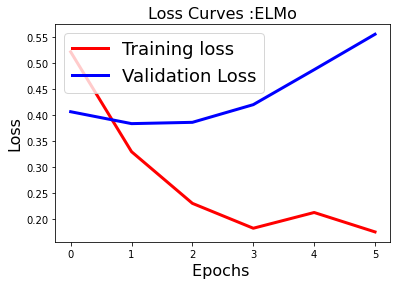

In [97]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :ELMo',fontsize=16)
fig1.savefig('loss_ELMo.png')
plt.show()

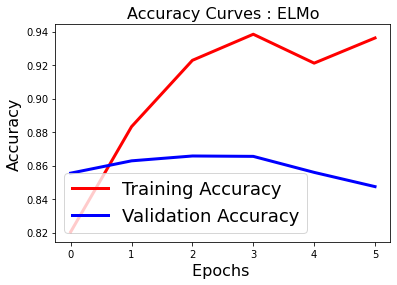

In [98]:
fig2=plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : ELMo',fontsize=16)
fig2.savefig('accuracy_ELMo.png')
plt.show()

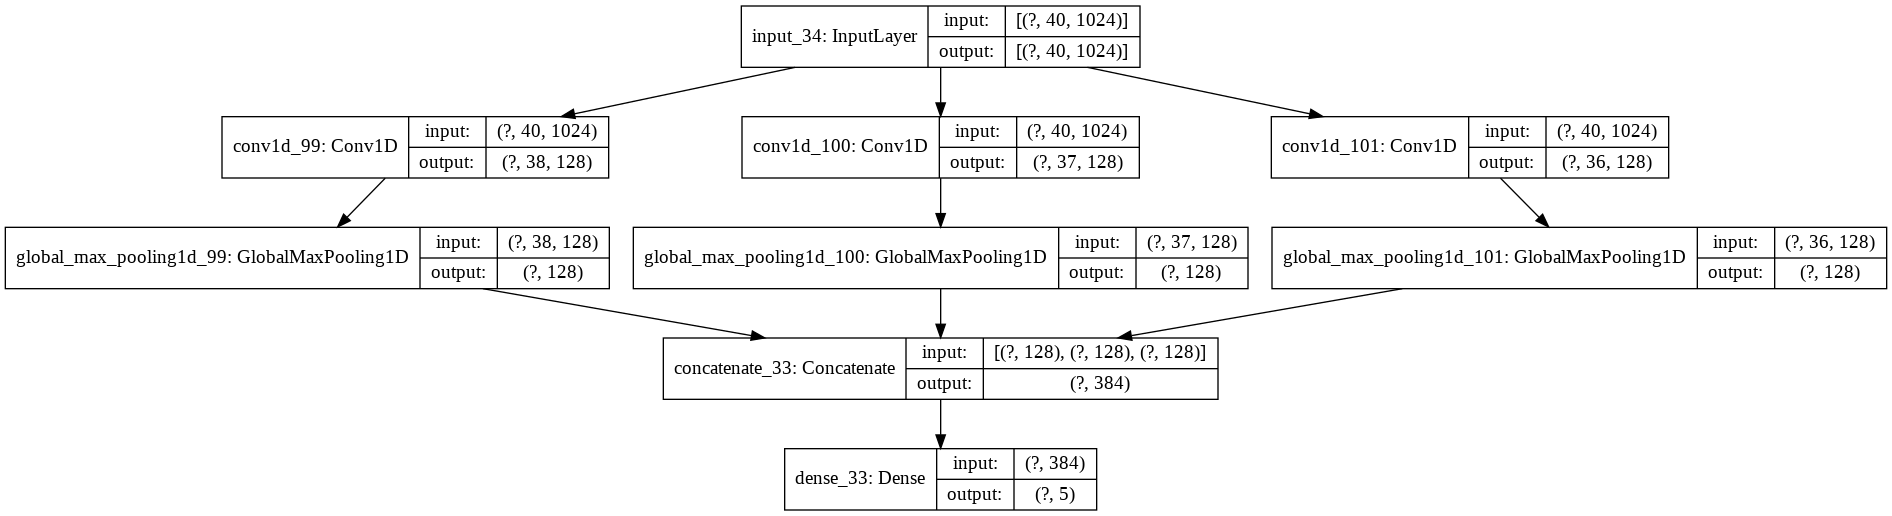

In [99]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)